# Case 1 - Load Factor Prediction

In [37]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)  # suppress scientific notation
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing as preproc # load preprocessing function
from sklearn.model_selection import KFold
from sklearn import linear_model 
from sklearn import ensemble  # ensemble method - AdaBoost in our case
from sklearn.model_selection import train_test_split  # cross-validation
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor  # KNN regression 
import scipy . linalg as lng
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

In [38]:
# import original xlsx
df = pd.read_excel('Realized Schedule 20210101-20220228.xlsx')

In [39]:
df

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,LJ,663,RUT,32N,J,US,186,0.682796


In [40]:
# check missing values 
print(df.isnull().sum())
print("There is no missing value found in the data set")

ScheduleTime    0
Airline         0
FlightNumber    0
Destination     0
AircraftType    0
FlightType      0
Sector          0
SeatCapacity    0
LoadFactor      0
dtype: int64
There is no missing value found in the data set


In [41]:
################################
#Process 'ScheduleTime' Feature#
################################
df.insert(1,'Year', df['ScheduleTime'].dt.year)  # insert a column for year

# calculate days passed from the first day of the year (xxxx-01-01 00:00:00)
df.insert(2,'DateReference', pd.to_datetime(df['Year'].astype(str) + '-01-01 00:00:00'))
df.insert(3,'DaysPassed', 
         ((df['ScheduleTime'] - df['DateReference'])/pd.Timedelta(1, 'd')).fillna(0).astype(int))
# calculate minutes passed from the beginning of the day (00:00:00)
df.insert(4,'MinutesPassed', (df['ScheduleTime'].dt.hour * 60 + df['ScheduleTime'].dt.minute).astype(int))
# calculate day of week (Monday - 0; Sunday - 6)
df.insert(5,'DayOfWeek', (df['ScheduleTime'].dt.dayofweek).astype(int))
df = df.drop('DateReference', 1)

In [42]:
# force types of each column
df['Year'] = df['Year'].astype(int)
df['DaysPassed'] = df['DaysPassed'].astype(int)
df['MinutesPassed'] = df['MinutesPassed'].astype(int)
df['DayOfWeek'] = df['DayOfWeek'].astype(int)
df['Airline'] = df['Airline'].astype(str)
df['FlightNumber'] = df['FlightNumber'].astype(int)
df['Destination'] = df['Destination'].astype(str)
df['AircraftType'] = df['AircraftType'].astype(str)
df['FlightType'] = df['FlightType'].astype(str)
df['Sector'] = df['Sector'].astype(str)
df['SeatCapacity'] = df['SeatCapacity'].astype(int)
df['LoadFactor'] = df['LoadFactor'].astype(float)

In [43]:
###################
#Holiday Indicator#
###################

################################
#Easter of 2021 - 4th of April##
#Easter of 2022 - 17th of April#
################################

multiplier = 7  # the number of days in Easter holiday
def add_holiday(x):
    if x.Year == 2021:
        day = 93  # Easter day of 2021 from new years day
    else:
        day = 106  # Easter day of 2022 from new years day
    indicator = (x.DaysPassed - day) * 0.1 if abs(x.DaysPassed - day) <= 10 else 0
    if indicator < 0:  # before Easter
        indicator += 1
    elif indicator > 0:  # after Easter
        indicator -= 1
    elif abs(x.DaysPassed - day) <= 10:
        indicator = 1
    indicator *= multiplier

    for i, v in x.items():
        if i == 'holidayIndicator':
            indicator += x.holidayIndicator
            break
    return indicator

holiday_column = df.apply(add_holiday, axis=1, result_type='expand')
df.insert(5,'HolidayIndicator', holiday_column.astype(float))

In [44]:
df

,ScheduleTime,Year,DaysPassed,MinutesPassed,DayOfWeek,HolidayIndicator,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,2021,0,395,4,0.0,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,2021,0,635,4,0.0,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,2021,0,725,4,0.0,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,2021,0,800,4,0.0,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,2021,0,860,4,0.0,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,2022,58,1125,0,0.0,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,2022,58,1165,0,0.0,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,2022,58,1200,0,0.0,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,2022,58,1170,0,0.0,LJ,663,RUT,32N,J,US,186,0.682796


In [33]:
# test HolidayIndicator
# pd.set_option('display.max_rows', 1000) # set the maximum number of rows to display
# df.loc[(df['ScheduleTime'].dt.month == 4) & (df['ScheduleTime'].dt.day <= 10) & (df['ScheduleTime'].dt.day >= 1)]

In [45]:
data = df.iloc[:, 1:].values  # dataframe to numpy after pre-processing, discard initial 'ScheduleTime'
data_without_encoders = df.iloc[:, 1:-1].values

################
#Label encoders#
################

# Year
le_year = LabelEncoder()
data[:, 0] = le_year.fit_transform(data[:, 0])
# data[:, 0] = le_year.inverse_transform(data[:, 0].astype(int))

# Airline
le_airline = LabelEncoder()
data[:, 5] = le_airline.fit_transform(data[:, 5])
# data[:, 5] = le_airline.inverse_transform(data[:, 5].astype(int))

# FlightNumber
le_flight_number = LabelEncoder()
data[:, 6] = le_flight_number.fit_transform(data[:, 6])
# data[:, 6] = le_flight_number.inverse_transform(data[:, 6].astype(int))

# Destination 
le_destination = LabelEncoder()
data[:, 7] = le_destination.fit_transform(data[:, 7])
# data[:, 7] = le_destination.inverse_transform(data[:, 7].astype(int))

# AircraftType
le_aircraft_type = LabelEncoder()
data[:, 8] = le_aircraft_type.fit_transform(data[:, 8])
# data[:, 8] = le_aircraft_type.inverse_transform(data[:, 8].astype(int))

# FlightType
le_flight_type = LabelEncoder()
data[:, 9] = le_flight_type.fit_transform(data[:, 9])
# data[:, 9] = le_flight_type.inverse_transform(data[:, 9].astype(int))

# Sector
le_sector = LabelEncoder()
data[:, 10] = le_sector.fit_transform(data[:, 10])
# data[:, 10] = le_sector.inverse_transform(data[:, 10].astype(int))

data = data.astype(float)

> $\textbf{raw_data}$ is the unstandardized version and should never be changed

> We should not standardize the target

In [46]:
raw_data = data
print(raw_data.shape)
print(raw_data)

(39449, 13)
[[   0.            0.          395.         ...   11.
   142.            0.4084507 ]
 [   0.            0.          635.         ...    1.
    74.            0.18918919]
 [   0.            0.          725.         ...   11.
   142.            0.57042254]
 ...
 [   1.           58.         1200.         ...   11.
    98.            0.85714286]
 [   1.           58.         1170.         ...   11.
   186.            0.6827957 ]
 [   1.           58.         1285.         ...    1.
   156.            0.82051282]]


In [199]:
# check holiday indicator
# np.set_printoptions(threshold=np.inf)
# print(raw_data[:, 4])

In [200]:
# calculate the mean and standard deviation of two ratio features
# seat capacity
seat_capacity_mean = np.mean(data[:, -2])
seat_capacity_std = np.std(data[:, -2])
print('The mean of seat capacity is {}'.format(seat_capacity_mean))
print('The standard deviation of seat capacity is {}'.format(seat_capacity_std))
# load factor
load_factor_mean = np.mean(data[:, -1])
load_factor_std = np.std(data[:, -1])
print('The mean of load factor is {}'.format(load_factor_mean))
print('The standard deviation of load factor is {}'.format(load_factor_std))

The mean of seat capacity is 155.64571979010876
The standard deviation of seat capacity is 58.65167669113129
The mean of load factor is 0.5374428655008451
The standard deviation of load factor is 0.27309062478150997


In [201]:
# standardize a single feature
def standardization(feature):
    new_feature = (feature - np.mean(feature)) / np.std(feature)
    return new_feature

# DaysPassed
# data[:, 1] = standardization(data[:, 1])
# MinutesPassed
# data[:, 2] = standardization(data[:, 2])
# SeatCapacity
# data[:, -2] = standardization(data[:, -2])
# LoadFactor
# data[:, -1] = standardization(data[:, -1])

# standardize multiple features (a matrix of features)
def standardize_X(features):
    new_features = np.zeros((np.shape(features)[0], np.shape(features)[1]))
    for i in range(np.shape(new_features)[1]):
        new_features[:, i] = standardization(features[:, i])
    return new_features

In [202]:
y_ols = data[:, -1]  # target - unstandardized
X_ols = standardize_X(data[:, :-1])  # features - standardized

<ipython-input-203-89d551de0796>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


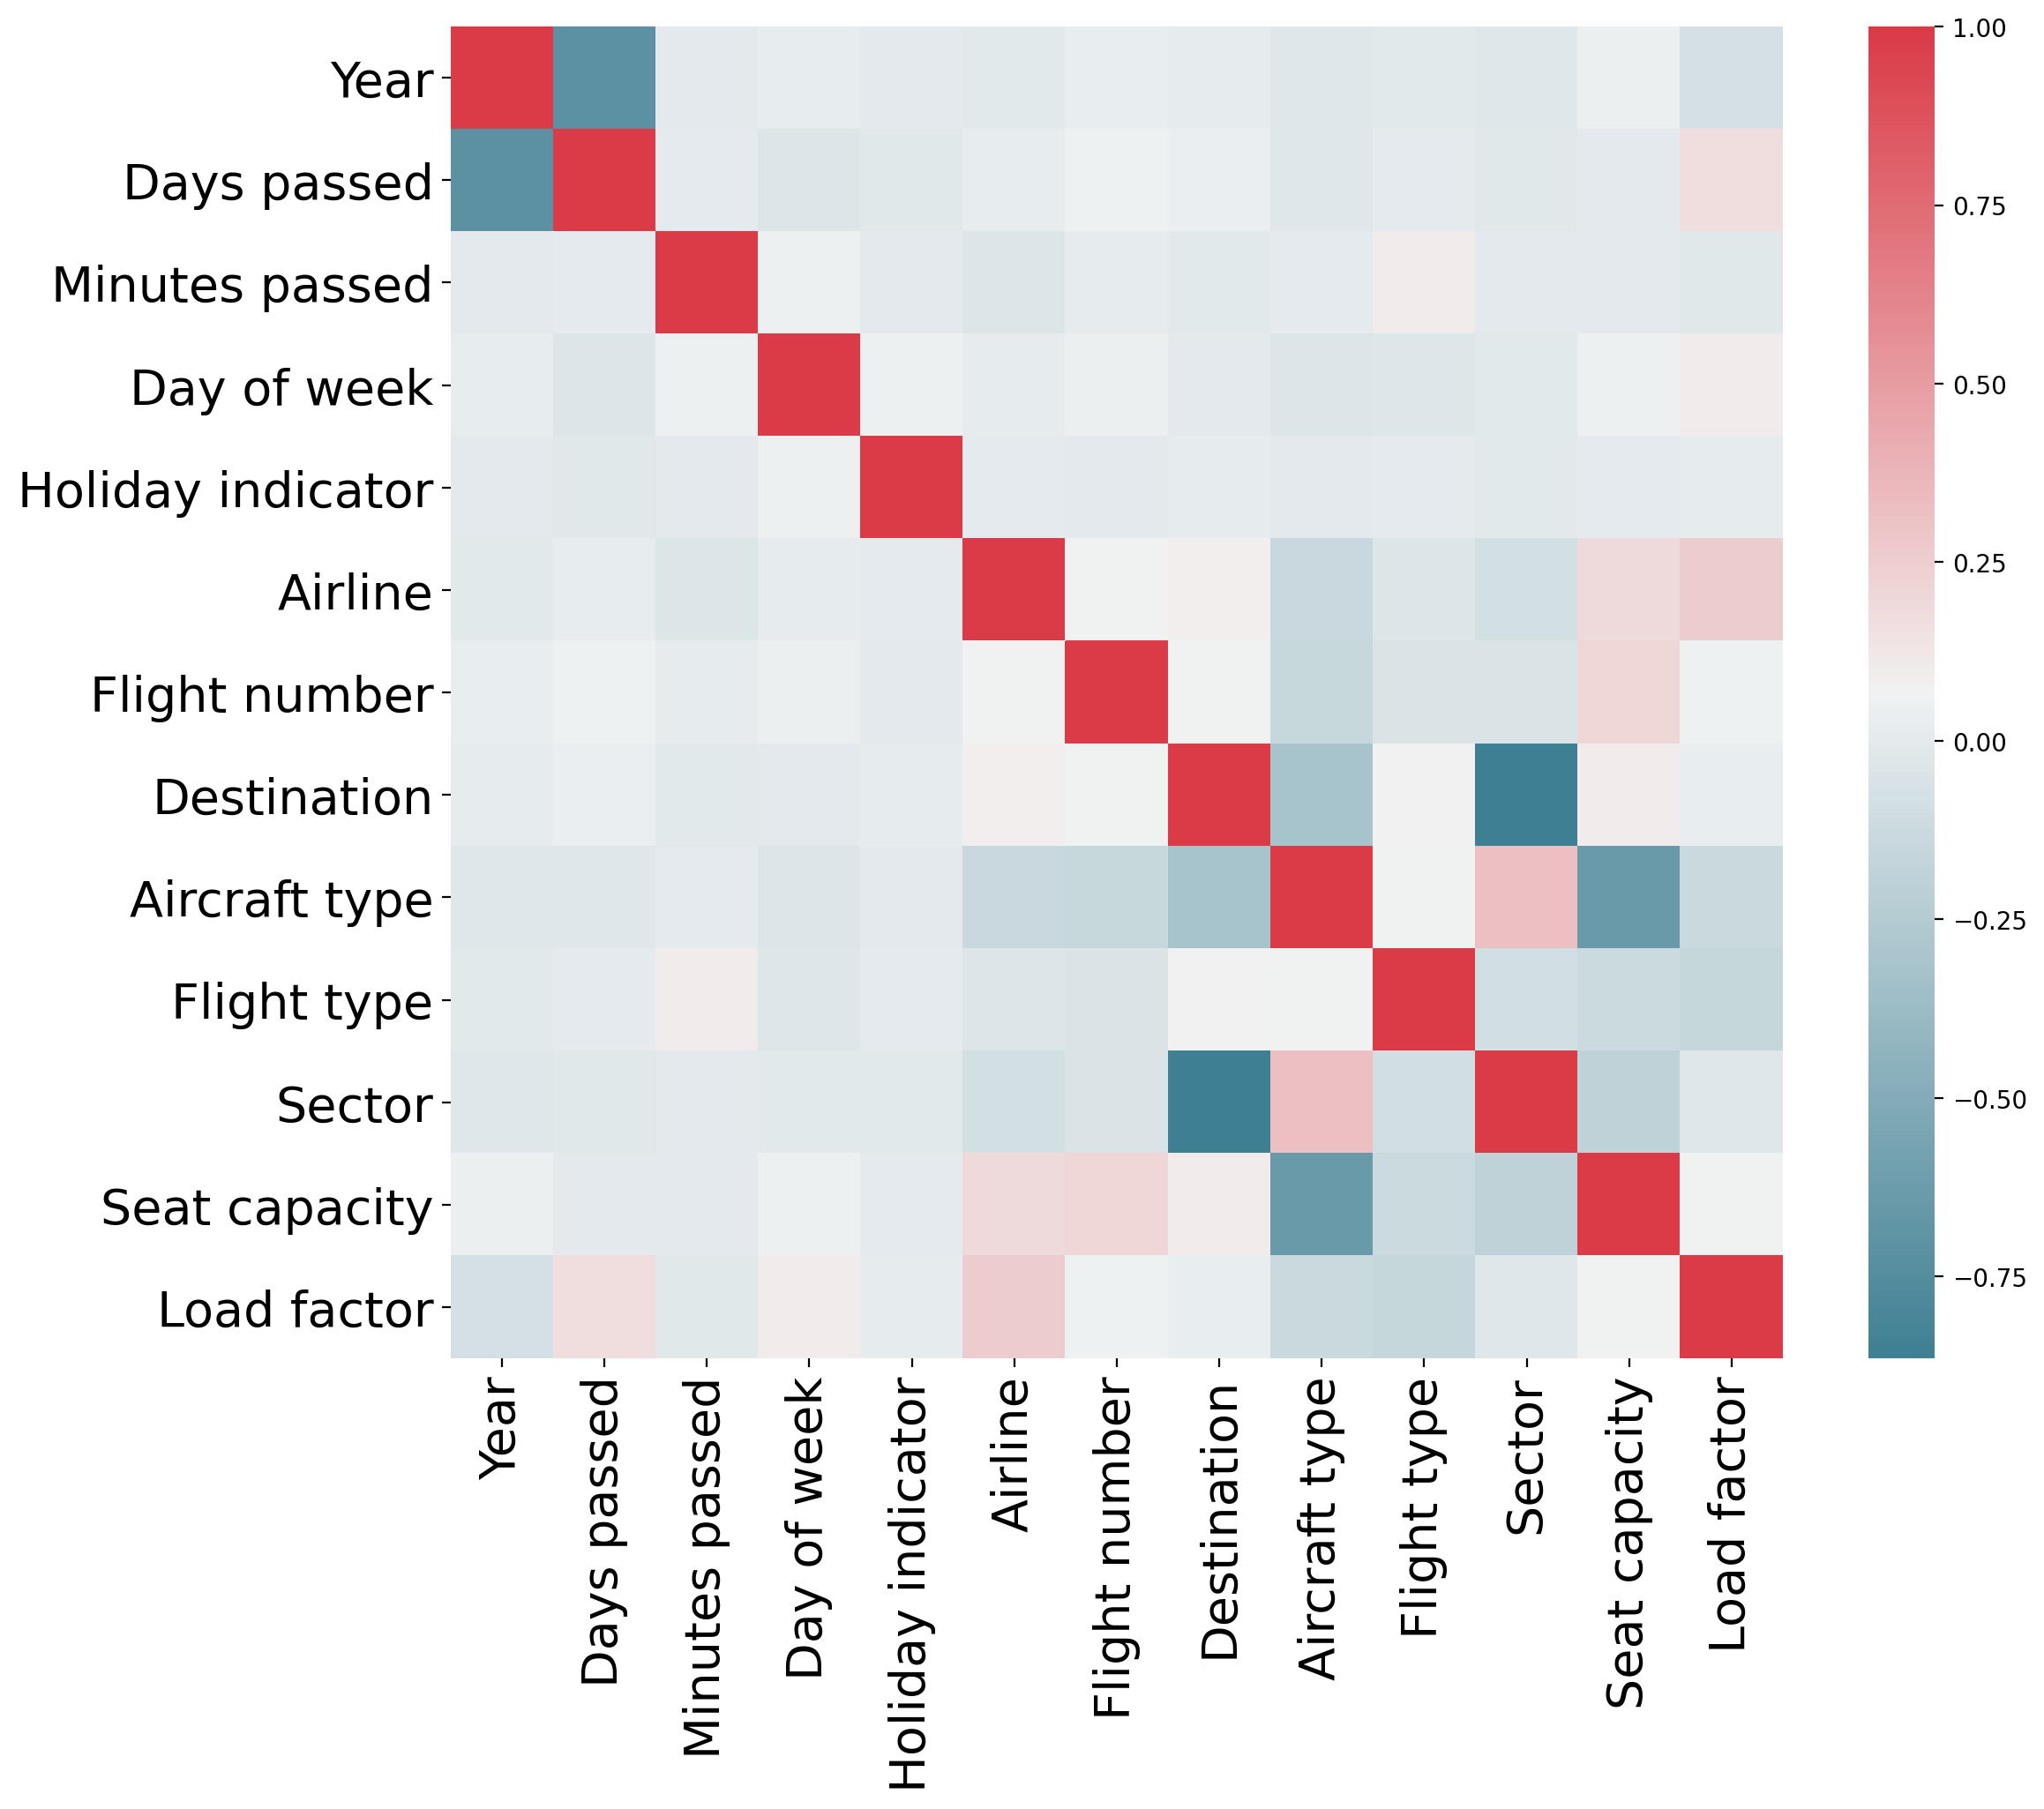

In [203]:
# correlation heatmap of processed data
df2 = pd.DataFrame(standardize_X(data), 
                   columns=['Year', 'Days passed', 'Minutes passed',
                           'Day of week', 'Holiday indicator', 'Airline', 'Flight number', 'Destination', 
                            'Aircraft type', 'Flight type', 'Sector', 'Seat capacity', 'Load factor'])
f, ax = plt.subplots(figsize=(12.5, 10), dpi=200)
corr = df2.corr() # calculates Pearsons coff.
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
# sns.set(font_scale = 5)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig("Figures/corr_matrix.png", bbox_inches='tight',dpi=200)

## Ordinary Least Squares (OLS) - baseline
> Here we can also calculate the noise variance $\hat{\delta}_e^2$ of information criterias AIC and BIC

In [204]:
[n, p] = np.shape(X_ols)

beta_ols, _, _, _ = lng.lstsq(X_ols, y_ols)
yhat_ols = np.sum(beta_ols*X_ols, axis=1)
MSE_ols = np.sum((y_ols - yhat_ols)**2)/np.size(y_ols)
print('Weights for OLS regression: \n {}'.format(beta_ols))
print('MSE for OLS regression: {}'.format(MSE_ols))

print('**********************************************************')

# calculate the noise variance of AIC and BIC
e = y_ols - X_ols @ beta_ols
s = np.std(e)  # the noise variance of AIC and BIC
print('The noise variance of AIC and BIC is: {}'.format(s))

Weights for OLS regression: 
 [ 0.02351622  0.06328327 -0.00011309  0.02754652  0.00366633  0.06744619
  0.00511124 -0.00786592 -0.0400616  -0.03966501 -0.00042568 -0.0281002 ]
MSE for OLS regression: 0.35272534565091557
**********************************************************
The noise variance of AIC and BIC is: 0.25274594353452273


Feature: 0, Score: 0.02352
Feature: 1, Score: 0.06328
Feature: 2, Score: -0.00011
Feature: 3, Score: 0.02755
Feature: 4, Score: 0.00367
Feature: 5, Score: 0.06745
Feature: 6, Score: 0.00511
Feature: 7, Score: -0.00787
Feature: 8, Score: -0.04006
Feature: 9, Score: -0.03967
Feature: 10, Score: -0.00043
Feature: 11, Score: -0.02810


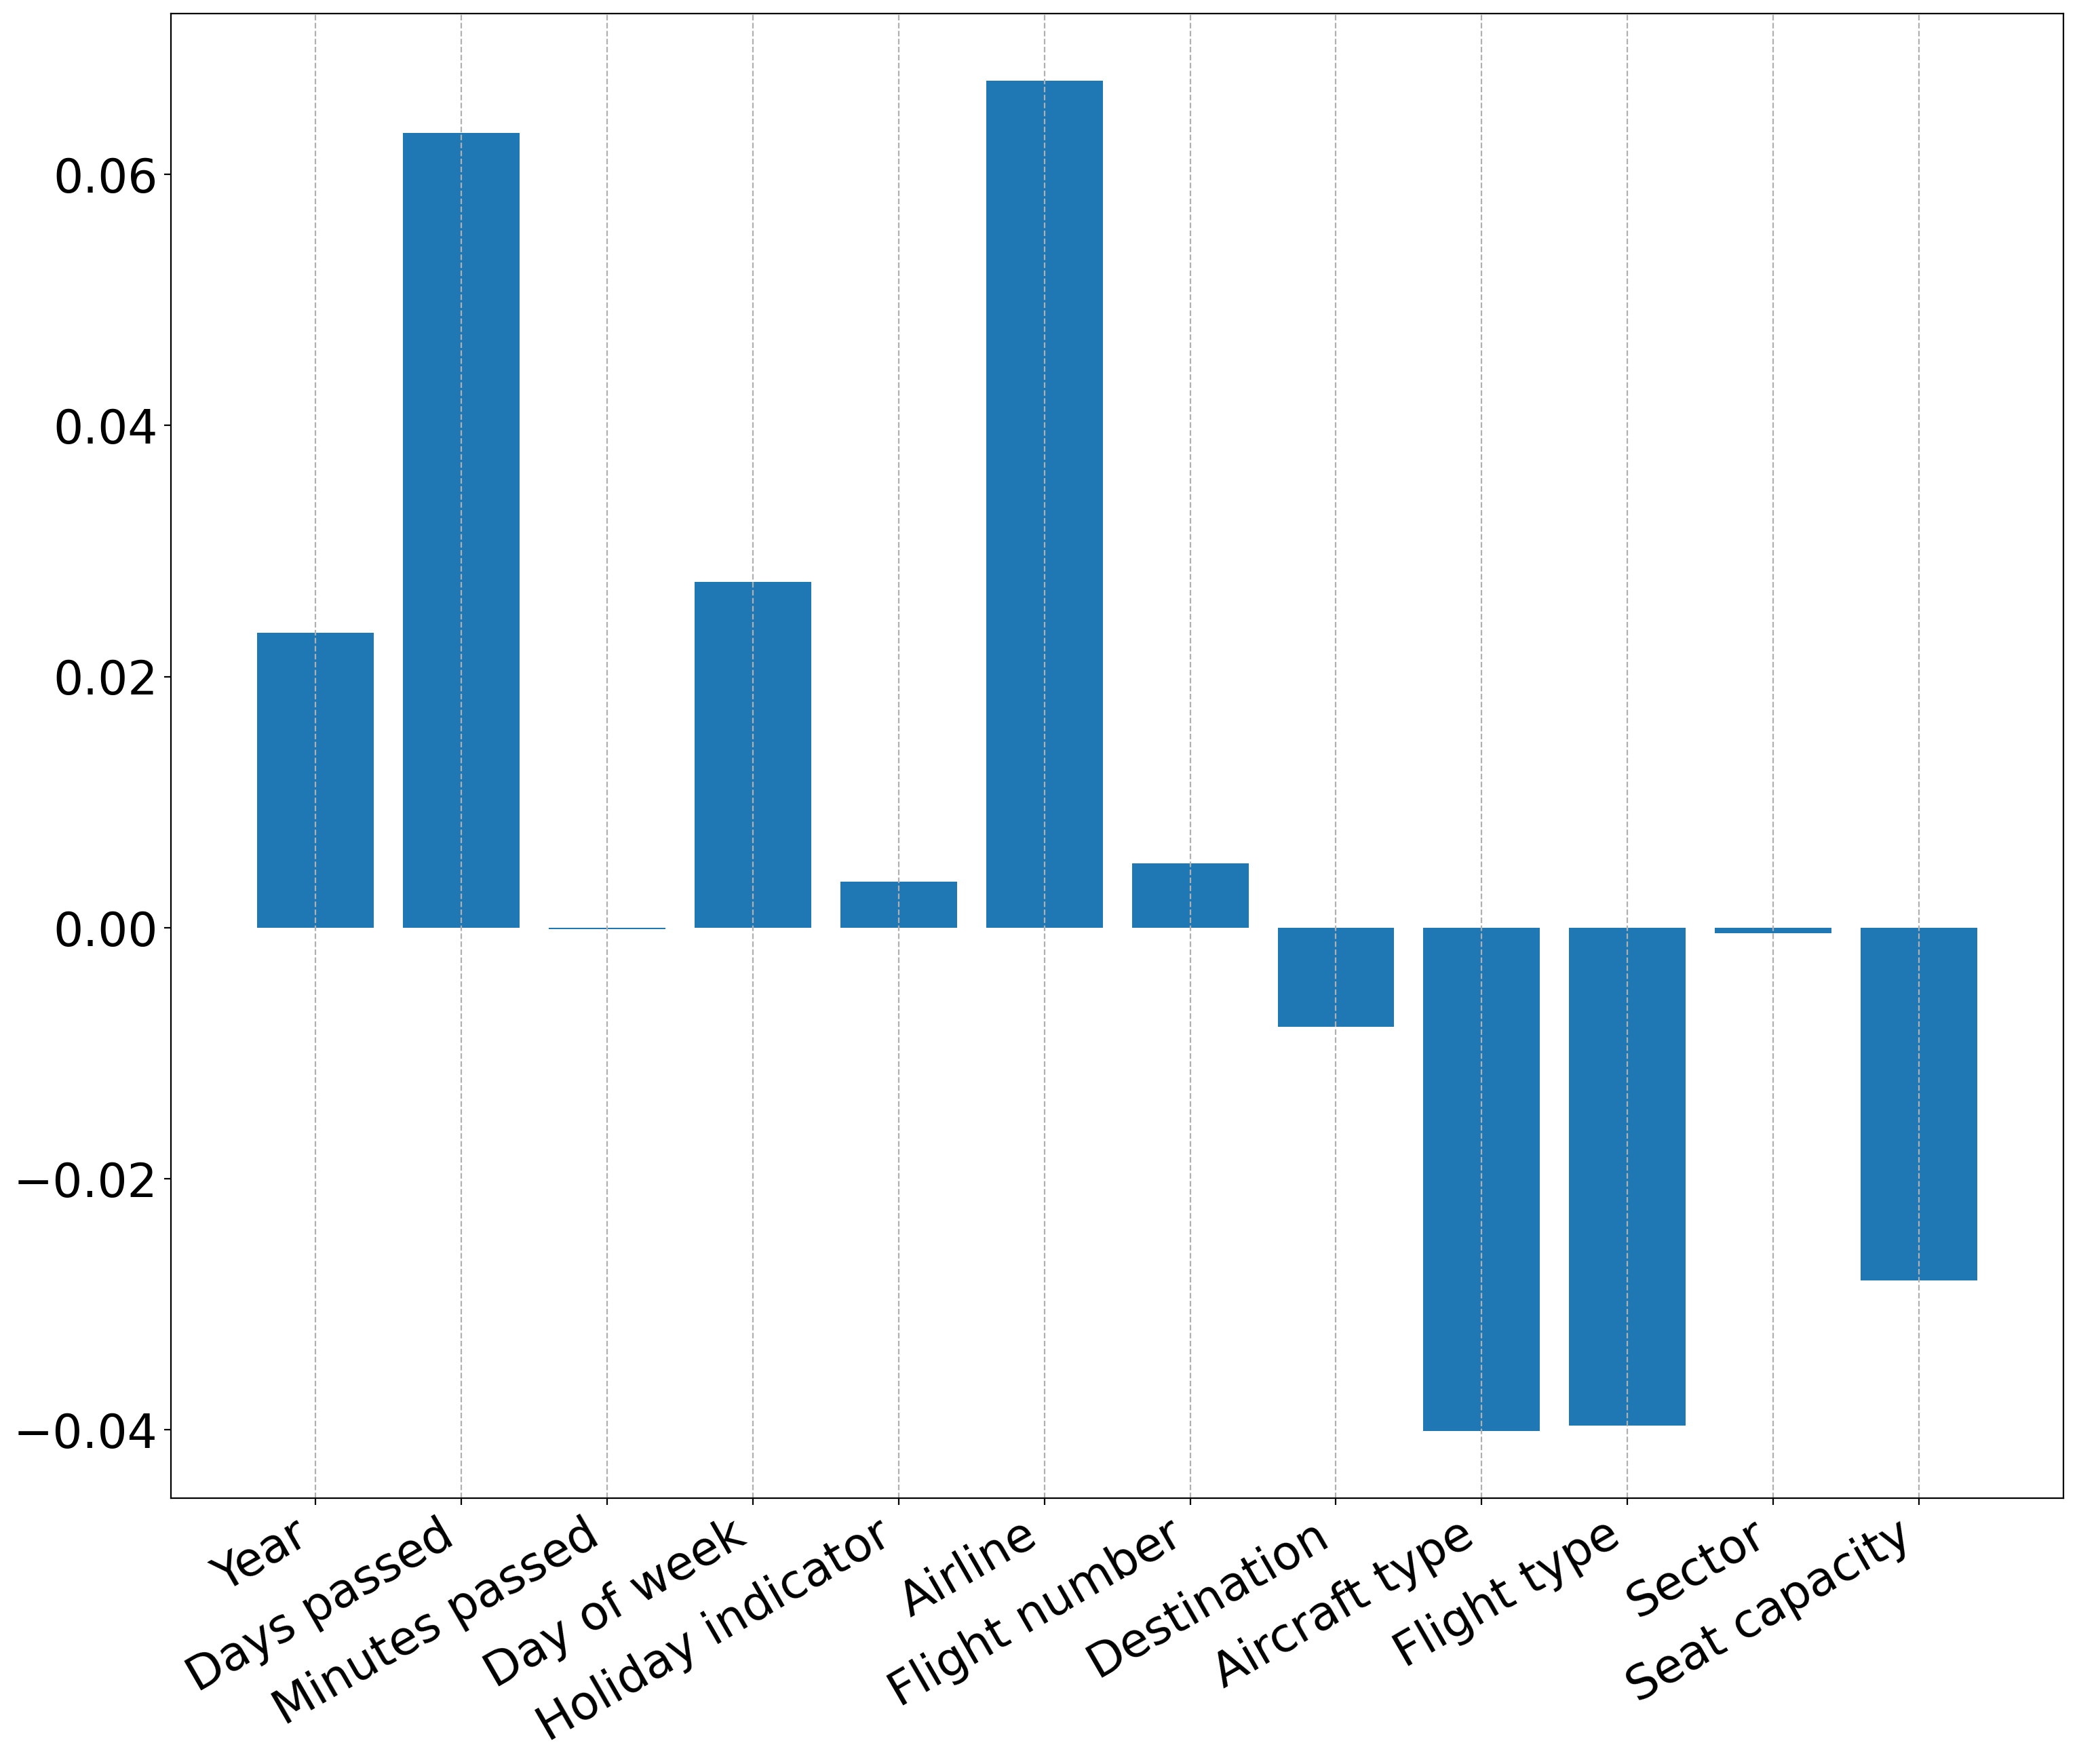

In [205]:
# Bar chart feature impotance
for i,v in enumerate(beta_ols):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
features=['Year', 'Days passed', 'Minutes passed',
         'Day of week', 'Holiday indicator', 'Airline', 'Flight number', 'Destination', 
         'Aircraft type', 'Flight type', 'Sector', 'Seat capacity']
plt.figure(figsize=(18, 14.5), dpi=200)
plt.bar([x for x in range(len(beta_ols))], beta_ols)
plt.xticks([x for x in range(len(beta_ols))], features, rotation = 30, fontsize = 25, ha='right')
plt.yticks(fontsize = 25)
plt.gca().xaxis.grid(True, linestyle='dashed')
plt.savefig("Figures/hist_feature_importance.png")
plt.show()

In [209]:
X_o = raw_data[:, :-1]  # without standardization
y_o = raw_data[:, -1]  # without standardization

# n - the number of observations; p - the number of features
[n, p] = np.shape(X_o)

K = 10 # the number folds
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

MSE = np.zeros(10)

for i in range(1, K+1):
    # Select the train/test data in this fold
    XTrain = X_rr[i != I, :]
    yTrain = y_rr[i != I]
    XTest = X_rr[i == I, :]
    yTest = y_rr[i == I]
    
    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)
    
    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)
    
    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data  
    MSE[(i - 1)] = np.mean((yTest - np.matmul(XTest, beta_ols)) ** 2)

In [212]:
print(MSE)
print('The test error of OLS: {}'.format(np.mean(MSE)))

[0.07422597 0.07573165 0.07301675 0.07403495 0.0735279  0.07484487
 0.07498475 0.07324895 0.07202371 0.07680914]
The test error of OLS: 0.07424486369679353


## Ridge Regression with Cross validation
$L_2$-regularization with $K=10$ fold cross-validation and one-standard-error rule to select the optimal $\lambda$.

In [20]:
def ridgeMulti(X, _lambda, p, y):
    inner_prod = np.linalg.inv(X.T @ X + _lambda * np.eye(p,p))
    outer_prod = X.T @ y
    betas = inner_prod @ outer_prod
    return betas

In [74]:
def centerData(data):
    mu = np.mean(data,axis=0)
    centered_data = data - mu  
    return centered_data, mu

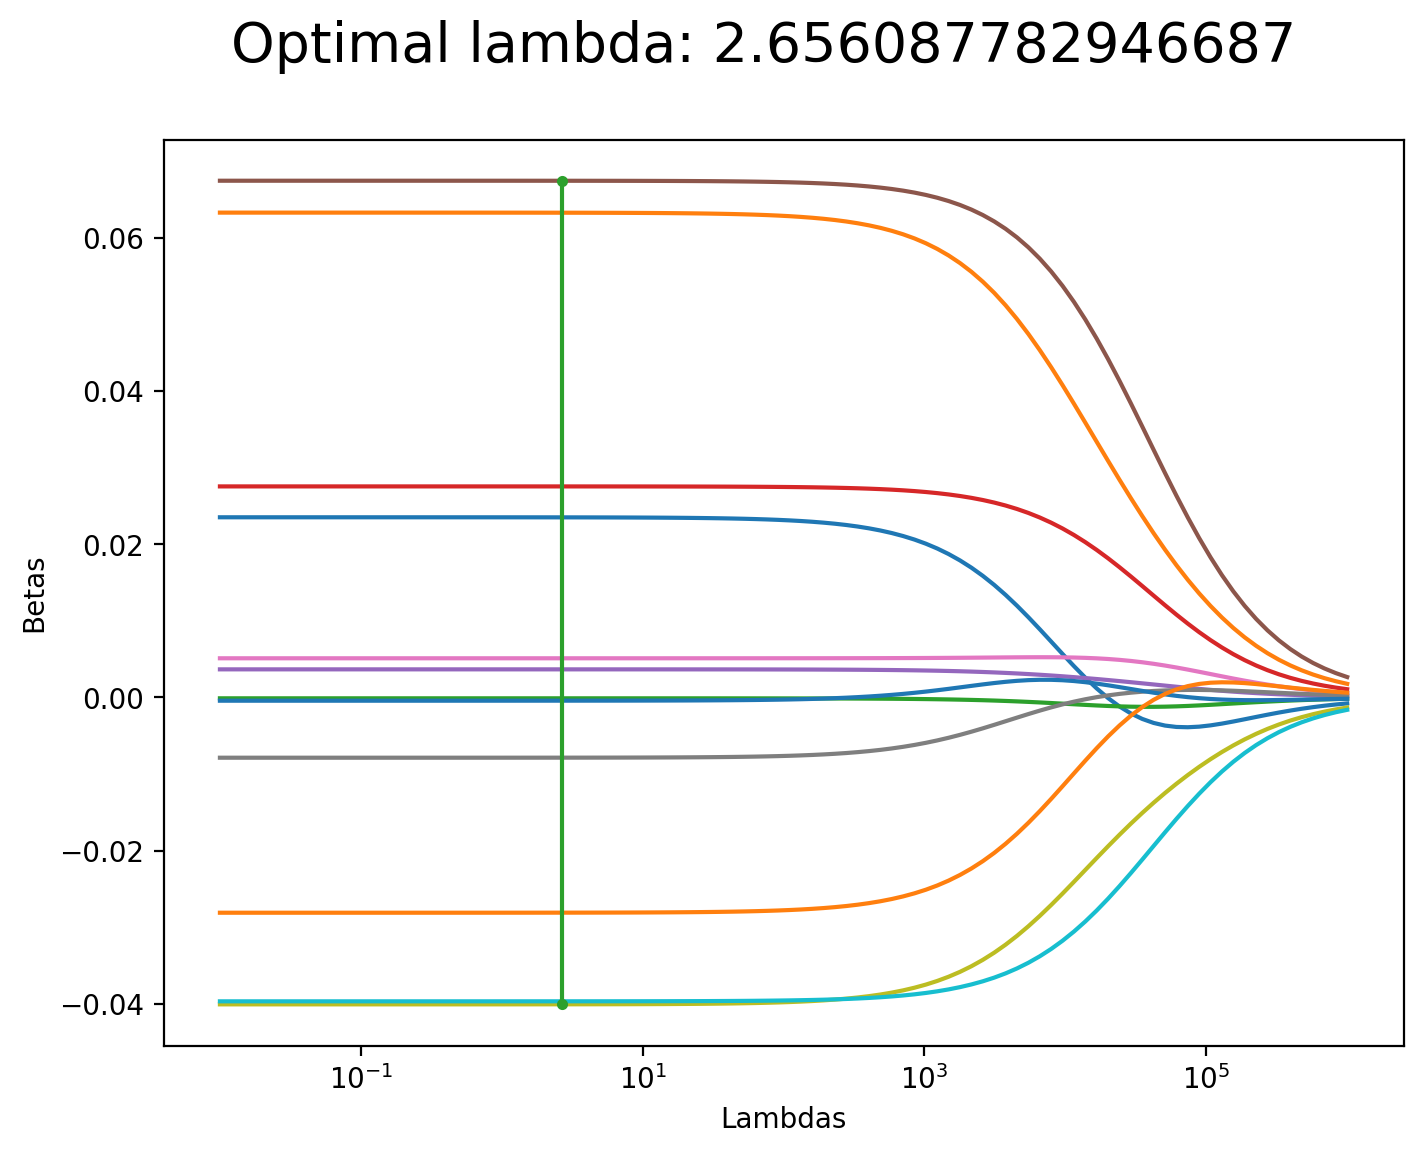

In [22]:
X_rr = raw_data[:, :-1]  # without standardization
y_rr = raw_data[:, -1]  # without standardization

X_rr_std = standardize_X(X_rr)  # apply standardization - standardized
y_rr_std = y_rr  # unstandardized

# n - the number of observations; p - the number of features
[n, p] = np.shape(X_rr)

K = 10 # the number folds
k = 100 # the number of lambdas investigated 
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

lambdas = np.logspace(-2, 6, k)
MSE = np.zeros((10, 100))

betas = np.zeros((p,k))  # p - the number of features which equals to the dimension of betas
    
for i in range(k):
    betas[:, i] = ridgeMulti(X_rr_std, lambdas[i], p, y_rr_std)

for i in range(1, K+1):
    
    # Select the train/test data in this fold
    XTrain = X_rr[i != I, :]
    yTrain = y_rr[i != I]
    XTest = X_rr[i == I, :]
    yTest = y_rr[i == I]
    
    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)
    
    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)
    
    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response
    
    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data
    
    #Fit ridgeregression
    for j in range(100):
        beta = ridgeMulti(XTrain, lambdas[j], p, yTrain)
        MSE[(i - 1), j] = np.mean((yTest - np.matmul(XTest, beta)) ** 2)

        
meanMSE = np.mean(MSE, axis = 0)
jOpt = np.argsort(meanMSE)[0]
lambda_OP = lambdas[jOpt]


# Remember excact solution depends on a random indexing, so results may vary
# I reuse the plot with all the betas from 1 a) and add a line for the optimal value of lambda
plt.figure(figsize=(8, 6), dpi=200)
plt.semilogx(lambdas, betas.T )
plt.xlabel("Lambdas")
plt.ylabel("Betas")
plt.suptitle(f"Optimal lambda: {lambda_OP}", fontsize=20)
plt.semilogx([lambda_OP, lambda_OP], [np.min(betas), np.max(betas)], marker = ".")
plt.savefig("Figures/CV_Ridge.png")
plt.show()

In [23]:
# Calculate the standard error for the best lambda, and find a the largest lambda with a MSE that is within
# the range of the optimal lambda +- the standard error.

seMSE = np.std(MSE, axis = 0) / np.sqrt(K)  # standard error
# print(meanMSE)
# print(np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE))
J = np.where(meanMSE[jOpt] + seMSE[jOpt] > meanMSE)[0]  # select lambda satisfy this criteria
j = int(J[-1:])  # choose the last one - largest lambda
Lambda_CV_1StdRule = lambdas[j]
print("CV lambda with 1-std-rule %0.2f" % Lambda_CV_1StdRule)

CV lambda with 1-std-rule 3.20


### Test error of Ridge Regression without and with one-standard-error rule

In [24]:
print('Test error without one-standard-error rule: {}'.format(np.mean(MSE[:, jOpt])))
print('Test error with one-standard-error rule: {}'.format(np.mean(MSE[:, j])))

Test error without one-standard-error rule: 0.06532113981416886
Test error with one-standard-error rule: 0.06554938337944431


In [25]:
# y_rr_std is actually unstandardized
beta_rr = ridgeMulti(X_rr_std, Lambda_CV_1StdRule, p, y_rr_std)
yhat_rr = np.sum(beta_rr*X_rr_std, axis=1)
MSE_rr = np.sum((y_rr_std - yhat_rr)**2)/np.size(y_rr_std)
print('Weights for Ridge Regression: \n {}'.format(beta_rr))
print('MSE for Ridge Regression: {}'.format(MSE_rr))

Weights for Ridge Regression: 
 [ 0.02350434  0.06326964 -0.00011342  0.02754416  0.00366582  0.06744018
  0.00511137 -0.00785849 -0.04005279 -0.03966144 -0.00042081 -0.0280899 ]
MSE for Ridge Regression: 0.3527253458502512


## AIC and BIC
> Notice! - this will take long time to proceed - $\textbf{DO NOT run AIC and BIC!!!}$

In [46]:
# we have included 100 lambdas in CV / the noise variance s has been calculated in OLS part
D = np.zeros(100)
AIC = np.zeros(100)
BIC = np.zeros(100)

X_pre = X_rr_std  # standardized - features
y_pre = y_rr_std  # unstandardized - target


for j in range(100):
    beta_ridge = ridgeMulti(X_pre, lambdas[j], p, y_pre)
    
    inner = np.linalg.inv(X_pre.T @ X_pre + lambdas[j] * np.eye(p))
    outer = (X_pre @ inner) @ X_pre.T
    D[j] = np.trace(outer)  # the effective number of parameters tuned with lambda - np.trace: the sum of diagonal
    
    e = y_pre - X_pre @ beta_ridge
    err = np.sum(e ** 2) / n
    AIC[j] = err + 2 * D[j] / n * s ** 2
    BIC[j] = n / (s ** 2) * (err + np.log(n) * D[j] / n * s ** 2)

jAIC = np.argsort(AIC)[0]  # choose the index of lambda having smallest AIC
jBIC = np.argsort(BIC)[0]  # choose the index of lambda having smallest BIC

print("AIC at %0.2f" % lambdas[jAIC])
print("BIC at %0.2f" % lambdas[jBIC])

AIC at 43.29
BIC at 231.01


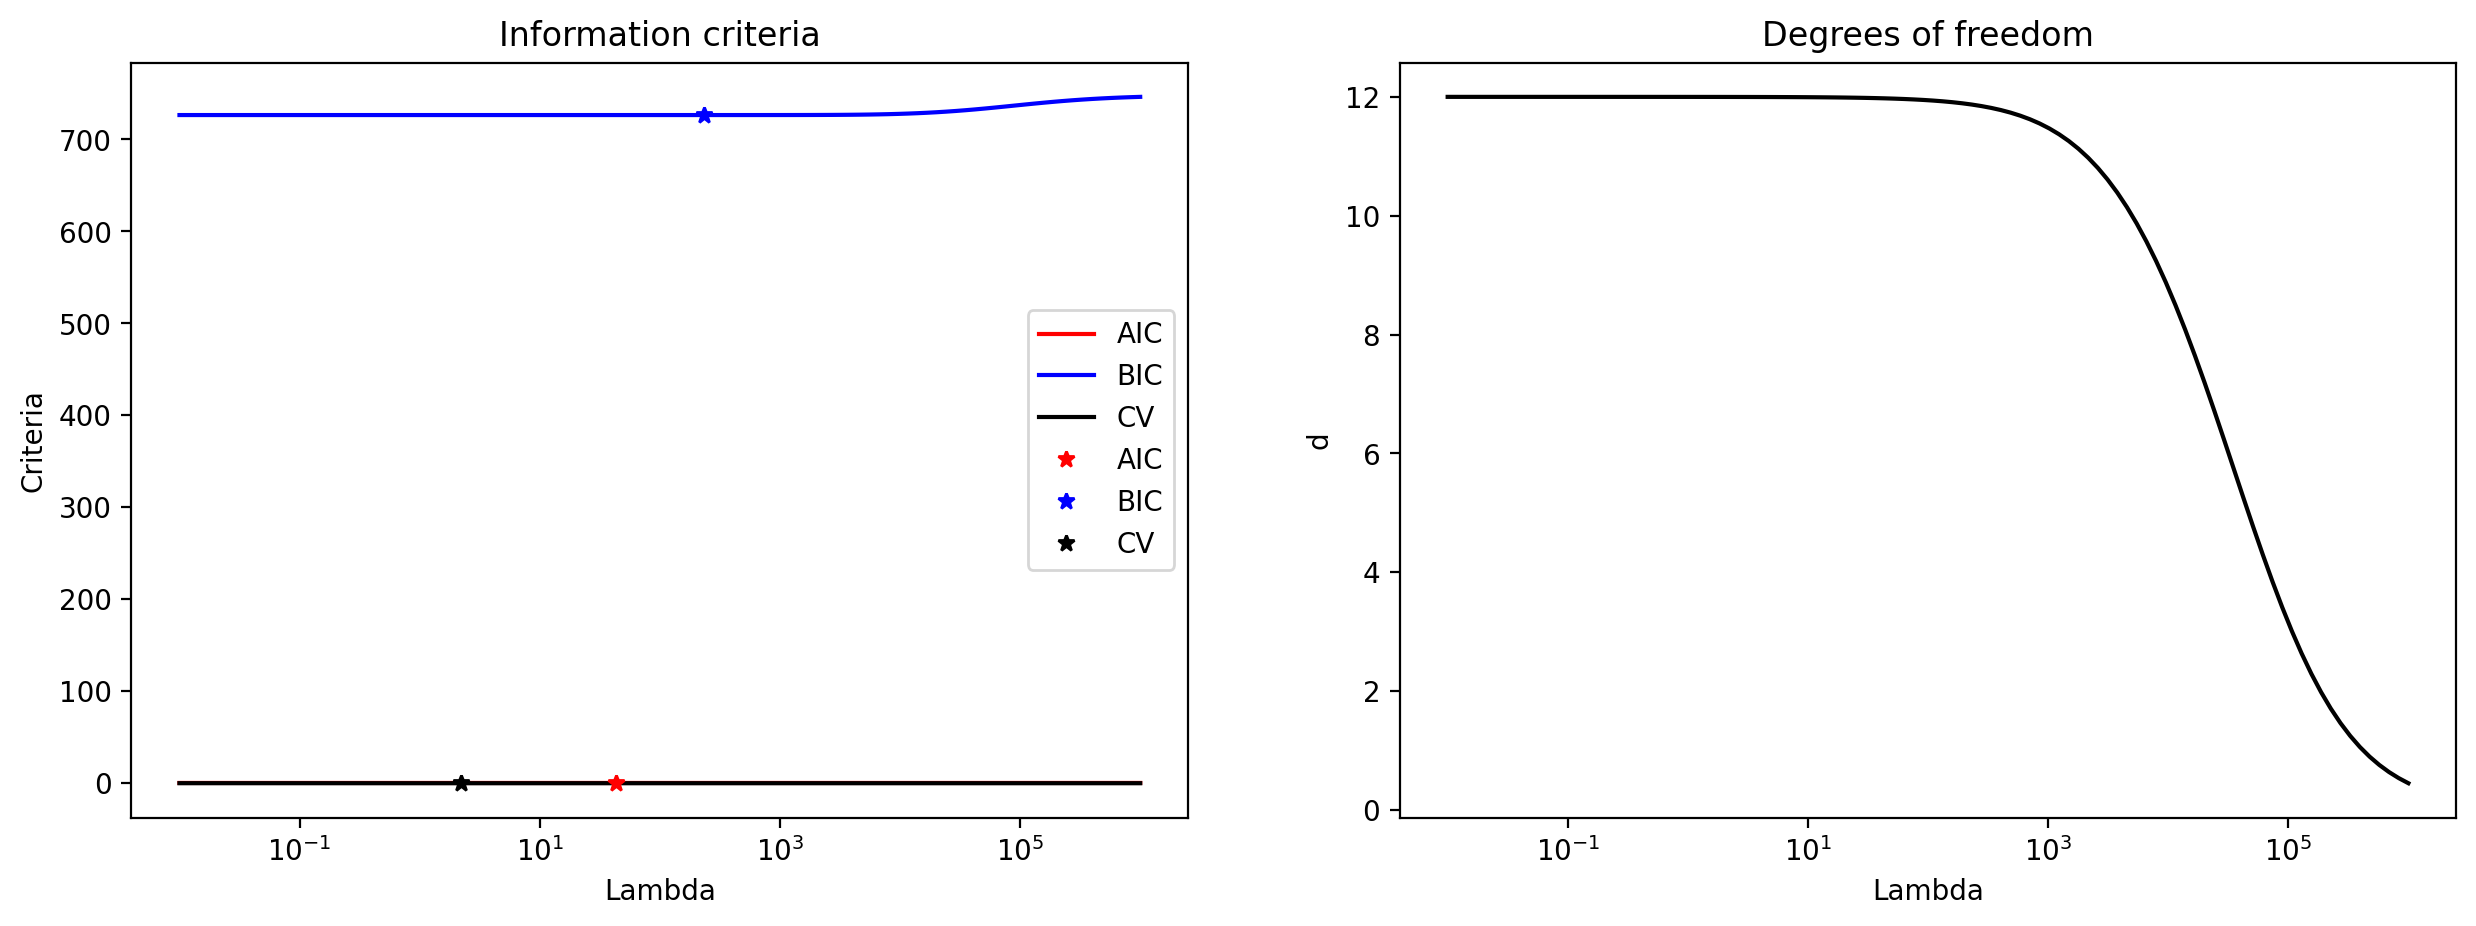

In [49]:
#plot different methods Information criteria: AIC BIC CV
fig, axs = plt.subplots(1, 2, figsize=(15,5), dpi = 200)
axs[0].set_title('Information criteria')
_ = axs[0].semilogx(lambdas,AIC,'-r',label='AIC')
axs[0].semilogx(lambdas,BIC/300,'-b',label='BIC')
axs[0].semilogx(lambdas,meanMSE,'-k',label='CV')
axs[0].semilogx(lambdas[jAIC],np.min(AIC),'*r',label='AIC')
axs[0].semilogx(lambdas[jBIC],np.min(BIC)/300,'*b',label='BIC')
axs[0].semilogx(lambdas[jOpt],np.min(meanMSE),'*k',label='CV')
axs[0].legend()
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel('Criteria')

#plot the degree of freedom
axs[1].semilogx(lambdas,D,'-k');
axs[1].set_title('Degrees of freedom');
axs[1].set_xlabel('Lambda');
axs[1].set_ylabel('d');

# save figure 
plt.savefig("Figures/information_criteria.png")

> Summary of Ridge Regression: It has no improvement comparing with OLS and even slightly worse cause the model is too simple to predict the result, which is a sign that no regularization is needed for the model.


## The Lasso
- features selection with Least Angle Regression Selection(LARS) Algorithm 
- $\textbf{DO NOT run!!!}$

### LARS

In [74]:
X_lars = raw_data[:, :-1]  # without standardization
y_lars = raw_data[:, -1]  # without standardization

X_lars_std = standardize_X(X_lars)  # apply standardization - standardized
y_lars_std = y_lars  # unstandardized

CV = 10  # 10-fold cross-validation

kf = KFold(n_splits=CV)
stop = n-math.ceil(n/CV)
K = range(stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 

# Lars
for i, (train_index, test_index) in enumerate(kf.split(X_lars)):
    ytrain = y_lars[train_index].ravel() # ravel collapses the array, ie dim(x,1) to (x,)
    ytest = y_lars[test_index].ravel() 
    Xtrain = X_lars[train_index]
    Xtest = X_lars[test_index]

    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.    
    ytrain, mu = centerData(ytrain); # center training response
    ytest = ytest - mu; # use the mean value of the training response to center the test response
    
    Xtrain, mu = centerData(Xtrain); # center training data
    Xtest = Xtest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(Xtrain.T) # Calculate training normalizer
    normalizer_test = preproc.Normalizer().fit(Xtest.T) # Calculate testing normalizer
    Xtrain = normalizer_train.transform(Xtrain.T).T # normalize training data
    Xtest = normalizer_test.transform(Xtest.T).T # normalize test data

    # compute all LARS solutions
    for j in K:
        # it is somewhat like forward step regression
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path = False, fit_intercept = False, verbose = True)
        reg.fit(Xtrain,ytrain)
        beta = reg.coef_.ravel()
        
        # Predict with this model, and find error
        YhatTr = Xtrain @ beta
        YhatTest = Xtest @ beta
        
        Err_tr[i-1, j] = np.mean((YhatTr-ytrain)**2) # training error
        Err_tst[i-1, j] = np.mean((YhatTest-ytest)**2) # test error
        
err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [75]:
print('The smallest test error: {}'.format(np.min(err_tst)))

The smallest test error: 0.07182843756590541


In [76]:
Betas = np.zeros((p, n))
for j in range(n):
    reg = linear_model.Lars(n_nonzero_coefs=j, normalize=True)
    reg.fit(X_lars_std,y_lars_std)
    Betas[:,i] = reg.coef_

In [77]:
for j in range(len(K)):
    Yhat = X_lars_std @ Betas[:,K[j]]

In [78]:
# this indicates that beta = 0
for i in range(len(Yhat)):
    if Yhat[i] != 0:
        print(i)
        print(Yhat[i])

In [79]:
print('MSE for Lasso with LARS: {}'.format(np.mean(((y_lars_std-Yhat)**2))))

MSE for Lasso with LARS: 0.36342332302131486


## AdaBoost regression

In [29]:
# start with raw data
print(raw_data[:, :-1])
print(raw_data[:, -1])
print(raw_data.shape)

[[   0.    0.  395. ...    2.   11.  142.]
 [   0.    0.  635. ...    2.    1.   74.]
 [   0.    0.  725. ...    2.   11.  142.]
 ...
 [   1.   58. 1200. ...    2.   11.   98.]
 [   1.   58. 1170. ...    2.   11.  186.]
 [   1.   58. 1285. ...    2.    1.  156.]]
[0.4084507  0.18918919 0.57042254 ... 0.85714286 0.6827957  0.82051282]
(39449, 13)


In [95]:
ada_data = raw_data  # data used for AdaBoost
X_ada = ada_data[:, :-1]
X_ada_std = standardize_X(X_ada)  # standardize features 
y_ada = ada_data[:, -1]  # target remains unstandardized
# print(X_ada)
# print(y_ada)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_ada_std, y_ada, test_size = 0.1, random_state = 42)

In [61]:
# Choosing Decision Tree with 1 level as the weak learner
DTR = DecisionTreeRegressor(max_depth = 6)
RegModel = AdaBoostRegressor(n_estimators = 50, base_estimator = DTR ,learning_rate = 0.25)
# Printing all the parameters of Adaboost
print(RegModel)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6),
                  learning_rate=0.25)


In [62]:
# Creating the model on Training Data
AB = RegModel.fit(X_train, y_train)
prediction = AB.predict(X_test)
 
# Measuring Goodness of fit in Training data
print('R2 Value:',metrics.r2_score(y_train, AB.predict(X_train)))
 
# Measuring accuracy on Testing Data
print('Test error:', np.mean(((y_test - prediction)**2)))
print('Test error (baseline):', np.mean(((y_test - np.mean(y_test))**2)))

R2 Value: 0.4354175411560465
Test error: 0.04260711800295439
Test error (baseline): 0.0749413030018211


## Model selection with cross validation

### Maximum tree depth & Loss function

In [105]:
# n - the number of observations; p - the number of features
[n, p] = np.shape(X_ada)

K = 10 # the number folds
k = 10 # the number of maximum tree depth investigated 
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

depths = np.arange(1, 11)  # the investigated maximum tree depth is from 1 to 10
losses = np.array(['linear', 'square', 'exponential']) # the loss functions to be investigated
MSE_ada = np.zeros((10, 10, 3))
MSE_2d = np.zeros((10, 3))

for i in range(1, K+1):

    # Select the train/test data in this fold
    XTrain = X_ada[i != I, :]
    yTrain = y_ada[i != I]
    XTest = X_ada[i == I, :]
    yTest = y_ada[i == I]

    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)

    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)

    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response

    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data

    for j in range(10):
        depth = depths[j]
        DTR = DecisionTreeRegressor(max_depth = depth)
        for k in range(3):
            RegModel = AdaBoostRegressor(n_estimators = 25, base_estimator = DTR ,
                                         learning_rate = 0.25, loss = losses[k])
            AB = RegModel.fit(XTrain, yTrain)
            prediction = AB.predict(XTest)
            MSE_2d[j, k] = np.mean((yTest - prediction) ** 2)
            # print(np.mean((yTest - prediction) ** 2))
        # print('--------------')
    MSE_ada[i-1, :, :] = MSE_2d

LINEAR loss function
best maximum tree depth: 1
test error: 0.06862695837238701
------------------------------------------
SQUARE loss function
best maximum tree depth: 1
test error: 0.06898930726400349
------------------------------------------
EXPONENTIAL loss function
best maximum tree depth: 1
test error: 0.06860588355312901
------------------------------------------


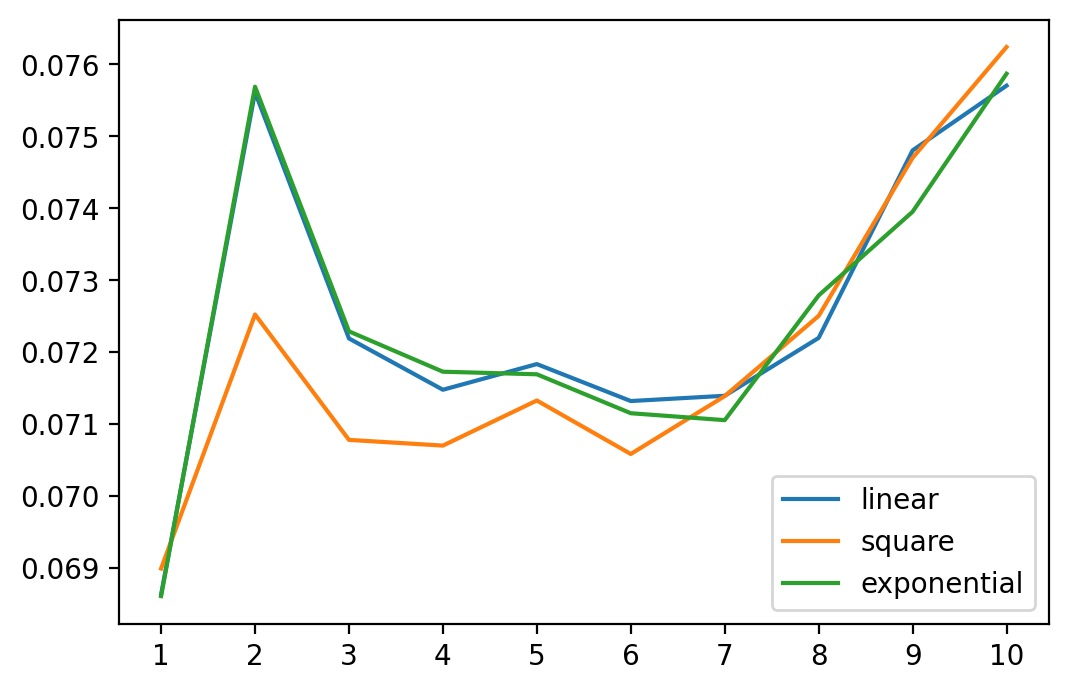

In [106]:
MSE_ada_mean = np.mean(MSE_ada, axis = 0)
y_linear = MSE_ada_mean[:, 0]
y_square = MSE_ada_mean[:, 1]
y_exponential = MSE_ada_mean[:, 2]
xmin_linear = depths[np.argmin(y_linear)]
ymin_linear = y_linear.min()
xmin_square = depths[np.argmin(y_square)]
ymin_square = y_square.min()
xmin_ex = depths[np.argmin(y_exponential)]
ymin_ex = y_exponential.min()
print('LINEAR loss function')
print('best maximum tree depth: {}'.format(xmin_linear))
print('test error: {}'.format(ymin_linear))
print('------------------------------------------')
print('SQUARE loss function')
print('best maximum tree depth: {}'.format(xmin_square))
print('test error: {}'.format(ymin_square))
print('------------------------------------------')
print('EXPONENTIAL loss function')
print('best maximum tree depth: {}'.format(xmin_ex))
print('test error: {}'.format(ymin_ex))
print('------------------------------------------')
plt.figure(figsize=(6, 4), dpi=200)
plt.plot(depths, y_linear)
plt.plot(depths, y_square)
plt.plot(depths, y_exponential)
# Function add a legend  
plt.legend(['linear', 'square', 'exponential'], loc ="lower right")
plt.xticks(np.arange(min(depths), max(depths)+1, 1.0))
plt.show()

## selected maximum tree depth & loss function
- maximum tree depth - 1 (stump)
- loss function - exponential

## The number of models/trees & Learning rate

### General range

In [131]:
print(X_ada.shape)
print(y_ada.shape)
print(X_ada)
print(y_ada)

(39449, 12)
(39449,)
[[   0.    0.  395. ...    2.   11.  142.]
 [   0.    0.  635. ...    2.    1.   74.]
 [   0.    0.  725. ...    2.   11.  142.]
 ...
 [   1.   58. 1200. ...    2.   11.   98.]
 [   1.   58. 1170. ...    2.   11.  186.]
 [   1.   58. 1285. ...    2.    1.  156.]]
[0.4084507  0.18918919 0.57042254 ... 0.85714286 0.6827957  0.82051282]


In [132]:
print(np.linspace(10, 100, 10))
print(np.linspace(0.0025, 1, 10))

[ 10.  20.  30.  40.  50.  60.  70.  80.  90. 100.]
[0.0025     0.11333333 0.22416667 0.335      0.44583333 0.55666667
 0.6675     0.77833333 0.88916667 1.        ]


In [133]:
# n - the number of observations; p - the number of features
[n, p] = np.shape(X_ada)

K = 10 # the number folds
k = 10 # the number of maximum tree depth investigated 
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

estimators = np.linspace(10, 100, 10).astype(int)  # the number of models investigated
learning_rates = np.linspace(0.0025, 1, 10) # the learning rates investigated
MSE_ada = np.zeros((10, 10, 10))
MSE_2d = np.zeros((10, 10))
DTR = DecisionTreeRegressor(max_depth = 1)

for i in range(1, K+1):

    # Select the train/test data in this fold
    XTrain = X_ada[i != I, :]
    yTrain = y_ada[i != I]
    XTest = X_ada[i == I, :]
    yTest = y_ada[i == I]

    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)

    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)

    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response

    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data

    for j in range(10):
        estimator = estimators[j]
        for k in range(10):
            RegModel = AdaBoostRegressor(n_estimators = estimator, base_estimator = DTR,
                                         learning_rate = learning_rates[k], loss = 'exponential')
            AB = RegModel.fit(XTrain, yTrain)
            prediction = AB.predict(XTest)
            MSE_2d[j, k] = np.mean((yTest - prediction) ** 2)
            print('fold: {} / estimator: {} / learning rate: {}'.format(i, estimators[j], learning_rates[k]))
            print(np.mean((yTest - prediction) ** 2))
        print('--------------------------------------------------------------')
    MSE_ada[i-1, :, :] = MSE_2d

fold: 1 / estimator: 10 / learning rate: 0.0025
0.06928633385844822
fold: 1 / estimator: 10 / learning rate: 0.11333333333333334
0.06922932586714152
fold: 1 / estimator: 10 / learning rate: 0.22416666666666668
0.06913197481829936
fold: 1 / estimator: 10 / learning rate: 0.335
0.06900500904400496
fold: 1 / estimator: 10 / learning rate: 0.44583333333333336
0.0690197860269529
fold: 1 / estimator: 10 / learning rate: 0.5566666666666666
0.06886787237309837
fold: 1 / estimator: 10 / learning rate: 0.6675
0.06898738670687839
fold: 1 / estimator: 10 / learning rate: 0.7783333333333333
0.06896976473280217
fold: 1 / estimator: 10 / learning rate: 0.8891666666666667
0.06911855734075543
fold: 1 / estimator: 10 / learning rate: 1.0
0.06918182560600242
--------------------------------------------------------------
fold: 1 / estimator: 20 / learning rate: 0.0025
0.06926665071481915
fold: 1 / estimator: 20 / learning rate: 0.11333333333333334
0.06911592616795127
fold: 1 / estimator: 20 / learning rat

fold: 2 / estimator: 10 / learning rate: 0.11333333333333334
0.06909201034085063
fold: 2 / estimator: 10 / learning rate: 0.22416666666666668
0.06898834622767676
fold: 2 / estimator: 10 / learning rate: 0.335
0.06887175374342479
fold: 2 / estimator: 10 / learning rate: 0.44583333333333336
0.06887041914428854
fold: 2 / estimator: 10 / learning rate: 0.5566666666666666
0.06869157980770921
fold: 2 / estimator: 10 / learning rate: 0.6675
0.06874942235844893
fold: 2 / estimator: 10 / learning rate: 0.7783333333333333
0.06870702105602867
fold: 2 / estimator: 10 / learning rate: 0.8891666666666667
0.06878876121963072
fold: 2 / estimator: 10 / learning rate: 1.0
0.06890583415440936
--------------------------------------------------------------
fold: 2 / estimator: 20 / learning rate: 0.0025
0.06927405889868297
fold: 2 / estimator: 20 / learning rate: 0.11333333333333334
0.06897411800982178
fold: 2 / estimator: 20 / learning rate: 0.22416666666666668
0.06877681015900727
fold: 2 / estimator: 20 

fold: 3 / estimator: 10 / learning rate: 0.335
0.06981308080377764
fold: 3 / estimator: 10 / learning rate: 0.44583333333333336
0.0695908635693856
fold: 3 / estimator: 10 / learning rate: 0.5566666666666666
0.06951035456059514
fold: 3 / estimator: 10 / learning rate: 0.6675
0.06971777957804903
fold: 3 / estimator: 10 / learning rate: 0.7783333333333333
0.06957615487915807
fold: 3 / estimator: 10 / learning rate: 0.8891666666666667
0.06966191683226082
fold: 3 / estimator: 10 / learning rate: 1.0
0.06966731566191638
--------------------------------------------------------------
fold: 3 / estimator: 20 / learning rate: 0.0025
0.07043178426306221
fold: 3 / estimator: 20 / learning rate: 0.11333333333333334
0.07002658918357953
fold: 3 / estimator: 20 / learning rate: 0.22416666666666668
0.06962895438382956
fold: 3 / estimator: 20 / learning rate: 0.335
0.06967366945747164
fold: 3 / estimator: 20 / learning rate: 0.44583333333333336
0.06952046932752166
fold: 3 / estimator: 20 / learning rate

fold: 4 / estimator: 10 / learning rate: 0.5566666666666666
0.07052487919027298
fold: 4 / estimator: 10 / learning rate: 0.6675
0.0707006199938695
fold: 4 / estimator: 10 / learning rate: 0.7783333333333333
0.0704792007596911
fold: 4 / estimator: 10 / learning rate: 0.8891666666666667
0.07044569112148007
fold: 4 / estimator: 10 / learning rate: 1.0
0.07056524862555068
--------------------------------------------------------------
fold: 4 / estimator: 20 / learning rate: 0.0025
0.07105447727300666
fold: 4 / estimator: 20 / learning rate: 0.11333333333333334
0.07077053723619427
fold: 4 / estimator: 20 / learning rate: 0.22416666666666668
0.07052535116258134
fold: 4 / estimator: 20 / learning rate: 0.335
0.07057265031338489
fold: 4 / estimator: 20 / learning rate: 0.44583333333333336
0.0706054257675701
fold: 4 / estimator: 20 / learning rate: 0.5566666666666666
0.07059016294027258
fold: 4 / estimator: 20 / learning rate: 0.6675
0.07077623286146663
fold: 4 / estimator: 20 / learning rate: 

fold: 5 / estimator: 10 / learning rate: 0.7783333333333333
0.06977961401904217
fold: 5 / estimator: 10 / learning rate: 0.8891666666666667
0.06985888369352787
fold: 5 / estimator: 10 / learning rate: 1.0
0.0697874109066004
--------------------------------------------------------------
fold: 5 / estimator: 20 / learning rate: 0.0025
0.07046791989051994
fold: 5 / estimator: 20 / learning rate: 0.11333333333333334
0.07016213585925478
fold: 5 / estimator: 20 / learning rate: 0.22416666666666668
0.06981003278577472
fold: 5 / estimator: 20 / learning rate: 0.335
0.06992012456370729
fold: 5 / estimator: 20 / learning rate: 0.44583333333333336
0.06992779081845633
fold: 5 / estimator: 20 / learning rate: 0.5566666666666666
0.06992892794678682
fold: 5 / estimator: 20 / learning rate: 0.6675
0.06980556920186493
fold: 5 / estimator: 20 / learning rate: 0.7783333333333333
0.06984108149079998
fold: 5 / estimator: 20 / learning rate: 0.8891666666666667
0.06986255102538454
fold: 5 / estimator: 20 / l

fold: 6 / estimator: 10 / learning rate: 1.0
0.06639061443292527
--------------------------------------------------------------
fold: 6 / estimator: 20 / learning rate: 0.0025
0.0664985512732122
fold: 6 / estimator: 20 / learning rate: 0.11333333333333334
0.06632931582812615
fold: 6 / estimator: 20 / learning rate: 0.22416666666666668
0.06616057433188724
fold: 6 / estimator: 20 / learning rate: 0.335
0.0662802067970476
fold: 6 / estimator: 20 / learning rate: 0.44583333333333336
0.06623749105980103
fold: 6 / estimator: 20 / learning rate: 0.5566666666666666
0.06626375173199085
fold: 6 / estimator: 20 / learning rate: 0.6675
0.06627599729088997
fold: 6 / estimator: 20 / learning rate: 0.7783333333333333
0.06622839771811007
fold: 6 / estimator: 20 / learning rate: 0.8891666666666667
0.06747124042035155
fold: 6 / estimator: 20 / learning rate: 1.0
0.06746199028226382
--------------------------------------------------------------
fold: 6 / estimator: 30 / learning rate: 0.0025
0.0665071779

fold: 7 / estimator: 20 / learning rate: 0.0025
0.0679094182136714
fold: 7 / estimator: 20 / learning rate: 0.11333333333333334
0.067653577208155
fold: 7 / estimator: 20 / learning rate: 0.22416666666666668
0.06744675161250513
fold: 7 / estimator: 20 / learning rate: 0.335
0.0675103620246676
fold: 7 / estimator: 20 / learning rate: 0.44583333333333336
0.06754348554762649
fold: 7 / estimator: 20 / learning rate: 0.5566666666666666
0.06743378371709638
fold: 7 / estimator: 20 / learning rate: 0.6675
0.06759323708354766
fold: 7 / estimator: 20 / learning rate: 0.7783333333333333
0.06751892578137486
fold: 7 / estimator: 20 / learning rate: 0.8891666666666667
0.06935180177520343
fold: 7 / estimator: 20 / learning rate: 1.0
0.06970311525027097
--------------------------------------------------------------
fold: 7 / estimator: 30 / learning rate: 0.0025
0.06789510765359055
fold: 7 / estimator: 30 / learning rate: 0.11333333333333334
0.0675372881526608
fold: 7 / estimator: 30 / learning rate: 0

fold: 8 / estimator: 20 / learning rate: 0.11333333333333334
0.06931353439331424
fold: 8 / estimator: 20 / learning rate: 0.22416666666666668
0.06912972404988434
fold: 8 / estimator: 20 / learning rate: 0.335
0.06912518900073962
fold: 8 / estimator: 20 / learning rate: 0.44583333333333336
0.0691534979057142
fold: 8 / estimator: 20 / learning rate: 0.5566666666666666
0.06912907253823143
fold: 8 / estimator: 20 / learning rate: 0.6675
0.06906801138214996
fold: 8 / estimator: 20 / learning rate: 0.7783333333333333
0.06887539078348485
fold: 8 / estimator: 20 / learning rate: 0.8891666666666667
0.06912062078947315
fold: 8 / estimator: 20 / learning rate: 1.0
0.06904527370825747
--------------------------------------------------------------
fold: 8 / estimator: 30 / learning rate: 0.0025
0.06962560235478028
fold: 8 / estimator: 30 / learning rate: 0.11333333333333334
0.069214560471579
fold: 8 / estimator: 30 / learning rate: 0.22416666666666668
0.06908533900166379
fold: 8 / estimator: 30 / l

fold: 9 / estimator: 20 / learning rate: 0.22416666666666668
0.0685423350872653
fold: 9 / estimator: 20 / learning rate: 0.335
0.06854603591681034
fold: 9 / estimator: 20 / learning rate: 0.44583333333333336
0.06866332212830202
fold: 9 / estimator: 20 / learning rate: 0.5566666666666666
0.06849065836579298
fold: 9 / estimator: 20 / learning rate: 0.6675
0.06868267688107628
fold: 9 / estimator: 20 / learning rate: 0.7783333333333333
0.06851783032043339
fold: 9 / estimator: 20 / learning rate: 0.8891666666666667
0.06859212297038145
fold: 9 / estimator: 20 / learning rate: 1.0
0.07041191382037343
--------------------------------------------------------------
fold: 9 / estimator: 30 / learning rate: 0.0025
0.06890514392659904
fold: 9 / estimator: 30 / learning rate: 0.11333333333333334
0.06861579480166873
fold: 9 / estimator: 30 / learning rate: 0.22416666666666668
0.06855210702753677
fold: 9 / estimator: 30 / learning rate: 0.335
0.06848724178352646
fold: 9 / estimator: 30 / learning rate

fold: 10 / estimator: 20 / learning rate: 0.335
0.06718323435096216
fold: 10 / estimator: 20 / learning rate: 0.44583333333333336
0.06697372228844745
fold: 10 / estimator: 20 / learning rate: 0.5566666666666666
0.06700611158663992
fold: 10 / estimator: 20 / learning rate: 0.6675
0.06707632580813959
fold: 10 / estimator: 20 / learning rate: 0.7783333333333333
0.06713847906346243
fold: 10 / estimator: 20 / learning rate: 0.8891666666666667
0.06710215861095567
fold: 10 / estimator: 20 / learning rate: 1.0
0.07098509735062718
--------------------------------------------------------------
fold: 10 / estimator: 30 / learning rate: 0.0025
0.06723003428662629
fold: 10 / estimator: 30 / learning rate: 0.11333333333333334
0.06710990493302603
fold: 10 / estimator: 30 / learning rate: 0.22416666666666668
0.06706924449331968
fold: 10 / estimator: 30 / learning rate: 0.335
0.06715149253537568
fold: 10 / estimator: 30 / learning rate: 0.44583333333333336
0.06705601889367689
fold: 10 / estimator: 30 /

Text(0, 0.5, 'mean test error using CV')

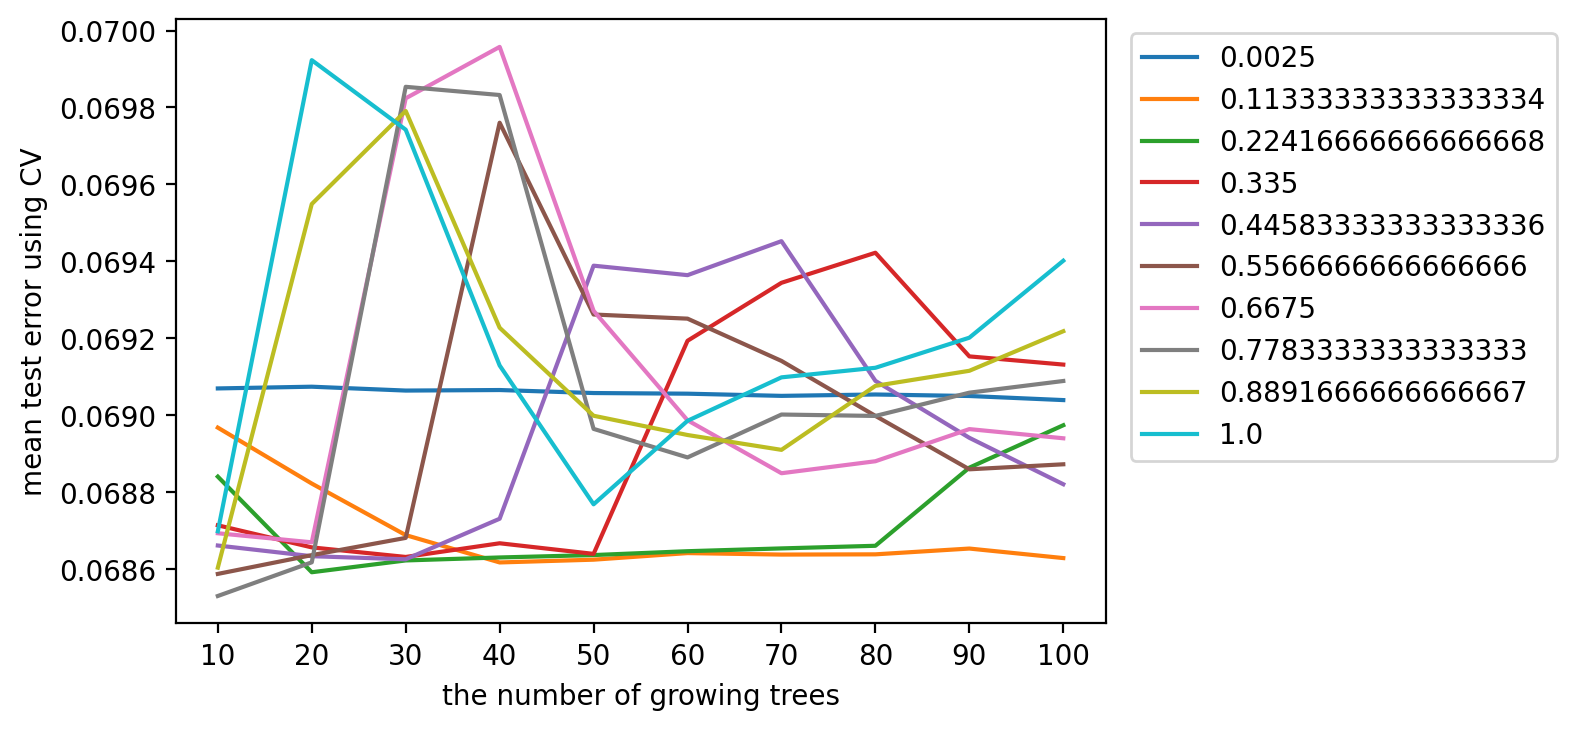

In [145]:
MSE_ada_mean = np.mean(MSE_ada, axis = 0)
plt.figure(figsize=(6, 4), dpi=200)
for i in range(10):
    plt.plot(estimators, MSE_ada_mean[:, i])
# Function add a legend  
plt.legend(learning_rates, bbox_to_anchor=(1.5,1), loc ="upper right", fontsize=10)
plt.xticks(np.arange(min(estimators), max(estimators)+10, 10.0))
plt.xlabel('the number of growing trees')
plt.ylabel('mean test error using CV')
# plt.show()

### Precise range

In [161]:
print(np.linspace(0.1, 0.30, 21))
print(np.linspace(10, 60, 51))

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3 ]
[10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.
 46. 47. 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60.]


In [162]:
# n - the number of observations; p - the number of features
[n, p] = np.shape(X_ada)

K = 10 # the number folds
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

estimators = np.linspace(10, 60, 51).astype(int)  # the number of models investigated
learning_rates = np.linspace(0.1, 0.3, 21) # the learning rates investigated
MSE_ada = np.zeros((10, 51, 21))
MSE_2d = np.zeros((51, 21))
DTR = DecisionTreeRegressor(max_depth = 1)

for i in range(1, K+1):

    # Select the train/test data in this fold
    XTrain = X_ada[i != I, :]
    yTrain = y_ada[i != I]
    XTest = X_ada[i == I, :]
    yTest = y_ada[i == I]

    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)

    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)

    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response

    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data

    for j in range(51):
        estimator = estimators[j]
        for k in range(21):
            RegModel = AdaBoostRegressor(n_estimators = estimator, base_estimator = DTR,
                                         learning_rate = learning_rates[k], loss = 'exponential')
            AB = RegModel.fit(XTrain, yTrain)
            prediction = AB.predict(XTest)
            MSE_2d[j, k] = np.mean((yTest - prediction) ** 2)
            print('fold: {} / estimator: {} / learning rate: {}'.format(i, estimators[j], learning_rates[k]))
            print(np.mean((yTest - prediction) ** 2))
        print('--------------------------------------------------------------')
    MSE_ada[i-1, :, :] = MSE_2d

fold: 1 / estimator: 10 / learning rate: 0.1
0.06975430978220491
fold: 1 / estimator: 10 / learning rate: 0.11
0.06975642886882759
fold: 1 / estimator: 10 / learning rate: 0.12
0.06972191723134516
fold: 1 / estimator: 10 / learning rate: 0.13
0.06975246273024416
fold: 1 / estimator: 10 / learning rate: 0.14
0.0697466602270825
fold: 1 / estimator: 10 / learning rate: 0.15
0.06971327632580882
fold: 1 / estimator: 10 / learning rate: 0.16
0.06970681824719752
fold: 1 / estimator: 10 / learning rate: 0.16999999999999998
0.06974409020678975
fold: 1 / estimator: 10 / learning rate: 0.18
0.06968169379561823
fold: 1 / estimator: 10 / learning rate: 0.19
0.06969302875540703
fold: 1 / estimator: 10 / learning rate: 0.19999999999999998
0.06970636040965726
fold: 1 / estimator: 10 / learning rate: 0.21
0.0696559917242859
fold: 1 / estimator: 10 / learning rate: 0.21999999999999997
0.06968192730039391
fold: 1 / estimator: 10 / learning rate: 0.22999999999999998
0.06964968430625024
fold: 1 / estimator

fold: 1 / estimator: 15 / learning rate: 0.18
0.0696449783859998
fold: 1 / estimator: 15 / learning rate: 0.19
0.06964660741372934
fold: 1 / estimator: 15 / learning rate: 0.19999999999999998
0.06950431909472958
fold: 1 / estimator: 15 / learning rate: 0.21
0.0695378648518977
fold: 1 / estimator: 15 / learning rate: 0.21999999999999997
0.06950046955776408
fold: 1 / estimator: 15 / learning rate: 0.22999999999999998
0.06951161510500142
fold: 1 / estimator: 15 / learning rate: 0.24
0.0695097787131677
fold: 1 / estimator: 15 / learning rate: 0.24999999999999997
0.0695834142546927
fold: 1 / estimator: 15 / learning rate: 0.26
0.06949785366517244
fold: 1 / estimator: 15 / learning rate: 0.27
0.06938524801121596
fold: 1 / estimator: 15 / learning rate: 0.27999999999999997
0.06951477654690057
fold: 1 / estimator: 15 / learning rate: 0.29
0.06949299939466325
fold: 1 / estimator: 15 / learning rate: 0.3
0.06935198897373371
--------------------------------------------------------------
fold: 1 /

fold: 1 / estimator: 20 / learning rate: 0.26
0.06946067089803798
fold: 1 / estimator: 20 / learning rate: 0.27
0.069495936519623
fold: 1 / estimator: 20 / learning rate: 0.27999999999999997
0.069503031948543
fold: 1 / estimator: 20 / learning rate: 0.29
0.06947952988330208
fold: 1 / estimator: 20 / learning rate: 0.3
0.06952910157093208
--------------------------------------------------------------
fold: 1 / estimator: 21 / learning rate: 0.1
0.06967135395509855
fold: 1 / estimator: 21 / learning rate: 0.11
0.06964580834887753
fold: 1 / estimator: 21 / learning rate: 0.12
0.06962193789346363
fold: 1 / estimator: 21 / learning rate: 0.13
0.06961463479554336
fold: 1 / estimator: 21 / learning rate: 0.14
0.06961921587037533
fold: 1 / estimator: 21 / learning rate: 0.15
0.06960100306850538
fold: 1 / estimator: 21 / learning rate: 0.16
0.0695231402207854
fold: 1 / estimator: 21 / learning rate: 0.16999999999999998
0.06954202018436335
fold: 1 / estimator: 21 / learning rate: 0.18
0.06956533

fold: 1 / estimator: 26 / learning rate: 0.12
0.06955268642273028
fold: 1 / estimator: 26 / learning rate: 0.13
0.06944479399637568
fold: 1 / estimator: 26 / learning rate: 0.14
0.0695470022780557
fold: 1 / estimator: 26 / learning rate: 0.15
0.06942210610578632
fold: 1 / estimator: 26 / learning rate: 0.16
0.06946664878057435
fold: 1 / estimator: 26 / learning rate: 0.16999999999999998
0.06953104331901287
fold: 1 / estimator: 26 / learning rate: 0.18
0.0694971756567018
fold: 1 / estimator: 26 / learning rate: 0.19
0.06948574890503215
fold: 1 / estimator: 26 / learning rate: 0.19999999999999998
0.06950319041506911
fold: 1 / estimator: 26 / learning rate: 0.21
0.06943958902871175
fold: 1 / estimator: 26 / learning rate: 0.21999999999999997
0.06948575793096876
fold: 1 / estimator: 26 / learning rate: 0.22999999999999998
0.06952697699497468
fold: 1 / estimator: 26 / learning rate: 0.24
0.0695045429582981
fold: 1 / estimator: 26 / learning rate: 0.24999999999999997
0.0694735501587052
fold:

fold: 1 / estimator: 31 / learning rate: 0.19999999999999998
0.0694478113418673
fold: 1 / estimator: 31 / learning rate: 0.21
0.06947912839778514
fold: 1 / estimator: 31 / learning rate: 0.21999999999999997
0.06946774124776145
fold: 1 / estimator: 31 / learning rate: 0.22999999999999998
0.06951311559632183
fold: 1 / estimator: 31 / learning rate: 0.24
0.06949739756461745
fold: 1 / estimator: 31 / learning rate: 0.24999999999999997
0.06952335010684399
fold: 1 / estimator: 31 / learning rate: 0.26
0.06951923358037021
fold: 1 / estimator: 31 / learning rate: 0.27
0.06949172283932797
fold: 1 / estimator: 31 / learning rate: 0.27999999999999997
0.0694970839176233
fold: 1 / estimator: 31 / learning rate: 0.29
0.06953083287027854
fold: 1 / estimator: 31 / learning rate: 0.3
0.06952100519444168
--------------------------------------------------------------
fold: 1 / estimator: 32 / learning rate: 0.1
0.06953321390206607
fold: 1 / estimator: 32 / learning rate: 0.11
0.06954130753714127
fold: 1 

fold: 1 / estimator: 36 / learning rate: 0.27999999999999997
0.06952862677140514
fold: 1 / estimator: 36 / learning rate: 0.29
0.069466236101893
fold: 1 / estimator: 36 / learning rate: 0.3
0.06944994588387342
--------------------------------------------------------------
fold: 1 / estimator: 37 / learning rate: 0.1
0.06948190917350054
fold: 1 / estimator: 37 / learning rate: 0.11
0.06945107982127958
fold: 1 / estimator: 37 / learning rate: 0.12
0.0694525035400938
fold: 1 / estimator: 37 / learning rate: 0.13
0.06945026256276471
fold: 1 / estimator: 37 / learning rate: 0.14
0.06948401819522237
fold: 1 / estimator: 37 / learning rate: 0.15
0.0695165226195426
fold: 1 / estimator: 37 / learning rate: 0.16
0.06945580574797885
fold: 1 / estimator: 37 / learning rate: 0.16999999999999998
0.06948744730947302
fold: 1 / estimator: 37 / learning rate: 0.18
0.06949629537846738
fold: 1 / estimator: 37 / learning rate: 0.19
0.06947822681791206
fold: 1 / estimator: 37 / learning rate: 0.199999999999

fold: 1 / estimator: 42 / learning rate: 0.14
0.06945115675120785
fold: 1 / estimator: 42 / learning rate: 0.15
0.06948532293120693
fold: 1 / estimator: 42 / learning rate: 0.16
0.06950323774663138
fold: 1 / estimator: 42 / learning rate: 0.16999999999999998
0.06953035051331058
fold: 1 / estimator: 42 / learning rate: 0.18
0.06949785798151197
fold: 1 / estimator: 42 / learning rate: 0.19
0.06956045648558891
fold: 1 / estimator: 42 / learning rate: 0.19999999999999998
0.06948358712078373
fold: 1 / estimator: 42 / learning rate: 0.21
0.06947929042466085
fold: 1 / estimator: 42 / learning rate: 0.21999999999999997
0.06947983182778046
fold: 1 / estimator: 42 / learning rate: 0.22999999999999998
0.06947234958893046
fold: 1 / estimator: 42 / learning rate: 0.24
0.06945817738438159
fold: 1 / estimator: 42 / learning rate: 0.24999999999999997
0.06948229086171337
fold: 1 / estimator: 42 / learning rate: 0.26
0.06954556337612974
fold: 1 / estimator: 42 / learning rate: 0.27
0.06954198933464598
f

fold: 1 / estimator: 47 / learning rate: 0.21999999999999997
0.06949801062223868
fold: 1 / estimator: 47 / learning rate: 0.22999999999999998
0.06946564826434136
fold: 1 / estimator: 47 / learning rate: 0.24
0.06948607003570796
fold: 1 / estimator: 47 / learning rate: 0.24999999999999997
0.06948398935182216
fold: 1 / estimator: 47 / learning rate: 0.26
0.06956190243831346
fold: 1 / estimator: 47 / learning rate: 0.27
0.06944241837342317
fold: 1 / estimator: 47 / learning rate: 0.27999999999999997
0.0694920285034068
fold: 1 / estimator: 47 / learning rate: 0.29
0.0694874621176733
fold: 1 / estimator: 47 / learning rate: 0.3
0.06948688617758457
--------------------------------------------------------------
fold: 1 / estimator: 48 / learning rate: 0.1
0.0694752852450103
fold: 1 / estimator: 48 / learning rate: 0.11
0.06949698989642666
fold: 1 / estimator: 48 / learning rate: 0.12
0.06951118106400268
fold: 1 / estimator: 48 / learning rate: 0.13
0.06948031980369153
fold: 1 / estimator: 48 

fold: 1 / estimator: 52 / learning rate: 0.29
0.06953454659024622
fold: 1 / estimator: 52 / learning rate: 0.3
0.06954291100383035
--------------------------------------------------------------
fold: 1 / estimator: 53 / learning rate: 0.1
0.06947982409176913
fold: 1 / estimator: 53 / learning rate: 0.11
0.06944380980569034
fold: 1 / estimator: 53 / learning rate: 0.12
0.06949299151709663
fold: 1 / estimator: 53 / learning rate: 0.13
0.06953579933310695
fold: 1 / estimator: 53 / learning rate: 0.14
0.06944916723924169
fold: 1 / estimator: 53 / learning rate: 0.15
0.06947588351715114
fold: 1 / estimator: 53 / learning rate: 0.16
0.06953135534184295
fold: 1 / estimator: 53 / learning rate: 0.16999999999999998
0.06947114399429152
fold: 1 / estimator: 53 / learning rate: 0.18
0.06948023875476513
fold: 1 / estimator: 53 / learning rate: 0.19
0.06945131844739968
fold: 1 / estimator: 53 / learning rate: 0.19999999999999998
0.06950226584076474
fold: 1 / estimator: 53 / learning rate: 0.21
0.069

fold: 1 / estimator: 58 / learning rate: 0.15
0.06945781551526242
fold: 1 / estimator: 58 / learning rate: 0.16
0.06947008404459813
fold: 1 / estimator: 58 / learning rate: 0.16999999999999998
0.06950904506480958
fold: 1 / estimator: 58 / learning rate: 0.18
0.0695518346895653
fold: 1 / estimator: 58 / learning rate: 0.19
0.06953192525323959
fold: 1 / estimator: 58 / learning rate: 0.19999999999999998
0.0694798710289016
fold: 1 / estimator: 58 / learning rate: 0.21
0.0694855111096247
fold: 1 / estimator: 58 / learning rate: 0.21999999999999997
0.06958412821621354
fold: 1 / estimator: 58 / learning rate: 0.22999999999999998
0.0695309927362164
fold: 1 / estimator: 58 / learning rate: 0.24
0.06947100213469466
fold: 1 / estimator: 58 / learning rate: 0.24999999999999997
0.0695361063401414
fold: 1 / estimator: 58 / learning rate: 0.26
0.06946153720015727
fold: 1 / estimator: 58 / learning rate: 0.27
0.06953222205888217
fold: 1 / estimator: 58 / learning rate: 0.27999999999999997
0.069485975

fold: 2 / estimator: 12 / learning rate: 0.22999999999999998
0.06871924037676208
fold: 2 / estimator: 12 / learning rate: 0.24
0.06869307992711991
fold: 2 / estimator: 12 / learning rate: 0.24999999999999997
0.0687647044673035
fold: 2 / estimator: 12 / learning rate: 0.26
0.06870333414423664
fold: 2 / estimator: 12 / learning rate: 0.27
0.06860276273907295
fold: 2 / estimator: 12 / learning rate: 0.27999999999999997
0.06856811046030617
fold: 2 / estimator: 12 / learning rate: 0.29
0.06865098197441595
fold: 2 / estimator: 12 / learning rate: 0.3
0.06871464022412979
--------------------------------------------------------------
fold: 2 / estimator: 13 / learning rate: 0.1
0.0688647313944106
fold: 2 / estimator: 13 / learning rate: 0.11
0.0688424673924088
fold: 2 / estimator: 13 / learning rate: 0.12
0.06885519604556742
fold: 2 / estimator: 13 / learning rate: 0.13
0.06886269470671116
fold: 2 / estimator: 13 / learning rate: 0.14
0.0688360160149083
fold: 2 / estimator: 13 / learning rate:

fold: 2 / estimator: 18 / learning rate: 0.1
0.06882625744175855
fold: 2 / estimator: 18 / learning rate: 0.11
0.06876613534423343
fold: 2 / estimator: 18 / learning rate: 0.12
0.06878237868174804
fold: 2 / estimator: 18 / learning rate: 0.13
0.06880348123301928
fold: 2 / estimator: 18 / learning rate: 0.14
0.06878546662294129
fold: 2 / estimator: 18 / learning rate: 0.15
0.06874747076520558
fold: 2 / estimator: 18 / learning rate: 0.16
0.06877968881311361
fold: 2 / estimator: 18 / learning rate: 0.16999999999999998
0.06868459343968703
fold: 2 / estimator: 18 / learning rate: 0.18
0.06866723493692475
fold: 2 / estimator: 18 / learning rate: 0.19
0.06866891959879172
fold: 2 / estimator: 18 / learning rate: 0.19999999999999998
0.06858147135943903
fold: 2 / estimator: 18 / learning rate: 0.21
0.06864734891121539
fold: 2 / estimator: 18 / learning rate: 0.21999999999999997
0.06862016897364472
fold: 2 / estimator: 18 / learning rate: 0.22999999999999998
0.06863138447087849
fold: 2 / estimat

fold: 2 / estimator: 23 / learning rate: 0.18
0.06861897588966949
fold: 2 / estimator: 23 / learning rate: 0.19
0.06854924474135873
fold: 2 / estimator: 23 / learning rate: 0.19999999999999998
0.06858266203138952
fold: 2 / estimator: 23 / learning rate: 0.21
0.06866193775675737
fold: 2 / estimator: 23 / learning rate: 0.21999999999999997
0.06859359839338512
fold: 2 / estimator: 23 / learning rate: 0.22999999999999998
0.06866702450833205
fold: 2 / estimator: 23 / learning rate: 0.24
0.06869510312793418
fold: 2 / estimator: 23 / learning rate: 0.24999999999999997
0.06864704322831494
fold: 2 / estimator: 23 / learning rate: 0.26
0.06867105138171829
fold: 2 / estimator: 23 / learning rate: 0.27
0.06859232277398415
fold: 2 / estimator: 23 / learning rate: 0.27999999999999997
0.06862174283080466
fold: 2 / estimator: 23 / learning rate: 0.29
0.0686702496548019
fold: 2 / estimator: 23 / learning rate: 0.3
0.0686089665519888
--------------------------------------------------------------
fold: 2

fold: 2 / estimator: 28 / learning rate: 0.26
0.06870294932595582
fold: 2 / estimator: 28 / learning rate: 0.27
0.06869741883531211
fold: 2 / estimator: 28 / learning rate: 0.27999999999999997
0.0686687943126209
fold: 2 / estimator: 28 / learning rate: 0.29
0.06875060983000059
fold: 2 / estimator: 28 / learning rate: 0.3
0.06864412001937739
--------------------------------------------------------------
fold: 2 / estimator: 29 / learning rate: 0.1
0.0687126245613123
fold: 2 / estimator: 29 / learning rate: 0.11
0.0686620970842716
fold: 2 / estimator: 29 / learning rate: 0.12
0.06868289659578025
fold: 2 / estimator: 29 / learning rate: 0.13
0.06856323641957157
fold: 2 / estimator: 29 / learning rate: 0.14
0.06859755217099439
fold: 2 / estimator: 29 / learning rate: 0.15
0.06855281257710612
fold: 2 / estimator: 29 / learning rate: 0.16
0.06855776711538421
fold: 2 / estimator: 29 / learning rate: 0.16999999999999998
0.0686010665976046
fold: 2 / estimator: 29 / learning rate: 0.18
0.0685594

fold: 2 / estimator: 34 / learning rate: 0.12
0.06861892135475596
fold: 2 / estimator: 34 / learning rate: 0.13
0.06857989939793395
fold: 2 / estimator: 34 / learning rate: 0.14
0.06852445363207316
fold: 2 / estimator: 34 / learning rate: 0.15
0.06861169926450285
fold: 2 / estimator: 34 / learning rate: 0.16
0.06860487967464303
fold: 2 / estimator: 34 / learning rate: 0.16999999999999998
0.06855368566620218
fold: 2 / estimator: 34 / learning rate: 0.18
0.06863440790740706
fold: 2 / estimator: 34 / learning rate: 0.19
0.0686400983478925
fold: 2 / estimator: 34 / learning rate: 0.19999999999999998
0.06862939091238152
fold: 2 / estimator: 34 / learning rate: 0.21
0.06861856466052609
fold: 2 / estimator: 34 / learning rate: 0.21999999999999997
0.0686817782975272
fold: 2 / estimator: 34 / learning rate: 0.22999999999999998
0.06869881305655942
fold: 2 / estimator: 34 / learning rate: 0.24
0.06860244550206529
fold: 2 / estimator: 34 / learning rate: 0.24999999999999997
0.0686459529713882
fold

fold: 2 / estimator: 39 / learning rate: 0.19999999999999998
0.06860056732617027
fold: 2 / estimator: 39 / learning rate: 0.21
0.06866163026567272
fold: 2 / estimator: 39 / learning rate: 0.21999999999999997
0.06865849966124926
fold: 2 / estimator: 39 / learning rate: 0.22999999999999998
0.0686648540790811
fold: 2 / estimator: 39 / learning rate: 0.24
0.06868377336425857
fold: 2 / estimator: 39 / learning rate: 0.24999999999999997
0.06864935040759597
fold: 2 / estimator: 39 / learning rate: 0.26
0.06856608903139708
fold: 2 / estimator: 39 / learning rate: 0.27
0.06868418332861304
fold: 2 / estimator: 39 / learning rate: 0.27999999999999997
0.06862844927556166
fold: 2 / estimator: 39 / learning rate: 0.29
0.06872929656900155
fold: 2 / estimator: 39 / learning rate: 0.3
0.06862341167552877
--------------------------------------------------------------
fold: 2 / estimator: 40 / learning rate: 0.1
0.06870470228965868
fold: 2 / estimator: 40 / learning rate: 0.11
0.06860791144191677
fold: 2

fold: 2 / estimator: 44 / learning rate: 0.27999999999999997
0.06871702181135764
fold: 2 / estimator: 44 / learning rate: 0.29
0.06862099824528088
fold: 2 / estimator: 44 / learning rate: 0.3
0.06869401012412679
--------------------------------------------------------------
fold: 2 / estimator: 45 / learning rate: 0.1
0.06852854896740453
fold: 2 / estimator: 45 / learning rate: 0.11
0.06864419080714859
fold: 2 / estimator: 45 / learning rate: 0.12
0.06864464372945027
fold: 2 / estimator: 45 / learning rate: 0.13
0.06870493942090866
fold: 2 / estimator: 45 / learning rate: 0.14
0.06865312517542584
fold: 2 / estimator: 45 / learning rate: 0.15
0.06873774578810632
fold: 2 / estimator: 45 / learning rate: 0.16
0.06868189897063824
fold: 2 / estimator: 45 / learning rate: 0.16999999999999998
0.0686454411440365
fold: 2 / estimator: 45 / learning rate: 0.18
0.06866765281048544
fold: 2 / estimator: 45 / learning rate: 0.19
0.06862189691709844
fold: 2 / estimator: 45 / learning rate: 0.199999999

fold: 2 / estimator: 50 / learning rate: 0.14
0.06869537944790285
fold: 2 / estimator: 50 / learning rate: 0.15
0.06865896834323669
fold: 2 / estimator: 50 / learning rate: 0.16
0.06861505808599533
fold: 2 / estimator: 50 / learning rate: 0.16999999999999998
0.06865157904872843
fold: 2 / estimator: 50 / learning rate: 0.18
0.06874356617104134
fold: 2 / estimator: 50 / learning rate: 0.19
0.06867005573005913
fold: 2 / estimator: 50 / learning rate: 0.19999999999999998
0.06861153754549548
fold: 2 / estimator: 50 / learning rate: 0.21
0.0686565153110785
fold: 2 / estimator: 50 / learning rate: 0.21999999999999997
0.06857670769894625
fold: 2 / estimator: 50 / learning rate: 0.22999999999999998
0.06862730671742741
fold: 2 / estimator: 50 / learning rate: 0.24
0.06868147120926309
fold: 2 / estimator: 50 / learning rate: 0.24999999999999997
0.06878779706014936
fold: 2 / estimator: 50 / learning rate: 0.26
0.06869502435014414
fold: 2 / estimator: 50 / learning rate: 0.27
0.06863307859873014
fo

fold: 2 / estimator: 55 / learning rate: 0.21999999999999997
0.06867650506029224
fold: 2 / estimator: 55 / learning rate: 0.22999999999999998
0.06866911423386061
fold: 2 / estimator: 55 / learning rate: 0.24
0.06869051024226318
fold: 2 / estimator: 55 / learning rate: 0.24999999999999997
0.06861242041529089
fold: 2 / estimator: 55 / learning rate: 0.26
0.06862993549184972
fold: 2 / estimator: 55 / learning rate: 0.27
0.06863566494927115
fold: 2 / estimator: 55 / learning rate: 0.27999999999999997
0.06863752630664327
fold: 2 / estimator: 55 / learning rate: 0.29
0.06877385851157004
fold: 2 / estimator: 55 / learning rate: 0.3
0.0686944646760024
--------------------------------------------------------------
fold: 2 / estimator: 56 / learning rate: 0.1
0.06870214779262711
fold: 2 / estimator: 56 / learning rate: 0.11
0.06865579774279058
fold: 2 / estimator: 56 / learning rate: 0.12
0.06860117072076018
fold: 2 / estimator: 56 / learning rate: 0.13
0.06860865057293238
fold: 2 / estimator: 5

fold: 2 / estimator: 60 / learning rate: 0.3
0.06866705215329613
--------------------------------------------------------------
fold: 3 / estimator: 10 / learning rate: 0.1
0.07062054960537954
fold: 3 / estimator: 10 / learning rate: 0.11
0.07066230366066799
fold: 3 / estimator: 10 / learning rate: 0.12
0.07062272761628699
fold: 3 / estimator: 10 / learning rate: 0.13
0.07067050609500213
fold: 3 / estimator: 10 / learning rate: 0.14
0.07059993116163933
fold: 3 / estimator: 10 / learning rate: 0.15
0.07060562347963412
fold: 3 / estimator: 10 / learning rate: 0.16
0.07060396519137084
fold: 3 / estimator: 10 / learning rate: 0.16999999999999998
0.07062284198636021
fold: 3 / estimator: 10 / learning rate: 0.18
0.07054217044947296
fold: 3 / estimator: 10 / learning rate: 0.19
0.07061966710394983
fold: 3 / estimator: 10 / learning rate: 0.19999999999999998
0.0705497973422835
fold: 3 / estimator: 10 / learning rate: 0.21
0.07049059199016473
fold: 3 / estimator: 10 / learning rate: 0.219999999

fold: 3 / estimator: 15 / learning rate: 0.16
0.07046285057048801
fold: 3 / estimator: 15 / learning rate: 0.16999999999999998
0.07054003703894812
fold: 3 / estimator: 15 / learning rate: 0.18
0.07050554428834391
fold: 3 / estimator: 15 / learning rate: 0.19
0.07047936413004824
fold: 3 / estimator: 15 / learning rate: 0.19999999999999998
0.07044065931444643
fold: 3 / estimator: 15 / learning rate: 0.21
0.07040829476977682
fold: 3 / estimator: 15 / learning rate: 0.21999999999999997
0.07041262816919337
fold: 3 / estimator: 15 / learning rate: 0.22999999999999998
0.07034643992254458
fold: 3 / estimator: 15 / learning rate: 0.24
0.07044254754119929
fold: 3 / estimator: 15 / learning rate: 0.24999999999999997
0.07042075958424834
fold: 3 / estimator: 15 / learning rate: 0.26
0.07041143575412646
fold: 3 / estimator: 15 / learning rate: 0.27
0.07040233243866262
fold: 3 / estimator: 15 / learning rate: 0.27999999999999997
0.07039902178512725
fold: 3 / estimator: 15 / learning rate: 0.29
0.0703

fold: 3 / estimator: 20 / learning rate: 0.24
0.07032375267610451
fold: 3 / estimator: 20 / learning rate: 0.24999999999999997
0.07033227603637045
fold: 3 / estimator: 20 / learning rate: 0.26
0.07028993580582954
fold: 3 / estimator: 20 / learning rate: 0.27
0.0703612228149134
fold: 3 / estimator: 20 / learning rate: 0.27999999999999997
0.07034558770759415
fold: 3 / estimator: 20 / learning rate: 0.29
0.07031504574739834
fold: 3 / estimator: 20 / learning rate: 0.3
0.07035066145581946
--------------------------------------------------------------
fold: 3 / estimator: 21 / learning rate: 0.1
0.07055090849884467
fold: 3 / estimator: 21 / learning rate: 0.11
0.07051728504374898
fold: 3 / estimator: 21 / learning rate: 0.12
0.07052489342430268
fold: 3 / estimator: 21 / learning rate: 0.13
0.07047725233381855
fold: 3 / estimator: 21 / learning rate: 0.14
0.07046410935362855
fold: 3 / estimator: 21 / learning rate: 0.15
0.07039205162044296
fold: 3 / estimator: 21 / learning rate: 0.16
0.0703

fold: 3 / estimator: 26 / learning rate: 0.1
0.0704621320977419
fold: 3 / estimator: 26 / learning rate: 0.11
0.07048338014972949
fold: 3 / estimator: 26 / learning rate: 0.12
0.07040260337437541
fold: 3 / estimator: 26 / learning rate: 0.13
0.07039163137474735
fold: 3 / estimator: 26 / learning rate: 0.14
0.07036107909706964
fold: 3 / estimator: 26 / learning rate: 0.15
0.07036023709996764
fold: 3 / estimator: 26 / learning rate: 0.16
0.070305189086159
fold: 3 / estimator: 26 / learning rate: 0.16999999999999998
0.0703039034459983
fold: 3 / estimator: 26 / learning rate: 0.18
0.0703081501186445
fold: 3 / estimator: 26 / learning rate: 0.19
0.07028552059417416
fold: 3 / estimator: 26 / learning rate: 0.19999999999999998
0.07026485594407429
fold: 3 / estimator: 26 / learning rate: 0.21
0.07023465865189056
fold: 3 / estimator: 26 / learning rate: 0.21999999999999997
0.07033368052759484
fold: 3 / estimator: 26 / learning rate: 0.22999999999999998
0.07029065896659048
fold: 3 / estimator: 2

fold: 3 / estimator: 31 / learning rate: 0.18
0.07028137156249782
fold: 3 / estimator: 31 / learning rate: 0.19
0.07030495169924046
fold: 3 / estimator: 31 / learning rate: 0.19999999999999998
0.07035530683827165
fold: 3 / estimator: 31 / learning rate: 0.21
0.07032283315894527
fold: 3 / estimator: 31 / learning rate: 0.21999999999999997
0.07027607871198062
fold: 3 / estimator: 31 / learning rate: 0.22999999999999998
0.0703516392867827
fold: 3 / estimator: 31 / learning rate: 0.24
0.07035480733836966
fold: 3 / estimator: 31 / learning rate: 0.24999999999999997
0.07031191460981137
fold: 3 / estimator: 31 / learning rate: 0.26
0.07028423795829283
fold: 3 / estimator: 31 / learning rate: 0.27
0.0703453493515327
fold: 3 / estimator: 31 / learning rate: 0.27999999999999997
0.07022582179852932
fold: 3 / estimator: 31 / learning rate: 0.29
0.07040271507074941
fold: 3 / estimator: 31 / learning rate: 0.3
0.07036559195062432
--------------------------------------------------------------
fold: 3

fold: 3 / estimator: 36 / learning rate: 0.26
0.07031922172338263
fold: 3 / estimator: 36 / learning rate: 0.27
0.07030779602059352
fold: 3 / estimator: 36 / learning rate: 0.27999999999999997
0.07032696381554808
fold: 3 / estimator: 36 / learning rate: 0.29
0.0703335951457326
fold: 3 / estimator: 36 / learning rate: 0.3
0.07034192981686395
--------------------------------------------------------------
fold: 3 / estimator: 37 / learning rate: 0.1
0.07034308395868755
fold: 3 / estimator: 37 / learning rate: 0.11
0.07028261568942308
fold: 3 / estimator: 37 / learning rate: 0.12
0.0703055519832259
fold: 3 / estimator: 37 / learning rate: 0.13
0.07035928090524268
fold: 3 / estimator: 37 / learning rate: 0.14
0.07034266135879677
fold: 3 / estimator: 37 / learning rate: 0.15
0.07033237783084612
fold: 3 / estimator: 37 / learning rate: 0.16
0.07026697776629583
fold: 3 / estimator: 37 / learning rate: 0.16999999999999998
0.07037557828843834
fold: 3 / estimator: 37 / learning rate: 0.18
0.07034

fold: 3 / estimator: 42 / learning rate: 0.12
0.07031723331161302
fold: 3 / estimator: 42 / learning rate: 0.13
0.07033656355780571
fold: 3 / estimator: 42 / learning rate: 0.14
0.07024279625616975
fold: 3 / estimator: 42 / learning rate: 0.15
0.07032107106831698
fold: 3 / estimator: 42 / learning rate: 0.16
0.07031730714564041
fold: 3 / estimator: 42 / learning rate: 0.16999999999999998
0.07030526315229625
fold: 3 / estimator: 42 / learning rate: 0.18
0.0703229907379437
fold: 3 / estimator: 42 / learning rate: 0.19
0.07033425291277008
fold: 3 / estimator: 42 / learning rate: 0.19999999999999998
0.07033086695885726
fold: 3 / estimator: 42 / learning rate: 0.21
0.07029847761449996
fold: 3 / estimator: 42 / learning rate: 0.21999999999999997
0.07037175795408604
fold: 3 / estimator: 42 / learning rate: 0.22999999999999998
0.07034246274230778
fold: 3 / estimator: 42 / learning rate: 0.24
0.07036608996204848
fold: 3 / estimator: 42 / learning rate: 0.24999999999999997
0.07029633683084545
fo

fold: 3 / estimator: 47 / learning rate: 0.19999999999999998
0.07033156131836046
fold: 3 / estimator: 47 / learning rate: 0.21
0.07032834882832534
fold: 3 / estimator: 47 / learning rate: 0.21999999999999997
0.07040000213120198
fold: 3 / estimator: 47 / learning rate: 0.22999999999999998
0.07031355843384912
fold: 3 / estimator: 47 / learning rate: 0.24
0.070340433886863
fold: 3 / estimator: 47 / learning rate: 0.24999999999999997
0.07028302776548079
fold: 3 / estimator: 47 / learning rate: 0.26
0.07028920470038452
fold: 3 / estimator: 47 / learning rate: 0.27
0.07036083254621447
fold: 3 / estimator: 47 / learning rate: 0.27999999999999997
0.0703354637406707
fold: 3 / estimator: 47 / learning rate: 0.29
0.07033642041238392
fold: 3 / estimator: 47 / learning rate: 0.3
0.07033620942158796
--------------------------------------------------------------
fold: 3 / estimator: 48 / learning rate: 0.1
0.07033213544262822
fold: 3 / estimator: 48 / learning rate: 0.11
0.07028048327650291
fold: 3 /

fold: 3 / estimator: 52 / learning rate: 0.27999999999999997
0.07036627523881253
fold: 3 / estimator: 52 / learning rate: 0.29
0.0703853695828106
fold: 3 / estimator: 52 / learning rate: 0.3
0.07031302848647072
--------------------------------------------------------------
fold: 3 / estimator: 53 / learning rate: 0.1
0.07031606245063948
fold: 3 / estimator: 53 / learning rate: 0.11
0.07033052943415412
fold: 3 / estimator: 53 / learning rate: 0.12
0.07030017159254266
fold: 3 / estimator: 53 / learning rate: 0.13
0.0703025395774552
fold: 3 / estimator: 53 / learning rate: 0.14
0.07031268324315379
fold: 3 / estimator: 53 / learning rate: 0.15
0.0703505658361622
fold: 3 / estimator: 53 / learning rate: 0.16
0.07033905732053926
fold: 3 / estimator: 53 / learning rate: 0.16999999999999998
0.07032323926226386
fold: 3 / estimator: 53 / learning rate: 0.18
0.07032999480305677
fold: 3 / estimator: 53 / learning rate: 0.19
0.07034883571285046
fold: 3 / estimator: 53 / learning rate: 0.19999999999

fold: 3 / estimator: 58 / learning rate: 0.14
0.07035665422430198
fold: 3 / estimator: 58 / learning rate: 0.15
0.07035961941320308
fold: 3 / estimator: 58 / learning rate: 0.16
0.07039196605858536
fold: 3 / estimator: 58 / learning rate: 0.16999999999999998
0.07027926745595246
fold: 3 / estimator: 58 / learning rate: 0.18
0.07033425242670269
fold: 3 / estimator: 58 / learning rate: 0.19
0.07037211183710608
fold: 3 / estimator: 58 / learning rate: 0.19999999999999998
0.0703177077013969
fold: 3 / estimator: 58 / learning rate: 0.21
0.0703127068162356
fold: 3 / estimator: 58 / learning rate: 0.21999999999999997
0.07035764977102218
fold: 3 / estimator: 58 / learning rate: 0.22999999999999998
0.07031443035928651
fold: 3 / estimator: 58 / learning rate: 0.24
0.07028488401653751
fold: 3 / estimator: 58 / learning rate: 0.24999999999999997
0.07031864315604094
fold: 3 / estimator: 58 / learning rate: 0.26
0.07036983969570214
fold: 3 / estimator: 58 / learning rate: 0.27
0.07030479222115654
fol

fold: 4 / estimator: 12 / learning rate: 0.21999999999999997
0.06944920366971466
fold: 4 / estimator: 12 / learning rate: 0.22999999999999998
0.06946404312064543
fold: 4 / estimator: 12 / learning rate: 0.24
0.06950594902356778
fold: 4 / estimator: 12 / learning rate: 0.24999999999999997
0.0694351258434272
fold: 4 / estimator: 12 / learning rate: 0.26
0.06942613604110158
fold: 4 / estimator: 12 / learning rate: 0.27
0.06938944102197755
fold: 4 / estimator: 12 / learning rate: 0.27999999999999997
0.06940845534003925
fold: 4 / estimator: 12 / learning rate: 0.29
0.06925716218860067
fold: 4 / estimator: 12 / learning rate: 0.3
0.06936343531967483
--------------------------------------------------------------
fold: 4 / estimator: 13 / learning rate: 0.1
0.06962014480274223
fold: 4 / estimator: 13 / learning rate: 0.11
0.06956115429201275
fold: 4 / estimator: 13 / learning rate: 0.12
0.06959107364421027
fold: 4 / estimator: 13 / learning rate: 0.13
0.06956135838532922
fold: 4 / estimator: 1

fold: 4 / estimator: 17 / learning rate: 0.3
0.06929708000125548
--------------------------------------------------------------
fold: 4 / estimator: 18 / learning rate: 0.1
0.06954693133830946
fold: 4 / estimator: 18 / learning rate: 0.11
0.06957301232272943
fold: 4 / estimator: 18 / learning rate: 0.12
0.06952394310828705
fold: 4 / estimator: 18 / learning rate: 0.13
0.06952599733936288
fold: 4 / estimator: 18 / learning rate: 0.14
0.06940961415380803
fold: 4 / estimator: 18 / learning rate: 0.15
0.06947148017905252
fold: 4 / estimator: 18 / learning rate: 0.16
0.06940219652943987
fold: 4 / estimator: 18 / learning rate: 0.16999999999999998
0.06932999704138137
fold: 4 / estimator: 18 / learning rate: 0.18
0.06939156678500738
fold: 4 / estimator: 18 / learning rate: 0.19
0.06942884278704833
fold: 4 / estimator: 18 / learning rate: 0.19999999999999998
0.06940308733068036
fold: 4 / estimator: 18 / learning rate: 0.21
0.06934125349590636
fold: 4 / estimator: 18 / learning rate: 0.21999999

fold: 4 / estimator: 23 / learning rate: 0.16
0.06938288890762868
fold: 4 / estimator: 23 / learning rate: 0.16999999999999998
0.06928606717576324
fold: 4 / estimator: 23 / learning rate: 0.18
0.06935130585804515
fold: 4 / estimator: 23 / learning rate: 0.19
0.06933565611591175
fold: 4 / estimator: 23 / learning rate: 0.19999999999999998
0.0692773014073054
fold: 4 / estimator: 23 / learning rate: 0.21
0.06935802041382565
fold: 4 / estimator: 23 / learning rate: 0.21999999999999997
0.06936826016194124
fold: 4 / estimator: 23 / learning rate: 0.22999999999999998
0.06934641982046154
fold: 4 / estimator: 23 / learning rate: 0.24
0.06929360926038737
fold: 4 / estimator: 23 / learning rate: 0.24999999999999997
0.06935010305891821
fold: 4 / estimator: 23 / learning rate: 0.26
0.0693548481182599
fold: 4 / estimator: 23 / learning rate: 0.27
0.06930345543145498
fold: 4 / estimator: 23 / learning rate: 0.27999999999999997
0.06931789861806884
fold: 4 / estimator: 23 / learning rate: 0.29
0.069333

fold: 4 / estimator: 28 / learning rate: 0.24
0.06933785194839888
fold: 4 / estimator: 28 / learning rate: 0.24999999999999997
0.0693286955978785
fold: 4 / estimator: 28 / learning rate: 0.26
0.06930916680267357
fold: 4 / estimator: 28 / learning rate: 0.27
0.06938352441303307
fold: 4 / estimator: 28 / learning rate: 0.27999999999999997
0.06929076463028332
fold: 4 / estimator: 28 / learning rate: 0.29
0.06932432693932455
fold: 4 / estimator: 28 / learning rate: 0.3
0.06932178340360083
--------------------------------------------------------------
fold: 4 / estimator: 29 / learning rate: 0.1
0.06942989816550245
fold: 4 / estimator: 29 / learning rate: 0.11
0.06938284201515914
fold: 4 / estimator: 29 / learning rate: 0.12
0.06930776616026173
fold: 4 / estimator: 29 / learning rate: 0.13
0.0693791344615491
fold: 4 / estimator: 29 / learning rate: 0.14
0.06940925723319397
fold: 4 / estimator: 29 / learning rate: 0.15
0.06924243559359707
fold: 4 / estimator: 29 / learning rate: 0.16
0.06930

fold: 4 / estimator: 34 / learning rate: 0.1
0.0693634362660801
fold: 4 / estimator: 34 / learning rate: 0.11
0.0693242088178054
fold: 4 / estimator: 34 / learning rate: 0.12
0.06935487713189176
fold: 4 / estimator: 34 / learning rate: 0.13
0.06932472989919755
fold: 4 / estimator: 34 / learning rate: 0.14
0.06924934533699136
fold: 4 / estimator: 34 / learning rate: 0.15
0.06929114061041171
fold: 4 / estimator: 34 / learning rate: 0.16
0.06932210596764575
fold: 4 / estimator: 34 / learning rate: 0.16999999999999998
0.06932049363679288
fold: 4 / estimator: 34 / learning rate: 0.18
0.06931249388757314
fold: 4 / estimator: 34 / learning rate: 0.19
0.06935815417654995
fold: 4 / estimator: 34 / learning rate: 0.19999999999999998
0.06933386634243384
fold: 4 / estimator: 34 / learning rate: 0.21
0.0692755324440517
fold: 4 / estimator: 34 / learning rate: 0.21999999999999997
0.06936123670949064
fold: 4 / estimator: 34 / learning rate: 0.22999999999999998
0.06929395824480884
fold: 4 / estimator:

fold: 4 / estimator: 39 / learning rate: 0.18
0.06929480480394473
fold: 4 / estimator: 39 / learning rate: 0.19
0.06932385551173703
fold: 4 / estimator: 39 / learning rate: 0.19999999999999998
0.06936378391720328
fold: 4 / estimator: 39 / learning rate: 0.21
0.06933661965391871
fold: 4 / estimator: 39 / learning rate: 0.21999999999999997
0.06934712596383173
fold: 4 / estimator: 39 / learning rate: 0.22999999999999998
0.06930348770247101
fold: 4 / estimator: 39 / learning rate: 0.24
0.06931216021762526
fold: 4 / estimator: 39 / learning rate: 0.24999999999999997
0.06936574242013237
fold: 4 / estimator: 39 / learning rate: 0.26
0.06931519784275095
fold: 4 / estimator: 39 / learning rate: 0.27
0.06937438493456181
fold: 4 / estimator: 39 / learning rate: 0.27999999999999997
0.06926525176915972
fold: 4 / estimator: 39 / learning rate: 0.29
0.06928214371630576
fold: 4 / estimator: 39 / learning rate: 0.3
0.06935631844613326
--------------------------------------------------------------
fold:

fold: 4 / estimator: 44 / learning rate: 0.26
0.06938343680306318
fold: 4 / estimator: 44 / learning rate: 0.27
0.06926571659525903
fold: 4 / estimator: 44 / learning rate: 0.27999999999999997
0.06932700562020651
fold: 4 / estimator: 44 / learning rate: 0.29
0.06940656003589953
fold: 4 / estimator: 44 / learning rate: 0.3
0.06931051684613017
--------------------------------------------------------------
fold: 4 / estimator: 45 / learning rate: 0.1
0.06930716499194323
fold: 4 / estimator: 45 / learning rate: 0.11
0.06930481721872478
fold: 4 / estimator: 45 / learning rate: 0.12
0.06930506760107438
fold: 4 / estimator: 45 / learning rate: 0.13
0.06931357959053902
fold: 4 / estimator: 45 / learning rate: 0.14
0.06932526588738762
fold: 4 / estimator: 45 / learning rate: 0.15
0.06934163127883575
fold: 4 / estimator: 45 / learning rate: 0.16
0.06933071000735896
fold: 4 / estimator: 45 / learning rate: 0.16999999999999998
0.06931923321257104
fold: 4 / estimator: 45 / learning rate: 0.18
0.069

fold: 4 / estimator: 50 / learning rate: 0.12
0.06930072546913453
fold: 4 / estimator: 50 / learning rate: 0.13
0.06933932215154764
fold: 4 / estimator: 50 / learning rate: 0.14
0.06933232292988041
fold: 4 / estimator: 50 / learning rate: 0.15
0.0693445232692444
fold: 4 / estimator: 50 / learning rate: 0.16
0.06936228026238309
fold: 4 / estimator: 50 / learning rate: 0.16999999999999998
0.06932377615230312
fold: 4 / estimator: 50 / learning rate: 0.18
0.06932257867922526
fold: 4 / estimator: 50 / learning rate: 0.19
0.06935256592308486
fold: 4 / estimator: 50 / learning rate: 0.19999999999999998
0.06935020193270165
fold: 4 / estimator: 50 / learning rate: 0.21
0.06935314084670183
fold: 4 / estimator: 50 / learning rate: 0.21999999999999997
0.06937688265018765
fold: 4 / estimator: 50 / learning rate: 0.22999999999999998
0.0693885217055854
fold: 4 / estimator: 50 / learning rate: 0.24
0.06937747687684072
fold: 4 / estimator: 50 / learning rate: 0.24999999999999997
0.06942893193624582
fol

fold: 4 / estimator: 55 / learning rate: 0.19999999999999998
0.06931652620491421
fold: 4 / estimator: 55 / learning rate: 0.21
0.06935533095882988
fold: 4 / estimator: 55 / learning rate: 0.21999999999999997
0.06935750105340455
fold: 4 / estimator: 55 / learning rate: 0.22999999999999998
0.06928874663779813
fold: 4 / estimator: 55 / learning rate: 0.24
0.06931270570415941
fold: 4 / estimator: 55 / learning rate: 0.24999999999999997
0.0693561384663861
fold: 4 / estimator: 55 / learning rate: 0.26
0.06931918968437459
fold: 4 / estimator: 55 / learning rate: 0.27
0.06934470584426991
fold: 4 / estimator: 55 / learning rate: 0.27999999999999997
0.06925993486056337
fold: 4 / estimator: 55 / learning rate: 0.29
0.06936362492009716
fold: 4 / estimator: 55 / learning rate: 0.3
0.06932296560799371
--------------------------------------------------------------
fold: 4 / estimator: 56 / learning rate: 0.1
0.06932662316688301
fold: 4 / estimator: 56 / learning rate: 0.11
0.069345942404601
fold: 4 /

fold: 4 / estimator: 60 / learning rate: 0.27999999999999997
0.06933070470299893
fold: 4 / estimator: 60 / learning rate: 0.29
0.06932499771249773
fold: 4 / estimator: 60 / learning rate: 0.3
0.06933979664749372
--------------------------------------------------------------
fold: 5 / estimator: 10 / learning rate: 0.1
0.06761060413608544
fold: 5 / estimator: 10 / learning rate: 0.11
0.06762517106556068
fold: 5 / estimator: 10 / learning rate: 0.12
0.0676701136833918
fold: 5 / estimator: 10 / learning rate: 0.13
0.06755996694443574
fold: 5 / estimator: 10 / learning rate: 0.14
0.06759988640117101
fold: 5 / estimator: 10 / learning rate: 0.15
0.06761467567493845
fold: 5 / estimator: 10 / learning rate: 0.16
0.06754945426894748
fold: 5 / estimator: 10 / learning rate: 0.16999999999999998
0.0675700887647731
fold: 5 / estimator: 10 / learning rate: 0.18
0.06754778907032791
fold: 5 / estimator: 10 / learning rate: 0.19
0.06753245869334029
fold: 5 / estimator: 10 / learning rate: 0.1999999999

fold: 5 / estimator: 15 / learning rate: 0.14
0.06754871497517749
fold: 5 / estimator: 15 / learning rate: 0.15
0.06749710449209424
fold: 5 / estimator: 15 / learning rate: 0.16
0.06749258248538943
fold: 5 / estimator: 15 / learning rate: 0.16999999999999998
0.06745556205688999
fold: 5 / estimator: 15 / learning rate: 0.18
0.06748600816177204
fold: 5 / estimator: 15 / learning rate: 0.19
0.06743848566120104
fold: 5 / estimator: 15 / learning rate: 0.19999999999999998
0.06737663904052003
fold: 5 / estimator: 15 / learning rate: 0.21
0.06744667939778812
fold: 5 / estimator: 15 / learning rate: 0.21999999999999997
0.06728839035085436
fold: 5 / estimator: 15 / learning rate: 0.22999999999999998
0.06734859997791544
fold: 5 / estimator: 15 / learning rate: 0.24
0.06741877549762214
fold: 5 / estimator: 15 / learning rate: 0.24999999999999997
0.06724785840964283
fold: 5 / estimator: 15 / learning rate: 0.26
0.06729180838718331
fold: 5 / estimator: 15 / learning rate: 0.27
0.06718952424502675
f

fold: 5 / estimator: 20 / learning rate: 0.21999999999999997
0.06737037311650533
fold: 5 / estimator: 20 / learning rate: 0.22999999999999998
0.06740890483523992
fold: 5 / estimator: 20 / learning rate: 0.24
0.067316041860298
fold: 5 / estimator: 20 / learning rate: 0.24999999999999997
0.06735891073859711
fold: 5 / estimator: 20 / learning rate: 0.26
0.06735766299950467
fold: 5 / estimator: 20 / learning rate: 0.27
0.06735226098019945
fold: 5 / estimator: 20 / learning rate: 0.27999999999999997
0.06733594923299037
fold: 5 / estimator: 20 / learning rate: 0.29
0.0673893267890353
fold: 5 / estimator: 20 / learning rate: 0.3
0.06734045501911955
--------------------------------------------------------------
fold: 5 / estimator: 21 / learning rate: 0.1
0.06751769373775593
fold: 5 / estimator: 21 / learning rate: 0.11
0.06751311093176413
fold: 5 / estimator: 21 / learning rate: 0.12
0.0674259227000272
fold: 5 / estimator: 21 / learning rate: 0.13
0.06740820152683875
fold: 5 / estimator: 21 /

fold: 5 / estimator: 25 / learning rate: 0.29
0.0673631470853415
fold: 5 / estimator: 25 / learning rate: 0.3
0.06732574380840248
--------------------------------------------------------------
fold: 5 / estimator: 26 / learning rate: 0.1
0.06749283937988369
fold: 5 / estimator: 26 / learning rate: 0.11
0.06740210126948178
fold: 5 / estimator: 26 / learning rate: 0.12
0.06741891039407244
fold: 5 / estimator: 26 / learning rate: 0.13
0.06734308799888382
fold: 5 / estimator: 26 / learning rate: 0.14
0.06733534647826186
fold: 5 / estimator: 26 / learning rate: 0.15
0.06726063027420055
fold: 5 / estimator: 26 / learning rate: 0.16
0.06736426002800305
fold: 5 / estimator: 26 / learning rate: 0.16999999999999998
0.06731696699502548
fold: 5 / estimator: 26 / learning rate: 0.18
0.06724173515408513
fold: 5 / estimator: 26 / learning rate: 0.19
0.067387231544249
fold: 5 / estimator: 26 / learning rate: 0.19999999999999998
0.0673282380921156
fold: 5 / estimator: 26 / learning rate: 0.21
0.0673018

fold: 5 / estimator: 31 / learning rate: 0.15
0.06729735826805226
fold: 5 / estimator: 31 / learning rate: 0.16
0.06725558644078361
fold: 5 / estimator: 31 / learning rate: 0.16999999999999998
0.06721925214470201
fold: 5 / estimator: 31 / learning rate: 0.18
0.06734132431786945
fold: 5 / estimator: 31 / learning rate: 0.19
0.0673760295976101
fold: 5 / estimator: 31 / learning rate: 0.19999999999999998
0.06730867802044976
fold: 5 / estimator: 31 / learning rate: 0.21
0.06733030281128295
fold: 5 / estimator: 31 / learning rate: 0.21999999999999997
0.06731350819909239
fold: 5 / estimator: 31 / learning rate: 0.22999999999999998
0.06731621160172653
fold: 5 / estimator: 31 / learning rate: 0.24
0.06742073705404947
fold: 5 / estimator: 31 / learning rate: 0.24999999999999997
0.0674277735565893
fold: 5 / estimator: 31 / learning rate: 0.26
0.06735748581520726
fold: 5 / estimator: 31 / learning rate: 0.27
0.06728341318141443
fold: 5 / estimator: 31 / learning rate: 0.27999999999999997
0.067419

fold: 5 / estimator: 36 / learning rate: 0.22999999999999998
0.06731703784370575
fold: 5 / estimator: 36 / learning rate: 0.24
0.06740187445800261
fold: 5 / estimator: 36 / learning rate: 0.24999999999999997
0.06735916282054914
fold: 5 / estimator: 36 / learning rate: 0.26
0.06733851266656248
fold: 5 / estimator: 36 / learning rate: 0.27
0.06731924331662296
fold: 5 / estimator: 36 / learning rate: 0.27999999999999997
0.06744572460028386
fold: 5 / estimator: 36 / learning rate: 0.29
0.067362426173069
fold: 5 / estimator: 36 / learning rate: 0.3
0.06722442133797944
--------------------------------------------------------------
fold: 5 / estimator: 37 / learning rate: 0.1
0.06736437453632095
fold: 5 / estimator: 37 / learning rate: 0.11
0.06737290677941428
fold: 5 / estimator: 37 / learning rate: 0.12
0.06729747555669928
fold: 5 / estimator: 37 / learning rate: 0.13
0.0672947683985233
fold: 5 / estimator: 37 / learning rate: 0.14
0.06731498948865867
fold: 5 / estimator: 37 / learning rate

fold: 5 / estimator: 42 / learning rate: 0.1
0.06735657314735222
fold: 5 / estimator: 42 / learning rate: 0.11
0.06732212880790557
fold: 5 / estimator: 42 / learning rate: 0.12
0.06731106209140378
fold: 5 / estimator: 42 / learning rate: 0.13
0.06741423968370472
fold: 5 / estimator: 42 / learning rate: 0.14
0.06727800090386915
fold: 5 / estimator: 42 / learning rate: 0.15
0.06737824669053936
fold: 5 / estimator: 42 / learning rate: 0.16
0.06733098664932904
fold: 5 / estimator: 42 / learning rate: 0.16999999999999998
0.06734602176782462
fold: 5 / estimator: 42 / learning rate: 0.18
0.06736399295534735
fold: 5 / estimator: 42 / learning rate: 0.19
0.06738489871692115
fold: 5 / estimator: 42 / learning rate: 0.19999999999999998
0.0673439646021964
fold: 5 / estimator: 42 / learning rate: 0.21
0.06735054214552608
fold: 5 / estimator: 42 / learning rate: 0.21999999999999997
0.06729196768786569
fold: 5 / estimator: 42 / learning rate: 0.22999999999999998
0.06738213613623638
fold: 5 / estimato

fold: 5 / estimator: 47 / learning rate: 0.18
0.06732563313089505
fold: 5 / estimator: 47 / learning rate: 0.19
0.0673397014727813
fold: 5 / estimator: 47 / learning rate: 0.19999999999999998
0.06729195593477176
fold: 5 / estimator: 47 / learning rate: 0.21
0.06732973550418457
fold: 5 / estimator: 47 / learning rate: 0.21999999999999997
0.06730568178955958
fold: 5 / estimator: 47 / learning rate: 0.22999999999999998
0.06739148686566684
fold: 5 / estimator: 47 / learning rate: 0.24
0.06740276853493389
fold: 5 / estimator: 47 / learning rate: 0.24999999999999997
0.0673464325754398
fold: 5 / estimator: 47 / learning rate: 0.26
0.0674292685300729
fold: 5 / estimator: 47 / learning rate: 0.27
0.06734512980008395
fold: 5 / estimator: 47 / learning rate: 0.27999999999999997
0.06735591036778538
fold: 5 / estimator: 47 / learning rate: 0.29
0.06738362375479742
fold: 5 / estimator: 47 / learning rate: 0.3
0.0674192571067942
--------------------------------------------------------------
fold: 5 /

fold: 5 / estimator: 52 / learning rate: 0.26
0.06723154920422607
fold: 5 / estimator: 52 / learning rate: 0.27
0.06738629800763592
fold: 5 / estimator: 52 / learning rate: 0.27999999999999997
0.0672502892023144
fold: 5 / estimator: 52 / learning rate: 0.29
0.06734490268053077
fold: 5 / estimator: 52 / learning rate: 0.3
0.06737511768828215
--------------------------------------------------------------
fold: 5 / estimator: 53 / learning rate: 0.1
0.06729898774547098
fold: 5 / estimator: 53 / learning rate: 0.11
0.06736433093809402
fold: 5 / estimator: 53 / learning rate: 0.12
0.06735248426190112
fold: 5 / estimator: 53 / learning rate: 0.13
0.06737648221008356
fold: 5 / estimator: 53 / learning rate: 0.14
0.06735168862504022
fold: 5 / estimator: 53 / learning rate: 0.15
0.06735597371479121
fold: 5 / estimator: 53 / learning rate: 0.16
0.06741552732286614
fold: 5 / estimator: 53 / learning rate: 0.16999999999999998
0.0673453341491935
fold: 5 / estimator: 53 / learning rate: 0.18
0.06734

fold: 5 / estimator: 58 / learning rate: 0.12
0.06734326235789224
fold: 5 / estimator: 58 / learning rate: 0.13
0.06735334348443557
fold: 5 / estimator: 58 / learning rate: 0.14
0.06729609385011909
fold: 5 / estimator: 58 / learning rate: 0.15
0.0673876641587775
fold: 5 / estimator: 58 / learning rate: 0.16
0.06737312830629891
fold: 5 / estimator: 58 / learning rate: 0.16999999999999998
0.06730387465886814
fold: 5 / estimator: 58 / learning rate: 0.18
0.06738121800902477
fold: 5 / estimator: 58 / learning rate: 0.19
0.06736512910140129
fold: 5 / estimator: 58 / learning rate: 0.19999999999999998
0.06733060879561698
fold: 5 / estimator: 58 / learning rate: 0.21
0.06734294820255202
fold: 5 / estimator: 58 / learning rate: 0.21999999999999997
0.06736723806200601
fold: 5 / estimator: 58 / learning rate: 0.22999999999999998
0.06738152640663417
fold: 5 / estimator: 58 / learning rate: 0.24
0.06734505009587895
fold: 5 / estimator: 58 / learning rate: 0.24999999999999997
0.06733257214607281
fo

fold: 6 / estimator: 12 / learning rate: 0.19999999999999998
0.06680836632589143
fold: 6 / estimator: 12 / learning rate: 0.21
0.06669708552058531
fold: 6 / estimator: 12 / learning rate: 0.21999999999999997
0.06678025331093669
fold: 6 / estimator: 12 / learning rate: 0.22999999999999998
0.06675234015075114
fold: 6 / estimator: 12 / learning rate: 0.24
0.06677264842911422
fold: 6 / estimator: 12 / learning rate: 0.24999999999999997
0.06678841254830346
fold: 6 / estimator: 12 / learning rate: 0.26
0.0665806516208929
fold: 6 / estimator: 12 / learning rate: 0.27
0.06676008862457841
fold: 6 / estimator: 12 / learning rate: 0.27999999999999997
0.06668902424144106
fold: 6 / estimator: 12 / learning rate: 0.29
0.0666878773014078
fold: 6 / estimator: 12 / learning rate: 0.3
0.06669964339606849
--------------------------------------------------------------
fold: 6 / estimator: 13 / learning rate: 0.1
0.06676977093864363
fold: 6 / estimator: 13 / learning rate: 0.11
0.06680652063098362
fold: 6 

fold: 6 / estimator: 17 / learning rate: 0.27999999999999997
0.06669777156049844
fold: 6 / estimator: 17 / learning rate: 0.29
0.06673700563362639
fold: 6 / estimator: 17 / learning rate: 0.3
0.06677633942715341
--------------------------------------------------------------
fold: 6 / estimator: 18 / learning rate: 0.1
0.06680952007581922
fold: 6 / estimator: 18 / learning rate: 0.11
0.06683045558096244
fold: 6 / estimator: 18 / learning rate: 0.12
0.06677348662011365
fold: 6 / estimator: 18 / learning rate: 0.13
0.06678728232658143
fold: 6 / estimator: 18 / learning rate: 0.14
0.06676603404591168
fold: 6 / estimator: 18 / learning rate: 0.15
0.06679317417099707
fold: 6 / estimator: 18 / learning rate: 0.16
0.066743262685351
fold: 6 / estimator: 18 / learning rate: 0.16999999999999998
0.0668191128371203
fold: 6 / estimator: 18 / learning rate: 0.18
0.066659981540284
fold: 6 / estimator: 18 / learning rate: 0.19
0.06668083880933894
fold: 6 / estimator: 18 / learning rate: 0.1999999999999

fold: 6 / estimator: 23 / learning rate: 0.14
0.06681848102490556
fold: 6 / estimator: 23 / learning rate: 0.15
0.06669902961615695
fold: 6 / estimator: 23 / learning rate: 0.16
0.06667005312106698
fold: 6 / estimator: 23 / learning rate: 0.16999999999999998
0.06667285487721931
fold: 6 / estimator: 23 / learning rate: 0.18
0.06670639096094504
fold: 6 / estimator: 23 / learning rate: 0.19
0.06670805192076158
fold: 6 / estimator: 23 / learning rate: 0.19999999999999998
0.06662810795873725
fold: 6 / estimator: 23 / learning rate: 0.21
0.06666207740790839
fold: 6 / estimator: 23 / learning rate: 0.21999999999999997
0.06665666377529268
fold: 6 / estimator: 23 / learning rate: 0.22999999999999998
0.06663077132790991
fold: 6 / estimator: 23 / learning rate: 0.24
0.06664460739138263
fold: 6 / estimator: 23 / learning rate: 0.24999999999999997
0.06663648164556958
fold: 6 / estimator: 23 / learning rate: 0.26
0.06673823672760018
fold: 6 / estimator: 23 / learning rate: 0.27
0.0666771033038136
fo

fold: 6 / estimator: 28 / learning rate: 0.21999999999999997
0.06667696042231033
fold: 6 / estimator: 28 / learning rate: 0.22999999999999998
0.06667093808158395
fold: 6 / estimator: 28 / learning rate: 0.24
0.06669197219749881
fold: 6 / estimator: 28 / learning rate: 0.24999999999999997
0.0667533018521697
fold: 6 / estimator: 28 / learning rate: 0.26
0.06673738055006903
fold: 6 / estimator: 28 / learning rate: 0.27
0.06671884923436007
fold: 6 / estimator: 28 / learning rate: 0.27999999999999997
0.06669829560934369
fold: 6 / estimator: 28 / learning rate: 0.29
0.06668611797150528
fold: 6 / estimator: 28 / learning rate: 0.3
0.06656211785959612
--------------------------------------------------------------
fold: 6 / estimator: 29 / learning rate: 0.1
0.06672734008883367
fold: 6 / estimator: 29 / learning rate: 0.11
0.06677176291177388
fold: 6 / estimator: 29 / learning rate: 0.12
0.0666883836817403
fold: 6 / estimator: 29 / learning rate: 0.13
0.0666817211093083
fold: 6 / estimator: 29 

fold: 6 / estimator: 33 / learning rate: 0.3
0.06668189153659944
--------------------------------------------------------------
fold: 6 / estimator: 34 / learning rate: 0.1
0.06673771917236543
fold: 6 / estimator: 34 / learning rate: 0.11
0.06666274685700167
fold: 6 / estimator: 34 / learning rate: 0.12
0.06670574803818441
fold: 6 / estimator: 34 / learning rate: 0.13
0.06670042084107056
fold: 6 / estimator: 34 / learning rate: 0.14
0.06669803430485514
fold: 6 / estimator: 34 / learning rate: 0.15
0.0666073547332651
fold: 6 / estimator: 34 / learning rate: 0.16
0.06675867326181828
fold: 6 / estimator: 34 / learning rate: 0.16999999999999998
0.0666976956584047
fold: 6 / estimator: 34 / learning rate: 0.18
0.06671979363485245
fold: 6 / estimator: 34 / learning rate: 0.19
0.06667702618024998
fold: 6 / estimator: 34 / learning rate: 0.19999999999999998
0.06667935418119256
fold: 6 / estimator: 34 / learning rate: 0.21
0.06671825339393869
fold: 6 / estimator: 34 / learning rate: 0.2199999999

fold: 6 / estimator: 39 / learning rate: 0.16999999999999998
0.06672894096583559
fold: 6 / estimator: 39 / learning rate: 0.18
0.06672378604668343
fold: 6 / estimator: 39 / learning rate: 0.19
0.06670803089207551
fold: 6 / estimator: 39 / learning rate: 0.19999999999999998
0.06661511929864045
fold: 6 / estimator: 39 / learning rate: 0.21
0.06669603712545612
fold: 6 / estimator: 39 / learning rate: 0.21999999999999997
0.06666881133089257
fold: 6 / estimator: 39 / learning rate: 0.22999999999999998
0.06682983566477288
fold: 6 / estimator: 39 / learning rate: 0.24
0.06674021247758945
fold: 6 / estimator: 39 / learning rate: 0.24999999999999997
0.06664698205175859
fold: 6 / estimator: 39 / learning rate: 0.26
0.06671254683167242
fold: 6 / estimator: 39 / learning rate: 0.27
0.06675667977342109
fold: 6 / estimator: 39 / learning rate: 0.27999999999999997
0.06671365874312875
fold: 6 / estimator: 39 / learning rate: 0.29
0.0667715703160547
fold: 6 / estimator: 39 / learning rate: 0.3
0.066729

fold: 6 / estimator: 44 / learning rate: 0.24999999999999997
0.06678890274657114
fold: 6 / estimator: 44 / learning rate: 0.26
0.06673846837629244
fold: 6 / estimator: 44 / learning rate: 0.27
0.06681687320037531
fold: 6 / estimator: 44 / learning rate: 0.27999999999999997
0.06677426046659748
fold: 6 / estimator: 44 / learning rate: 0.29
0.06688349203480536
fold: 6 / estimator: 44 / learning rate: 0.3
0.06675742324882268
--------------------------------------------------------------
fold: 6 / estimator: 45 / learning rate: 0.1
0.06668245265536495
fold: 6 / estimator: 45 / learning rate: 0.11
0.0666896390269913
fold: 6 / estimator: 45 / learning rate: 0.12
0.06672591530157805
fold: 6 / estimator: 45 / learning rate: 0.13
0.0667453495483283
fold: 6 / estimator: 45 / learning rate: 0.14
0.06665605425657493
fold: 6 / estimator: 45 / learning rate: 0.15
0.06668073845587619
fold: 6 / estimator: 45 / learning rate: 0.16
0.0667408581436833
fold: 6 / estimator: 45 / learning rate: 0.16999999999

fold: 6 / estimator: 50 / learning rate: 0.11
0.0666758406405046
fold: 6 / estimator: 50 / learning rate: 0.12
0.06672354049502369
fold: 6 / estimator: 50 / learning rate: 0.13
0.06668398743599567
fold: 6 / estimator: 50 / learning rate: 0.14
0.06672122969050993
fold: 6 / estimator: 50 / learning rate: 0.15
0.06673148674576938
fold: 6 / estimator: 50 / learning rate: 0.16
0.06677239890432111
fold: 6 / estimator: 50 / learning rate: 0.16999999999999998
0.06674925369126715
fold: 6 / estimator: 50 / learning rate: 0.18
0.06672004475110169
fold: 6 / estimator: 50 / learning rate: 0.19
0.066671936865634
fold: 6 / estimator: 50 / learning rate: 0.19999999999999998
0.06671403595605394
fold: 6 / estimator: 50 / learning rate: 0.21
0.066758497100001
fold: 6 / estimator: 50 / learning rate: 0.21999999999999997
0.06666015079363494
fold: 6 / estimator: 50 / learning rate: 0.22999999999999998
0.06670933251335473
fold: 6 / estimator: 50 / learning rate: 0.24
0.06677854817340717
fold: 6 / estimator: 

fold: 6 / estimator: 55 / learning rate: 0.19
0.06679486095972269
fold: 6 / estimator: 55 / learning rate: 0.19999999999999998
0.06674459602090878
fold: 6 / estimator: 55 / learning rate: 0.21
0.06665884690119755
fold: 6 / estimator: 55 / learning rate: 0.21999999999999997
0.06670752052002875
fold: 6 / estimator: 55 / learning rate: 0.22999999999999998
0.06680085392942287
fold: 6 / estimator: 55 / learning rate: 0.24
0.06677659223781102
fold: 6 / estimator: 55 / learning rate: 0.24999999999999997
0.06671980390755233
fold: 6 / estimator: 55 / learning rate: 0.26
0.06670516118440427
fold: 6 / estimator: 55 / learning rate: 0.27
0.06677740431442836
fold: 6 / estimator: 55 / learning rate: 0.27999999999999997
0.06673444757668803
fold: 6 / estimator: 55 / learning rate: 0.29
0.06681483951610442
fold: 6 / estimator: 55 / learning rate: 0.3
0.06677366856422742
--------------------------------------------------------------
fold: 6 / estimator: 56 / learning rate: 0.1
0.06668662494595472
fold: 

fold: 6 / estimator: 60 / learning rate: 0.26
0.06678576236685003
fold: 6 / estimator: 60 / learning rate: 0.27
0.06691587918773137
fold: 6 / estimator: 60 / learning rate: 0.27999999999999997
0.06684112524382797
fold: 6 / estimator: 60 / learning rate: 0.29
0.06683287239449513
fold: 6 / estimator: 60 / learning rate: 0.3
0.06675056372763455
--------------------------------------------------------------
fold: 7 / estimator: 10 / learning rate: 0.1
0.06831424354474093
fold: 7 / estimator: 10 / learning rate: 0.11
0.06830659823964717
fold: 7 / estimator: 10 / learning rate: 0.12
0.06824637404947663
fold: 7 / estimator: 10 / learning rate: 0.13
0.06829298226113054
fold: 7 / estimator: 10 / learning rate: 0.14
0.06828979655812231
fold: 7 / estimator: 10 / learning rate: 0.15
0.06823590686828723
fold: 7 / estimator: 10 / learning rate: 0.16
0.06827828600805813
fold: 7 / estimator: 10 / learning rate: 0.16999999999999998
0.06820093109234011
fold: 7 / estimator: 10 / learning rate: 0.18
0.068

fold: 7 / estimator: 15 / learning rate: 0.12
0.06814455734902382
fold: 7 / estimator: 15 / learning rate: 0.13
0.06816889812051243
fold: 7 / estimator: 15 / learning rate: 0.14
0.06813692183280683
fold: 7 / estimator: 15 / learning rate: 0.15
0.06813684192588641
fold: 7 / estimator: 15 / learning rate: 0.16
0.06811448701702681
fold: 7 / estimator: 15 / learning rate: 0.16999999999999998
0.06811149616184581
fold: 7 / estimator: 15 / learning rate: 0.18
0.06804504671566955
fold: 7 / estimator: 15 / learning rate: 0.19
0.06794511949093583
fold: 7 / estimator: 15 / learning rate: 0.19999999999999998
0.06800149846174107
fold: 7 / estimator: 15 / learning rate: 0.21
0.06802353182756224
fold: 7 / estimator: 15 / learning rate: 0.21999999999999997
0.06784775814914672
fold: 7 / estimator: 15 / learning rate: 0.22999999999999998
0.06788554336068307
fold: 7 / estimator: 15 / learning rate: 0.24
0.06793262569272791
fold: 7 / estimator: 15 / learning rate: 0.24999999999999997
0.06782540096033865
f

fold: 7 / estimator: 20 / learning rate: 0.19999999999999998
0.06786926852499411
fold: 7 / estimator: 20 / learning rate: 0.21
0.06785532996094551
fold: 7 / estimator: 20 / learning rate: 0.21999999999999997
0.06781060897177152
fold: 7 / estimator: 20 / learning rate: 0.22999999999999998
0.06775884376091437
fold: 7 / estimator: 20 / learning rate: 0.24
0.06783102343450209
fold: 7 / estimator: 20 / learning rate: 0.24999999999999997
0.0678674884949874
fold: 7 / estimator: 20 / learning rate: 0.26
0.06787787619302356
fold: 7 / estimator: 20 / learning rate: 0.27
0.06780337202373896
fold: 7 / estimator: 20 / learning rate: 0.27999999999999997
0.06783496633835817
fold: 7 / estimator: 20 / learning rate: 0.29
0.0678962896198059
fold: 7 / estimator: 20 / learning rate: 0.3
0.06781576747066223
--------------------------------------------------------------
fold: 7 / estimator: 21 / learning rate: 0.1
0.06812975748297584
fold: 7 / estimator: 21 / learning rate: 0.11
0.06813169255220577
fold: 7 

fold: 7 / estimator: 25 / learning rate: 0.27999999999999997
0.0678942430363113
fold: 7 / estimator: 25 / learning rate: 0.29
0.06788149568678352
fold: 7 / estimator: 25 / learning rate: 0.3
0.06778382711674089
--------------------------------------------------------------
fold: 7 / estimator: 26 / learning rate: 0.1
0.06801443554980356
fold: 7 / estimator: 26 / learning rate: 0.11
0.0680298396966012
fold: 7 / estimator: 26 / learning rate: 0.12
0.06797983353345417
fold: 7 / estimator: 26 / learning rate: 0.13
0.0679999547102608
fold: 7 / estimator: 26 / learning rate: 0.14
0.06794302883828533
fold: 7 / estimator: 26 / learning rate: 0.15
0.06785269339490096
fold: 7 / estimator: 26 / learning rate: 0.16
0.0678305314250104
fold: 7 / estimator: 26 / learning rate: 0.16999999999999998
0.06793925072388537
fold: 7 / estimator: 26 / learning rate: 0.18
0.06786091754469928
fold: 7 / estimator: 26 / learning rate: 0.19
0.06790771488884935
fold: 7 / estimator: 26 / learning rate: 0.199999999999

fold: 7 / estimator: 31 / learning rate: 0.14
0.06787704462707
fold: 7 / estimator: 31 / learning rate: 0.15
0.06781300112214564
fold: 7 / estimator: 31 / learning rate: 0.16
0.06788108514758301
fold: 7 / estimator: 31 / learning rate: 0.16999999999999998
0.06776744385751841
fold: 7 / estimator: 31 / learning rate: 0.18
0.0678515378719887
fold: 7 / estimator: 31 / learning rate: 0.19
0.06779513067470302
fold: 7 / estimator: 31 / learning rate: 0.19999999999999998
0.06787609322189762
fold: 7 / estimator: 31 / learning rate: 0.21
0.06784009992271815
fold: 7 / estimator: 31 / learning rate: 0.21999999999999997
0.06788175465085954
fold: 7 / estimator: 31 / learning rate: 0.22999999999999998
0.06780549485667879
fold: 7 / estimator: 31 / learning rate: 0.24
0.0678769413782401
fold: 7 / estimator: 31 / learning rate: 0.24999999999999997
0.06789961921779476
fold: 7 / estimator: 31 / learning rate: 0.26
0.06781660607896994
fold: 7 / estimator: 31 / learning rate: 0.27
0.06787968282724686
fold: 

fold: 7 / estimator: 36 / learning rate: 0.21999999999999997
0.0678809673212333
fold: 7 / estimator: 36 / learning rate: 0.22999999999999998
0.06789362044264328
fold: 7 / estimator: 36 / learning rate: 0.24
0.06784514493372452
fold: 7 / estimator: 36 / learning rate: 0.24999999999999997
0.06791872697106087
fold: 7 / estimator: 36 / learning rate: 0.26
0.06784955574340872
fold: 7 / estimator: 36 / learning rate: 0.27
0.06786633917348778
fold: 7 / estimator: 36 / learning rate: 0.27999999999999997
0.06787016414413302
fold: 7 / estimator: 36 / learning rate: 0.29
0.06792180357784294
fold: 7 / estimator: 36 / learning rate: 0.3
0.06783942331217617
--------------------------------------------------------------
fold: 7 / estimator: 37 / learning rate: 0.1
0.0678390505593118
fold: 7 / estimator: 37 / learning rate: 0.11
0.06785193192572969
fold: 7 / estimator: 37 / learning rate: 0.12
0.06784780272016046
fold: 7 / estimator: 37 / learning rate: 0.13
0.06785713903513726
fold: 7 / estimator: 37

fold: 7 / estimator: 41 / learning rate: 0.29
0.06779259584862278
fold: 7 / estimator: 41 / learning rate: 0.3
0.06787288535630992
--------------------------------------------------------------
fold: 7 / estimator: 42 / learning rate: 0.1
0.06785276628665818
fold: 7 / estimator: 42 / learning rate: 0.11
0.06783337541015075
fold: 7 / estimator: 42 / learning rate: 0.12
0.06784556215518832
fold: 7 / estimator: 42 / learning rate: 0.13
0.06782146225787453
fold: 7 / estimator: 42 / learning rate: 0.14
0.06784237414659135
fold: 7 / estimator: 42 / learning rate: 0.15
0.06786256967940144
fold: 7 / estimator: 42 / learning rate: 0.16
0.0678386767398728
fold: 7 / estimator: 42 / learning rate: 0.16999999999999998
0.06795194471708536
fold: 7 / estimator: 42 / learning rate: 0.18
0.06790232424726823
fold: 7 / estimator: 42 / learning rate: 0.19
0.06790017090095625
fold: 7 / estimator: 42 / learning rate: 0.19999999999999998
0.06788245214703748
fold: 7 / estimator: 42 / learning rate: 0.21
0.0678

fold: 7 / estimator: 47 / learning rate: 0.16
0.06787989911885485
fold: 7 / estimator: 47 / learning rate: 0.16999999999999998
0.06788939166415621
fold: 7 / estimator: 47 / learning rate: 0.18
0.06785361161210135
fold: 7 / estimator: 47 / learning rate: 0.19
0.06789338036439278
fold: 7 / estimator: 47 / learning rate: 0.19999999999999998
0.06778880158606085
fold: 7 / estimator: 47 / learning rate: 0.21
0.067876166464964
fold: 7 / estimator: 47 / learning rate: 0.21999999999999997
0.0678430124225283
fold: 7 / estimator: 47 / learning rate: 0.22999999999999998
0.06780878536785552
fold: 7 / estimator: 47 / learning rate: 0.24
0.06789358934797686
fold: 7 / estimator: 47 / learning rate: 0.24999999999999997
0.06781767857750001
fold: 7 / estimator: 47 / learning rate: 0.26
0.0678936513871881
fold: 7 / estimator: 47 / learning rate: 0.27
0.06785794246696823
fold: 7 / estimator: 47 / learning rate: 0.27999999999999997
0.06786892871889968
fold: 7 / estimator: 47 / learning rate: 0.29
0.06788533

fold: 7 / estimator: 52 / learning rate: 0.24
0.06784852186278185
fold: 7 / estimator: 52 / learning rate: 0.24999999999999997
0.06782094044445251
fold: 7 / estimator: 52 / learning rate: 0.26
0.06786571163270798
fold: 7 / estimator: 52 / learning rate: 0.27
0.06787026642697522
fold: 7 / estimator: 52 / learning rate: 0.27999999999999997
0.0678298029398938
fold: 7 / estimator: 52 / learning rate: 0.29
0.06787251571367522
fold: 7 / estimator: 52 / learning rate: 0.3
0.0677687260710177
--------------------------------------------------------------
fold: 7 / estimator: 53 / learning rate: 0.1
0.06785727477199792
fold: 7 / estimator: 53 / learning rate: 0.11
0.06786690318820772
fold: 7 / estimator: 53 / learning rate: 0.12
0.06786136383344123
fold: 7 / estimator: 53 / learning rate: 0.13
0.06786256682164754
fold: 7 / estimator: 53 / learning rate: 0.14
0.06789963182800289
fold: 7 / estimator: 53 / learning rate: 0.15
0.06789110332784694
fold: 7 / estimator: 53 / learning rate: 0.16
0.06784

fold: 7 / estimator: 58 / learning rate: 0.1
0.06787545593160453
fold: 7 / estimator: 58 / learning rate: 0.11
0.06785281824164364
fold: 7 / estimator: 58 / learning rate: 0.12
0.06785616619166822
fold: 7 / estimator: 58 / learning rate: 0.13
0.06791243419582618
fold: 7 / estimator: 58 / learning rate: 0.14
0.06787879674949261
fold: 7 / estimator: 58 / learning rate: 0.15
0.06783531365440136
fold: 7 / estimator: 58 / learning rate: 0.16
0.06784842317143477
fold: 7 / estimator: 58 / learning rate: 0.16999999999999998
0.06789092388098106
fold: 7 / estimator: 58 / learning rate: 0.18
0.06789794193505763
fold: 7 / estimator: 58 / learning rate: 0.19
0.06783876670835719
fold: 7 / estimator: 58 / learning rate: 0.19999999999999998
0.0678518536497198
fold: 7 / estimator: 58 / learning rate: 0.21
0.0678625141062426
fold: 7 / estimator: 58 / learning rate: 0.21999999999999997
0.06784553703242914
fold: 7 / estimator: 58 / learning rate: 0.22999999999999998
0.06783288825702756
fold: 7 / estimator

fold: 8 / estimator: 12 / learning rate: 0.18
0.06869021867244689
fold: 8 / estimator: 12 / learning rate: 0.19
0.06871381598417249
fold: 8 / estimator: 12 / learning rate: 0.19999999999999998
0.06867807932862183
fold: 8 / estimator: 12 / learning rate: 0.21
0.06864827391141147
fold: 8 / estimator: 12 / learning rate: 0.21999999999999997
0.06870783167792728
fold: 8 / estimator: 12 / learning rate: 0.22999999999999998
0.06870809523050565
fold: 8 / estimator: 12 / learning rate: 0.24
0.06866580457849684
fold: 8 / estimator: 12 / learning rate: 0.24999999999999997
0.06864122471360692
fold: 8 / estimator: 12 / learning rate: 0.26
0.0685963507500799
fold: 8 / estimator: 12 / learning rate: 0.27
0.06864197654883854
fold: 8 / estimator: 12 / learning rate: 0.27999999999999997
0.06851536428431272
fold: 8 / estimator: 12 / learning rate: 0.29
0.06848508839777862
fold: 8 / estimator: 12 / learning rate: 0.3
0.06850588816801603
--------------------------------------------------------------
fold: 

fold: 8 / estimator: 17 / learning rate: 0.26
0.06859543353124573
fold: 8 / estimator: 17 / learning rate: 0.27
0.0685187297212646
fold: 8 / estimator: 17 / learning rate: 0.27999999999999997
0.06851444635793931
fold: 8 / estimator: 17 / learning rate: 0.29
0.06857217739384315
fold: 8 / estimator: 17 / learning rate: 0.3
0.06858175350737461
--------------------------------------------------------------
fold: 8 / estimator: 18 / learning rate: 0.1
0.06878853923748918
fold: 8 / estimator: 18 / learning rate: 0.11
0.06873514451342351
fold: 8 / estimator: 18 / learning rate: 0.12
0.06869821342931441
fold: 8 / estimator: 18 / learning rate: 0.13
0.06868097692382216
fold: 8 / estimator: 18 / learning rate: 0.14
0.06869199542376264
fold: 8 / estimator: 18 / learning rate: 0.15
0.06868346625649803
fold: 8 / estimator: 18 / learning rate: 0.16
0.06865105141801608
fold: 8 / estimator: 18 / learning rate: 0.16999999999999998
0.0685917728024123
fold: 8 / estimator: 18 / learning rate: 0.18
0.06860

fold: 8 / estimator: 23 / learning rate: 0.12
0.06861228913709573
fold: 8 / estimator: 23 / learning rate: 0.13
0.06859312383772685
fold: 8 / estimator: 23 / learning rate: 0.14
0.06854262455097007
fold: 8 / estimator: 23 / learning rate: 0.15
0.06856420167465348
fold: 8 / estimator: 23 / learning rate: 0.16
0.06857823766035936
fold: 8 / estimator: 23 / learning rate: 0.16999999999999998
0.06851925601856068
fold: 8 / estimator: 23 / learning rate: 0.18
0.06855346171332283
fold: 8 / estimator: 23 / learning rate: 0.19
0.0684732992543111
fold: 8 / estimator: 23 / learning rate: 0.19999999999999998
0.06853026957554698
fold: 8 / estimator: 23 / learning rate: 0.21
0.06853956107044644
fold: 8 / estimator: 23 / learning rate: 0.21999999999999997
0.06855262888668699
fold: 8 / estimator: 23 / learning rate: 0.22999999999999998
0.06844730105515161
fold: 8 / estimator: 23 / learning rate: 0.24
0.06844718984012958
fold: 8 / estimator: 23 / learning rate: 0.24999999999999997
0.0684731882603532
fol

fold: 8 / estimator: 28 / learning rate: 0.19999999999999998
0.068479742409294
fold: 8 / estimator: 28 / learning rate: 0.21
0.0685081688085515
fold: 8 / estimator: 28 / learning rate: 0.21999999999999997
0.06854642344976185
fold: 8 / estimator: 28 / learning rate: 0.22999999999999998
0.06852268808997425
fold: 8 / estimator: 28 / learning rate: 0.24
0.06856281625045632
fold: 8 / estimator: 28 / learning rate: 0.24999999999999997
0.06848343681455205
fold: 8 / estimator: 28 / learning rate: 0.26
0.06847392680952842
fold: 8 / estimator: 28 / learning rate: 0.27
0.06859102743189834
fold: 8 / estimator: 28 / learning rate: 0.27999999999999997
0.06853922095510831
fold: 8 / estimator: 28 / learning rate: 0.29
0.06857420318185807
fold: 8 / estimator: 28 / learning rate: 0.3
0.06850048331380772
--------------------------------------------------------------
fold: 8 / estimator: 29 / learning rate: 0.1
0.06862187214871064
fold: 8 / estimator: 29 / learning rate: 0.11
0.06852029989242457
fold: 8 /

fold: 8 / estimator: 33 / learning rate: 0.27999999999999997
0.06856430956178658
fold: 8 / estimator: 33 / learning rate: 0.29
0.06861118737384449
fold: 8 / estimator: 33 / learning rate: 0.3
0.06858415213903724
--------------------------------------------------------------
fold: 8 / estimator: 34 / learning rate: 0.1
0.0685414768082513
fold: 8 / estimator: 34 / learning rate: 0.11
0.06848160279256171
fold: 8 / estimator: 34 / learning rate: 0.12
0.06851476873719492
fold: 8 / estimator: 34 / learning rate: 0.13
0.06851534509408315
fold: 8 / estimator: 34 / learning rate: 0.14
0.06848573745268317
fold: 8 / estimator: 34 / learning rate: 0.15
0.06848459120171226
fold: 8 / estimator: 34 / learning rate: 0.16
0.06846800708834992
fold: 8 / estimator: 34 / learning rate: 0.16999999999999998
0.0684665150915072
fold: 8 / estimator: 34 / learning rate: 0.18
0.06849257315615132
fold: 8 / estimator: 34 / learning rate: 0.19
0.06848380747020122
fold: 8 / estimator: 34 / learning rate: 0.1999999999

fold: 8 / estimator: 39 / learning rate: 0.14
0.06856739658260474
fold: 8 / estimator: 39 / learning rate: 0.15
0.06855817016104833
fold: 8 / estimator: 39 / learning rate: 0.16
0.0685664618395072
fold: 8 / estimator: 39 / learning rate: 0.16999999999999998
0.06851091936896972
fold: 8 / estimator: 39 / learning rate: 0.18
0.06851804231726273
fold: 8 / estimator: 39 / learning rate: 0.19
0.06854113256099112
fold: 8 / estimator: 39 / learning rate: 0.19999999999999998
0.06847131032930856
fold: 8 / estimator: 39 / learning rate: 0.21
0.06854320686017669
fold: 8 / estimator: 39 / learning rate: 0.21999999999999997
0.06855476771095494
fold: 8 / estimator: 39 / learning rate: 0.22999999999999998
0.06859511944857881
fold: 8 / estimator: 39 / learning rate: 0.24
0.06852570998630572
fold: 8 / estimator: 39 / learning rate: 0.24999999999999997
0.068572188349098
fold: 8 / estimator: 39 / learning rate: 0.26
0.06851871060670724
fold: 8 / estimator: 39 / learning rate: 0.27
0.06855745151258194
fold

fold: 8 / estimator: 44 / learning rate: 0.21999999999999997
0.06857770784967955
fold: 8 / estimator: 44 / learning rate: 0.22999999999999998
0.0685358013623924
fold: 8 / estimator: 44 / learning rate: 0.24
0.06856911926579327
fold: 8 / estimator: 44 / learning rate: 0.24999999999999997
0.06856175660330185
fold: 8 / estimator: 44 / learning rate: 0.26
0.06851768337431975
fold: 8 / estimator: 44 / learning rate: 0.27
0.06858916467246784
fold: 8 / estimator: 44 / learning rate: 0.27999999999999997
0.06845704625491127
fold: 8 / estimator: 44 / learning rate: 0.29
0.06862786499769966
fold: 8 / estimator: 44 / learning rate: 0.3
0.06856587900584209
--------------------------------------------------------------
fold: 8 / estimator: 45 / learning rate: 0.1
0.06844632116102521
fold: 8 / estimator: 45 / learning rate: 0.11
0.06853611222530137
fold: 8 / estimator: 45 / learning rate: 0.12
0.06850582163039771
fold: 8 / estimator: 45 / learning rate: 0.13
0.06845525602923602
fold: 8 / estimator: 4

fold: 8 / estimator: 49 / learning rate: 0.3
0.06848248121825654
--------------------------------------------------------------
fold: 8 / estimator: 50 / learning rate: 0.1
0.06853383618894625
fold: 8 / estimator: 50 / learning rate: 0.11
0.06849318138513852
fold: 8 / estimator: 50 / learning rate: 0.12
0.06855353770111709
fold: 8 / estimator: 50 / learning rate: 0.13
0.06848677858339491
fold: 8 / estimator: 50 / learning rate: 0.14
0.06850401791626688
fold: 8 / estimator: 50 / learning rate: 0.15
0.06858631832308236
fold: 8 / estimator: 50 / learning rate: 0.16
0.06856973953559588
fold: 8 / estimator: 50 / learning rate: 0.16999999999999998
0.0685680095266249
fold: 8 / estimator: 50 / learning rate: 0.18
0.06854623269376489
fold: 8 / estimator: 50 / learning rate: 0.19
0.06858172754200735
fold: 8 / estimator: 50 / learning rate: 0.19999999999999998
0.06855762070224283
fold: 8 / estimator: 50 / learning rate: 0.21
0.06857966457273061
fold: 8 / estimator: 50 / learning rate: 0.219999999

fold: 8 / estimator: 55 / learning rate: 0.16999999999999998
0.0685031221497089
fold: 8 / estimator: 55 / learning rate: 0.18
0.06854531161628583
fold: 8 / estimator: 55 / learning rate: 0.19
0.06856180672378598
fold: 8 / estimator: 55 / learning rate: 0.19999999999999998
0.0685484627890242
fold: 8 / estimator: 55 / learning rate: 0.21
0.06855491204168666
fold: 8 / estimator: 55 / learning rate: 0.21999999999999997
0.06847723510664842
fold: 8 / estimator: 55 / learning rate: 0.22999999999999998
0.06855100805095181
fold: 8 / estimator: 55 / learning rate: 0.24
0.0685854581556336
fold: 8 / estimator: 55 / learning rate: 0.24999999999999997
0.06850421696855553
fold: 8 / estimator: 55 / learning rate: 0.26
0.06859211427021317
fold: 8 / estimator: 55 / learning rate: 0.27
0.0685653209297135
fold: 8 / estimator: 55 / learning rate: 0.27999999999999997
0.06847276733657813
fold: 8 / estimator: 55 / learning rate: 0.29
0.06856005642521562
fold: 8 / estimator: 55 / learning rate: 0.3
0.068523054

fold: 8 / estimator: 60 / learning rate: 0.24999999999999997
0.06856297823297858
fold: 8 / estimator: 60 / learning rate: 0.26
0.06856214231985294
fold: 8 / estimator: 60 / learning rate: 0.27
0.0685775413254786
fold: 8 / estimator: 60 / learning rate: 0.27999999999999997
0.06866176762781709
fold: 8 / estimator: 60 / learning rate: 0.29
0.0685296100839595
fold: 8 / estimator: 60 / learning rate: 0.3
0.06857394830568449
--------------------------------------------------------------
fold: 9 / estimator: 10 / learning rate: 0.1
0.07106406439425554
fold: 9 / estimator: 10 / learning rate: 0.11
0.07107196145684934
fold: 9 / estimator: 10 / learning rate: 0.12
0.07102433453525671
fold: 9 / estimator: 10 / learning rate: 0.13
0.07102072189871401
fold: 9 / estimator: 10 / learning rate: 0.14
0.07108092515021831
fold: 9 / estimator: 10 / learning rate: 0.15
0.07102126279087989
fold: 9 / estimator: 10 / learning rate: 0.16
0.07101095092201629
fold: 9 / estimator: 10 / learning rate: 0.1699999999

fold: 9 / estimator: 15 / learning rate: 0.11
0.07092904287848745
fold: 9 / estimator: 15 / learning rate: 0.12
0.0708949710894005
fold: 9 / estimator: 15 / learning rate: 0.13
0.07091440432977571
fold: 9 / estimator: 15 / learning rate: 0.14
0.07079384254479111
fold: 9 / estimator: 15 / learning rate: 0.15
0.07082810738512572
fold: 9 / estimator: 15 / learning rate: 0.16
0.07086878213906256
fold: 9 / estimator: 15 / learning rate: 0.16999999999999998
0.07078791074067632
fold: 9 / estimator: 15 / learning rate: 0.18
0.07080552766060637
fold: 9 / estimator: 15 / learning rate: 0.19
0.07076179332018313
fold: 9 / estimator: 15 / learning rate: 0.19999999999999998
0.07058487047124949
fold: 9 / estimator: 15 / learning rate: 0.21
0.07064559260826188
fold: 9 / estimator: 15 / learning rate: 0.21999999999999997
0.07061974526737434
fold: 9 / estimator: 15 / learning rate: 0.22999999999999998
0.07065554154253424
fold: 9 / estimator: 15 / learning rate: 0.24
0.07061261212240054
fold: 9 / estimat

fold: 9 / estimator: 20 / learning rate: 0.19
0.0705099221733116
fold: 9 / estimator: 20 / learning rate: 0.19999999999999998
0.0705615393443919
fold: 9 / estimator: 20 / learning rate: 0.21
0.0705111216311407
fold: 9 / estimator: 20 / learning rate: 0.21999999999999997
0.07055818070711976
fold: 9 / estimator: 20 / learning rate: 0.22999999999999998
0.07062686692790777
fold: 9 / estimator: 20 / learning rate: 0.24
0.07053648369265403
fold: 9 / estimator: 20 / learning rate: 0.24999999999999997
0.07054576992519847
fold: 9 / estimator: 20 / learning rate: 0.26
0.07055595413934297
fold: 9 / estimator: 20 / learning rate: 0.27
0.07062203668759928
fold: 9 / estimator: 20 / learning rate: 0.27999999999999997
0.07056363735115659
fold: 9 / estimator: 20 / learning rate: 0.29
0.07050745311733587
fold: 9 / estimator: 20 / learning rate: 0.3
0.07053583302177538
--------------------------------------------------------------
fold: 9 / estimator: 21 / learning rate: 0.1
0.07081674281910831
fold: 9 /

fold: 9 / estimator: 25 / learning rate: 0.26
0.07058165084991527
fold: 9 / estimator: 25 / learning rate: 0.27
0.07053358853654676
fold: 9 / estimator: 25 / learning rate: 0.27999999999999997
0.07048617842229021
fold: 9 / estimator: 25 / learning rate: 0.29
0.0705347006185719
fold: 9 / estimator: 25 / learning rate: 0.3
0.0705633344084884
--------------------------------------------------------------
fold: 9 / estimator: 26 / learning rate: 0.1
0.0707887988408213
fold: 9 / estimator: 26 / learning rate: 0.11
0.07072744686498791
fold: 9 / estimator: 26 / learning rate: 0.12
0.07075280465718668
fold: 9 / estimator: 26 / learning rate: 0.13
0.07066201682225019
fold: 9 / estimator: 26 / learning rate: 0.14
0.0705767677352212
fold: 9 / estimator: 26 / learning rate: 0.15
0.07061048770648268
fold: 9 / estimator: 26 / learning rate: 0.16
0.07055646637962446
fold: 9 / estimator: 26 / learning rate: 0.16999999999999998
0.07045929134187527
fold: 9 / estimator: 26 / learning rate: 0.18
0.0705632

fold: 9 / estimator: 31 / learning rate: 0.12
0.07064200833252983
fold: 9 / estimator: 31 / learning rate: 0.13
0.07057809371957827
fold: 9 / estimator: 31 / learning rate: 0.14
0.07054892416399318
fold: 9 / estimator: 31 / learning rate: 0.15
0.07058343885331884
fold: 9 / estimator: 31 / learning rate: 0.16
0.07051302830614443
fold: 9 / estimator: 31 / learning rate: 0.16999999999999998
0.07055272152442428
fold: 9 / estimator: 31 / learning rate: 0.18
0.07058465047310943
fold: 9 / estimator: 31 / learning rate: 0.19
0.07053583492809022
fold: 9 / estimator: 31 / learning rate: 0.19999999999999998
0.0705877380295425
fold: 9 / estimator: 31 / learning rate: 0.21
0.07057498066096643
fold: 9 / estimator: 31 / learning rate: 0.21999999999999997
0.07060297272530038
fold: 9 / estimator: 31 / learning rate: 0.22999999999999998
0.07049097561204401
fold: 9 / estimator: 31 / learning rate: 0.24
0.07060518236367387
fold: 9 / estimator: 31 / learning rate: 0.24999999999999997
0.0706110764758659
fol

fold: 9 / estimator: 36 / learning rate: 0.19999999999999998
0.07052803024089513
fold: 9 / estimator: 36 / learning rate: 0.21
0.0705661860762437
fold: 9 / estimator: 36 / learning rate: 0.21999999999999997
0.07058556273065707
fold: 9 / estimator: 36 / learning rate: 0.22999999999999998
0.07057588389714842
fold: 9 / estimator: 36 / learning rate: 0.24
0.07053536457100608
fold: 9 / estimator: 36 / learning rate: 0.24999999999999997
0.07056372865083857
fold: 9 / estimator: 36 / learning rate: 0.26
0.07062978004624994
fold: 9 / estimator: 36 / learning rate: 0.27
0.07057149215746455
fold: 9 / estimator: 36 / learning rate: 0.27999999999999997
0.07057069627746858
fold: 9 / estimator: 36 / learning rate: 0.29
0.07056440506566115
fold: 9 / estimator: 36 / learning rate: 0.3
0.07051244239228142
--------------------------------------------------------------
fold: 9 / estimator: 37 / learning rate: 0.1
0.07071459663134887
fold: 9 / estimator: 37 / learning rate: 0.11
0.07058247294632362
fold: 9

fold: 9 / estimator: 41 / learning rate: 0.27
0.07051800472045307
fold: 9 / estimator: 41 / learning rate: 0.27999999999999997
0.07061012011735504
fold: 9 / estimator: 41 / learning rate: 0.29
0.07053096344204568
fold: 9 / estimator: 41 / learning rate: 0.3
0.07056128972814812
--------------------------------------------------------------
fold: 9 / estimator: 42 / learning rate: 0.1
0.07053364889880755
fold: 9 / estimator: 42 / learning rate: 0.11
0.07053614117242825
fold: 9 / estimator: 42 / learning rate: 0.12
0.07054905181711187
fold: 9 / estimator: 42 / learning rate: 0.13
0.07057595681523876
fold: 9 / estimator: 42 / learning rate: 0.14
0.07056527078688452
fold: 9 / estimator: 42 / learning rate: 0.15
0.0705897802333846
fold: 9 / estimator: 42 / learning rate: 0.16
0.0705429015607072
fold: 9 / estimator: 42 / learning rate: 0.16999999999999998
0.07058396131707838
fold: 9 / estimator: 42 / learning rate: 0.18
0.07057749920966462
fold: 9 / estimator: 42 / learning rate: 0.19
0.07051

fold: 9 / estimator: 47 / learning rate: 0.13
0.07054480916033665
fold: 9 / estimator: 47 / learning rate: 0.14
0.07055692695864299
fold: 9 / estimator: 47 / learning rate: 0.15
0.07057637516352215
fold: 9 / estimator: 47 / learning rate: 0.16
0.07059040245642048
fold: 9 / estimator: 47 / learning rate: 0.16999999999999998
0.07059439897981498
fold: 9 / estimator: 47 / learning rate: 0.18
0.07055507051228542
fold: 9 / estimator: 47 / learning rate: 0.19
0.07056091038516367
fold: 9 / estimator: 47 / learning rate: 0.19999999999999998
0.07053068115885014
fold: 9 / estimator: 47 / learning rate: 0.21
0.0705582742187477
fold: 9 / estimator: 47 / learning rate: 0.21999999999999997
0.07056083037012996
fold: 9 / estimator: 47 / learning rate: 0.22999999999999998
0.07063221773490959
fold: 9 / estimator: 47 / learning rate: 0.24
0.07054057593827741
fold: 9 / estimator: 47 / learning rate: 0.24999999999999997
0.07044884991985159
fold: 9 / estimator: 47 / learning rate: 0.26
0.07052639239910993
fo

fold: 9 / estimator: 52 / learning rate: 0.21
0.0705811577571443
fold: 9 / estimator: 52 / learning rate: 0.21999999999999997
0.07059744728987154
fold: 9 / estimator: 52 / learning rate: 0.22999999999999998
0.0705430873355099
fold: 9 / estimator: 52 / learning rate: 0.24
0.07054490215148897
fold: 9 / estimator: 52 / learning rate: 0.24999999999999997
0.0704342720671936
fold: 9 / estimator: 52 / learning rate: 0.26
0.0705163119093932
fold: 9 / estimator: 52 / learning rate: 0.27
0.07052810609885792
fold: 9 / estimator: 52 / learning rate: 0.27999999999999997
0.07052959006702704
fold: 9 / estimator: 52 / learning rate: 0.29
0.07061211640970812
fold: 9 / estimator: 52 / learning rate: 0.3
0.07056209807293429
--------------------------------------------------------------
fold: 9 / estimator: 53 / learning rate: 0.1
0.07058254548115657
fold: 9 / estimator: 53 / learning rate: 0.11
0.07056127557791142
fold: 9 / estimator: 53 / learning rate: 0.12
0.07061027316803647
fold: 9 / estimator: 53 /

fold: 9 / estimator: 57 / learning rate: 0.29
0.0706052569817972
fold: 9 / estimator: 57 / learning rate: 0.3
0.07057385665839107
--------------------------------------------------------------
fold: 9 / estimator: 58 / learning rate: 0.1
0.0705640889043256
fold: 9 / estimator: 58 / learning rate: 0.11
0.07056911530475299
fold: 9 / estimator: 58 / learning rate: 0.12
0.07060874774165193
fold: 9 / estimator: 58 / learning rate: 0.13
0.0705974472887101
fold: 9 / estimator: 58 / learning rate: 0.14
0.07057769445672997
fold: 9 / estimator: 58 / learning rate: 0.15
0.07050978784322948
fold: 9 / estimator: 58 / learning rate: 0.16
0.07055182542121939
fold: 9 / estimator: 58 / learning rate: 0.16999999999999998
0.07055455408540894
fold: 9 / estimator: 58 / learning rate: 0.18
0.07053720630920167
fold: 9 / estimator: 58 / learning rate: 0.19
0.07050592527125583
fold: 9 / estimator: 58 / learning rate: 0.19999999999999998
0.07061819969253312
fold: 9 / estimator: 58 / learning rate: 0.21
0.070535

fold: 10 / estimator: 12 / learning rate: 0.15
0.06772511283973316
fold: 10 / estimator: 12 / learning rate: 0.16
0.06766546292650984
fold: 10 / estimator: 12 / learning rate: 0.16999999999999998
0.06770324264649788
fold: 10 / estimator: 12 / learning rate: 0.18
0.06776327830693114
fold: 10 / estimator: 12 / learning rate: 0.19
0.06770338855980752
fold: 10 / estimator: 12 / learning rate: 0.19999999999999998
0.06759108936887358
fold: 10 / estimator: 12 / learning rate: 0.21
0.0676464805399178
fold: 10 / estimator: 12 / learning rate: 0.21999999999999997
0.06767476282813026
fold: 10 / estimator: 12 / learning rate: 0.22999999999999998
0.06751289594129269
fold: 10 / estimator: 12 / learning rate: 0.24
0.06758675789734604
fold: 10 / estimator: 12 / learning rate: 0.24999999999999997
0.0674875491764342
fold: 10 / estimator: 12 / learning rate: 0.26
0.06756798770271522
fold: 10 / estimator: 12 / learning rate: 0.27
0.06752341680229348
fold: 10 / estimator: 12 / learning rate: 0.279999999999

fold: 10 / estimator: 17 / learning rate: 0.21
0.06754219230609196
fold: 10 / estimator: 17 / learning rate: 0.21999999999999997
0.06753786906364403
fold: 10 / estimator: 17 / learning rate: 0.22999999999999998
0.06739849714908434
fold: 10 / estimator: 17 / learning rate: 0.24
0.06742908419950008
fold: 10 / estimator: 17 / learning rate: 0.24999999999999997
0.06748297823903812
fold: 10 / estimator: 17 / learning rate: 0.26
0.06749071136291512
fold: 10 / estimator: 17 / learning rate: 0.27
0.0674776369194217
fold: 10 / estimator: 17 / learning rate: 0.27999999999999997
0.06745616809722171
fold: 10 / estimator: 17 / learning rate: 0.29
0.06749382667876941
fold: 10 / estimator: 17 / learning rate: 0.3
0.06741027700157577
--------------------------------------------------------------
fold: 10 / estimator: 18 / learning rate: 0.1
0.06770209503303239
fold: 10 / estimator: 18 / learning rate: 0.11
0.06773105356780292
fold: 10 / estimator: 18 / learning rate: 0.12
0.06766463440733878
fold: 10 

fold: 10 / estimator: 22 / learning rate: 0.27
0.06753407535989084
fold: 10 / estimator: 22 / learning rate: 0.27999999999999997
0.06747999085487685
fold: 10 / estimator: 22 / learning rate: 0.29
0.06747357806630043
fold: 10 / estimator: 22 / learning rate: 0.3
0.0674635815272701
--------------------------------------------------------------
fold: 10 / estimator: 23 / learning rate: 0.1
0.06767831246586177
fold: 10 / estimator: 23 / learning rate: 0.11
0.06758697637339758
fold: 10 / estimator: 23 / learning rate: 0.12
0.06763492967942664
fold: 10 / estimator: 23 / learning rate: 0.13
0.06759916590221585
fold: 10 / estimator: 23 / learning rate: 0.14
0.06756691053487936
fold: 10 / estimator: 23 / learning rate: 0.15
0.06757244251102121
fold: 10 / estimator: 23 / learning rate: 0.16
0.06746491490401423
fold: 10 / estimator: 23 / learning rate: 0.16999999999999998
0.06745860377343013
fold: 10 / estimator: 23 / learning rate: 0.18
0.06756116716615532
fold: 10 / estimator: 23 / learning rat

fold: 10 / estimator: 28 / learning rate: 0.12
0.06749961776153776
fold: 10 / estimator: 28 / learning rate: 0.13
0.06751218731782595
fold: 10 / estimator: 28 / learning rate: 0.14
0.06749487498357978
fold: 10 / estimator: 28 / learning rate: 0.15
0.06749755042449954
fold: 10 / estimator: 28 / learning rate: 0.16
0.0674038528428339
fold: 10 / estimator: 28 / learning rate: 0.16999999999999998
0.06737012239707398
fold: 10 / estimator: 28 / learning rate: 0.18
0.0674503795587496
fold: 10 / estimator: 28 / learning rate: 0.19
0.06745426810921687
fold: 10 / estimator: 28 / learning rate: 0.19999999999999998
0.06743067942512489
fold: 10 / estimator: 28 / learning rate: 0.21
0.06742899948251599
fold: 10 / estimator: 28 / learning rate: 0.21999999999999997
0.0674375535393
fold: 10 / estimator: 28 / learning rate: 0.22999999999999998
0.06745972365414551
fold: 10 / estimator: 28 / learning rate: 0.24
0.06739904923005069
fold: 10 / estimator: 28 / learning rate: 0.24999999999999997
0.06754993238

fold: 10 / estimator: 33 / learning rate: 0.19
0.06746877379345058
fold: 10 / estimator: 33 / learning rate: 0.19999999999999998
0.06748487976928239
fold: 10 / estimator: 33 / learning rate: 0.21
0.06751545878547183
fold: 10 / estimator: 33 / learning rate: 0.21999999999999997
0.06747096130783622
fold: 10 / estimator: 33 / learning rate: 0.22999999999999998
0.06750747404887403
fold: 10 / estimator: 33 / learning rate: 0.24
0.06751150315826951
fold: 10 / estimator: 33 / learning rate: 0.24999999999999997
0.06752442327553143
fold: 10 / estimator: 33 / learning rate: 0.26
0.06744341126244861
fold: 10 / estimator: 33 / learning rate: 0.27
0.0674343027333681
fold: 10 / estimator: 33 / learning rate: 0.27999999999999997
0.06749378259224492
fold: 10 / estimator: 33 / learning rate: 0.29
0.06747251299323564
fold: 10 / estimator: 33 / learning rate: 0.3
0.06747962172679968
--------------------------------------------------------------
fold: 10 / estimator: 34 / learning rate: 0.1
0.067488932850

fold: 10 / estimator: 38 / learning rate: 0.24999999999999997
0.0673981386155784
fold: 10 / estimator: 38 / learning rate: 0.26
0.06745607925943319
fold: 10 / estimator: 38 / learning rate: 0.27
0.06750135214367041
fold: 10 / estimator: 38 / learning rate: 0.27999999999999997
0.06749245876266417
fold: 10 / estimator: 38 / learning rate: 0.29
0.06744082256745672
fold: 10 / estimator: 38 / learning rate: 0.3
0.06748367381338101
--------------------------------------------------------------
fold: 10 / estimator: 39 / learning rate: 0.1
0.0674339962267282
fold: 10 / estimator: 39 / learning rate: 0.11
0.06744449762768671
fold: 10 / estimator: 39 / learning rate: 0.12
0.06742679409734635
fold: 10 / estimator: 39 / learning rate: 0.13
0.0674110056502054
fold: 10 / estimator: 39 / learning rate: 0.14
0.06747933930739818
fold: 10 / estimator: 39 / learning rate: 0.15
0.06745937518886924
fold: 10 / estimator: 39 / learning rate: 0.16
0.06742754803827769
fold: 10 / estimator: 39 / learning rate:

fold: 10 / estimator: 44 / learning rate: 0.1
0.06745539763096312
fold: 10 / estimator: 44 / learning rate: 0.11
0.06740312396150686
fold: 10 / estimator: 44 / learning rate: 0.12
0.06743135302067055
fold: 10 / estimator: 44 / learning rate: 0.13
0.06742165082676263
fold: 10 / estimator: 44 / learning rate: 0.14
0.06748345518756044
fold: 10 / estimator: 44 / learning rate: 0.15
0.06747379861938446
fold: 10 / estimator: 44 / learning rate: 0.16
0.06745511523134036
fold: 10 / estimator: 44 / learning rate: 0.16999999999999998
0.06749666563029152
fold: 10 / estimator: 44 / learning rate: 0.18
0.06748860178451109
fold: 10 / estimator: 44 / learning rate: 0.19
0.06748982020376215
fold: 10 / estimator: 44 / learning rate: 0.19999999999999998
0.06748583435010776
fold: 10 / estimator: 44 / learning rate: 0.21
0.0674134376262397
fold: 10 / estimator: 44 / learning rate: 0.21999999999999997
0.06747573152133318
fold: 10 / estimator: 44 / learning rate: 0.22999999999999998
0.06748622860922332
fold

fold: 10 / estimator: 49 / learning rate: 0.16999999999999998
0.06742556218983706
fold: 10 / estimator: 49 / learning rate: 0.18
0.06750826852319049
fold: 10 / estimator: 49 / learning rate: 0.19
0.0674740644803261
fold: 10 / estimator: 49 / learning rate: 0.19999999999999998
0.06749860487993838
fold: 10 / estimator: 49 / learning rate: 0.21
0.06756333399897772
fold: 10 / estimator: 49 / learning rate: 0.21999999999999997
0.06743149504153778
fold: 10 / estimator: 49 / learning rate: 0.22999999999999998
0.06747024482832482
fold: 10 / estimator: 49 / learning rate: 0.24
0.06741514252032105
fold: 10 / estimator: 49 / learning rate: 0.24999999999999997
0.06747121165732824
fold: 10 / estimator: 49 / learning rate: 0.26
0.0674672768770107
fold: 10 / estimator: 49 / learning rate: 0.27
0.06754470021081102
fold: 10 / estimator: 49 / learning rate: 0.27999999999999997
0.06746075669398219
fold: 10 / estimator: 49 / learning rate: 0.29
0.06747876675097994
fold: 10 / estimator: 49 / learning rate:

fold: 10 / estimator: 54 / learning rate: 0.22999999999999998
0.06752921954975706
fold: 10 / estimator: 54 / learning rate: 0.24
0.06754562870277035
fold: 10 / estimator: 54 / learning rate: 0.24999999999999997
0.0674743576687972
fold: 10 / estimator: 54 / learning rate: 0.26
0.06754895470092535
fold: 10 / estimator: 54 / learning rate: 0.27
0.06750788559451346
fold: 10 / estimator: 54 / learning rate: 0.27999999999999997
0.06756330190987736
fold: 10 / estimator: 54 / learning rate: 0.29
0.06750091131416493
fold: 10 / estimator: 54 / learning rate: 0.3
0.0674378018720799
--------------------------------------------------------------
fold: 10 / estimator: 55 / learning rate: 0.1
0.06746916379976307
fold: 10 / estimator: 55 / learning rate: 0.11
0.06746610987628253
fold: 10 / estimator: 55 / learning rate: 0.12
0.06747902475939459
fold: 10 / estimator: 55 / learning rate: 0.13
0.06746189769988546
fold: 10 / estimator: 55 / learning rate: 0.14
0.06745460641756187
fold: 10 / estimator: 55 

fold: 10 / estimator: 59 / learning rate: 0.29
0.06747116553800225
fold: 10 / estimator: 59 / learning rate: 0.3
0.06750574253713378
--------------------------------------------------------------
fold: 10 / estimator: 60 / learning rate: 0.1
0.06745349830228674
fold: 10 / estimator: 60 / learning rate: 0.11
0.06746524396570097
fold: 10 / estimator: 60 / learning rate: 0.12
0.0674712234106832
fold: 10 / estimator: 60 / learning rate: 0.13
0.0674657762553561
fold: 10 / estimator: 60 / learning rate: 0.14
0.06744079234190739
fold: 10 / estimator: 60 / learning rate: 0.15
0.06743725737233763
fold: 10 / estimator: 60 / learning rate: 0.16
0.06749708511486328
fold: 10 / estimator: 60 / learning rate: 0.16999999999999998
0.06746015944654066
fold: 10 / estimator: 60 / learning rate: 0.18
0.06754603221551905
fold: 10 / estimator: 60 / learning rate: 0.19
0.06750433530787096
fold: 10 / estimator: 60 / learning rate: 0.19999999999999998
0.06751173300810766
fold: 10 / estimator: 60 / learning rate

Text(0, 0.5, 'mean test error using CV')

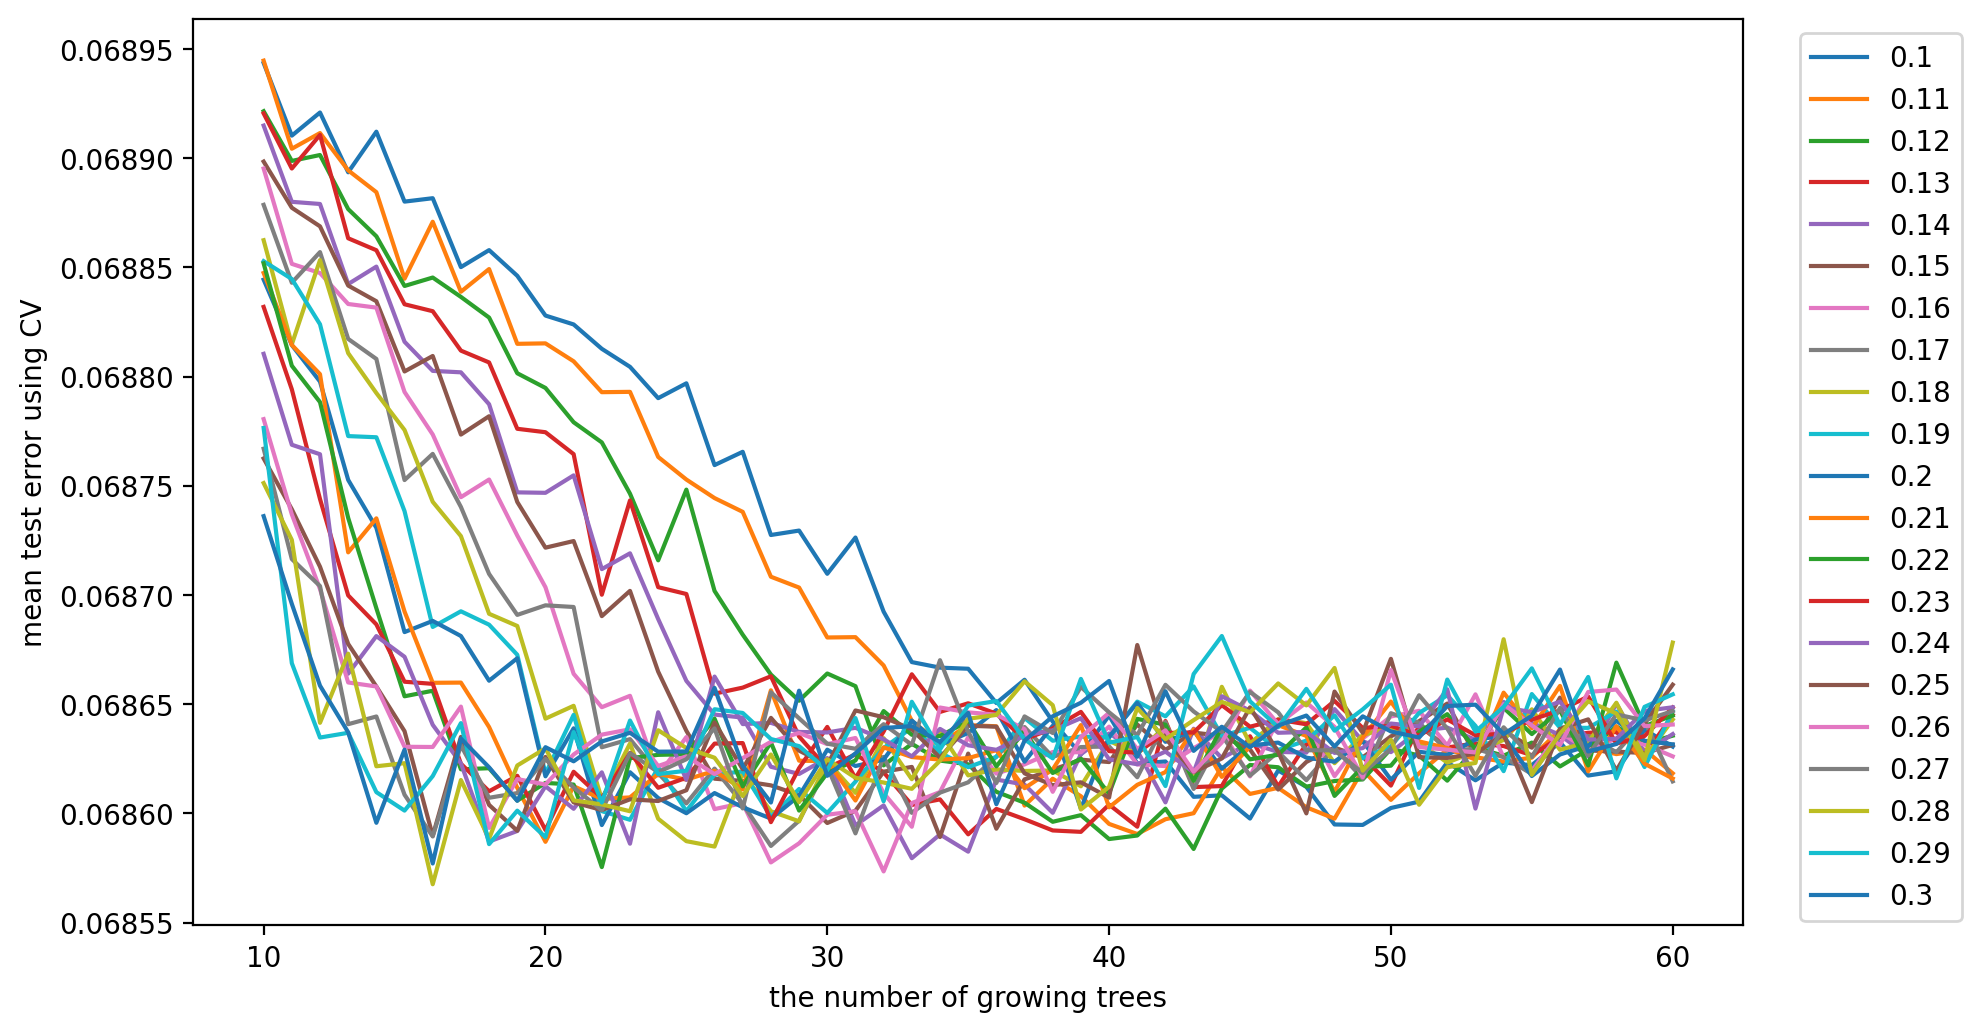

In [186]:
MSE_ada_mean = np.mean(MSE_ada, axis = 0)
plt.figure(figsize=(10, 6), dpi=200)
for i in range(len(learning_rates)):
    plt.plot(estimators, MSE_ada_mean[:, i])
# Function add a legend  
plt.legend(np.around(learning_rates, decimals=2), bbox_to_anchor=(1.15,1), loc ="upper right", fontsize=10)
plt.xticks(np.arange(min(estimators), max(estimators)+10, 10.0))
plt.xlabel('the number of growing trees')
plt.ylabel('mean test error using CV')
# plt.show()

In [187]:
# top 10 smallest test error
mini = np.sort(MSE_ada_mean.ravel())[0:10]
for i in range(MSE_ada_mean.shape[0]):
    for j in range(MSE_ada_mean.shape[1]):
        for k in range(np.size(mini)):
            if MSE_ada_mean[i][j] == mini[k]:
                print('The number growing trees: {}'.format(estimators[i]))
                print('Learning rate: {}'.format(round(learning_rates[j], 2)))
                print('Averge test error using CV: {}'.format(mini[k]))
                print('***********************************************')
print('--------------------------------------------------')
print('The smallest test error of AdaBoost regression is: {}'.format(mini[0]))

The number growing trees: 16
Learning rate: 0.28
Averge test error using CV: 0.06856757971324791
***********************************************
The number growing trees: 16
Learning rate: 0.3
Averge test error using CV: 0.06857708497504957
***********************************************
The number growing trees: 22
Learning rate: 0.22
Averge test error using CV: 0.06857543501983235
***********************************************
The number growing trees: 26
Learning rate: 0.18
Averge test error using CV: 0.06858484221740202
***********************************************
The number growing trees: 28
Learning rate: 0.16
Averge test error using CV: 0.06857758488698021
***********************************************
The number growing trees: 28
Learning rate: 0.17
Averge test error using CV: 0.06858511729324618
***********************************************
The number growing trees: 32
Learning rate: 0.16
Averge test error using CV: 0.06857346507715842
**********************************

## KNN regression

In [15]:
X_knn = raw_data[:, :-1]  # unstandardized
y_knn = raw_data[:, -1] # unstandardized
print(X_knn)
print(y_knn)

[[   0.    0.  395. ...    2.   11.  142.]
 [   0.    0.  635. ...    2.    1.   74.]
 [   0.    0.  725. ...    2.   11.  142.]
 ...
 [   1.   58. 1200. ...    2.   11.   98.]
 [   1.   58. 1170. ...    2.   11.  186.]
 [   1.   58. 1285. ...    2.    1.  156.]]
[0.4084507  0.18918919 0.57042254 ... 0.85714286 0.6827957  0.82051282]


In [17]:
np.size(np.arange(1, 13, 1))

12

In [31]:
# n - the number of observations; p - the number of features
[n, p] = np.shape(X_knn)

K = 10 # the number folds
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

neighbors = np.arange(1, 21, 1) # the number of nearest neighbors investigated - from 1 to 20
weights = np.array(['uniform', 'distance']) # unweighted KNN and weighted KNN
MSE_knn = np.zeros((10, 20, 2))
MSE_2d = np.zeros((20, 2))

for i in range(1, K+1):

    # Select the train/test data in this fold
    XTrain = X_knn[i != I, :]
    yTrain = y_knn[i != I]
    XTest = X_knn[i == I, :]
    yTest = y_knn[i == I]

    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)

    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)

    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response

    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data

    for j in range(20):
        neighbor = neighbors[j]
        for k in range(2):
            knn = KNeighborsRegressor(n_neighbors = neighbor, weights = weights[k], metric='euclidean')
            AB = knn.fit(XTrain, yTrain)
            prediction = AB.predict(XTest)
            MSE_2d[j, k] = np.mean((yTest - prediction) ** 2)
            print('fold: {} / k_nearest_neighbors: {} / weight: {}'.format(i, neighbors[j], weights[k]))
            print(np.mean((yTest - prediction) ** 2))
        print('--------------------------------------------------------------')
    MSE_knn[i-1, :, :] = MSE_2d

fold: 1 / k_nearest_neighbors: 1 / weight: uniform
0.09263110985849873
fold: 1 / k_nearest_neighbors: 1 / weight: distance
0.09263110985849873
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 2 / weight: uniform
0.07408310591028978
fold: 1 / k_nearest_neighbors: 2 / weight: distance
0.07408988680490439
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 3 / weight: uniform
0.06789005246652194
fold: 1 / k_nearest_neighbors: 3 / weight: distance
0.06789130847206035
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 4 / weight: uniform
0.06290628212761691
fold: 1 / k_nearest_neighbors: 4 / weight: distance
0.06291501514023945
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 5 / weight: uniform
0.05994259383297259
fold: 1 / k_nearest_neighbors: 5 / weight: distance
0.05995519624015208
---------------------------------

fold: 3 / k_nearest_neighbors: 1 / weight: uniform
0.09109802557925582
fold: 3 / k_nearest_neighbors: 1 / weight: distance
0.09109802557925582
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 2 / weight: uniform
0.07524347535040211
fold: 3 / k_nearest_neighbors: 2 / weight: distance
0.07522994887269782
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 3 / weight: uniform
0.06789126705977062
fold: 3 / k_nearest_neighbors: 3 / weight: distance
0.06787962482893181
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 4 / weight: uniform
0.06410653966873946
fold: 3 / k_nearest_neighbors: 4 / weight: distance
0.06409818993507113
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 5 / weight: uniform
0.061693848578975606
fold: 3 / k_nearest_neighbors: 5 / weight: distance
0.06169023244161483
--------------------------------

fold: 5 / k_nearest_neighbors: 1 / weight: uniform
0.09478446712787433
fold: 5 / k_nearest_neighbors: 1 / weight: distance
0.09478446712787433
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 2 / weight: uniform
0.07773901546954898
fold: 5 / k_nearest_neighbors: 2 / weight: distance
0.07775800828847935
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 3 / weight: uniform
0.07002273094359474
fold: 5 / k_nearest_neighbors: 3 / weight: distance
0.07004142476065807
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 4 / weight: uniform
0.06552927427960874
fold: 5 / k_nearest_neighbors: 4 / weight: distance
0.06555393392555378
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 5 / weight: uniform
0.062152132964972163
fold: 5 / k_nearest_neighbors: 5 / weight: distance
0.06218151798404295
--------------------------------

fold: 7 / k_nearest_neighbors: 1 / weight: uniform
0.09472492753119846
fold: 7 / k_nearest_neighbors: 1 / weight: distance
0.09472492753119846
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 2 / weight: uniform
0.07714215770139651
fold: 7 / k_nearest_neighbors: 2 / weight: distance
0.07715814513082261
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 3 / weight: uniform
0.06916533417752514
fold: 7 / k_nearest_neighbors: 3 / weight: distance
0.0691890588279695
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 4 / weight: uniform
0.06529566078633117
fold: 7 / k_nearest_neighbors: 4 / weight: distance
0.0653129012413547
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 5 / weight: uniform
0.06256835225920564
fold: 7 / k_nearest_neighbors: 5 / weight: distance
0.0625784476737513
------------------------------------

fold: 9 / k_nearest_neighbors: 1 / weight: uniform
0.09446012461753385
fold: 9 / k_nearest_neighbors: 1 / weight: distance
0.09446012461753385
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 2 / weight: uniform
0.07412084409739687
fold: 9 / k_nearest_neighbors: 2 / weight: distance
0.07413024053198639
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 3 / weight: uniform
0.06531246026522168
fold: 9 / k_nearest_neighbors: 3 / weight: distance
0.06532820818786898
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 4 / weight: uniform
0.06125183698216935
fold: 9 / k_nearest_neighbors: 4 / weight: distance
0.061264556827180516
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 5 / weight: uniform
0.05883759642080906
fold: 9 / k_nearest_neighbors: 5 / weight: distance
0.05885175019888119
--------------------------------

fold: 10 / k_nearest_neighbors: 20 / weight: distance
0.05065438090804557
--------------------------------------------------------------


[[0.0938629  0.0938629 ]
 [0.07601226 0.07601961]
 [0.06861982 0.06862866]
 [0.0643539  0.06436411]
 [0.06148638 0.06149858]
 [0.05953908 0.05955167]
 [0.05815297 0.0581638 ]
 [0.05696183 0.05697157]
 [0.05598502 0.05599262]
 [0.05514518 0.05515224]
 [0.0544941  0.05449942]
 [0.05389739 0.05390259]
 [0.05344634 0.05344968]
 [0.05309    0.05309126]
 [0.05272757 0.05272717]
 [0.05245576 0.05245347]
 [0.05220397 0.0521996 ]
 [0.05194498 0.05193922]
 [0.05165746 0.0516513 ]
 [0.0514724  0.05146479]]


Text(0, 0.5, 'mean test error using CV')

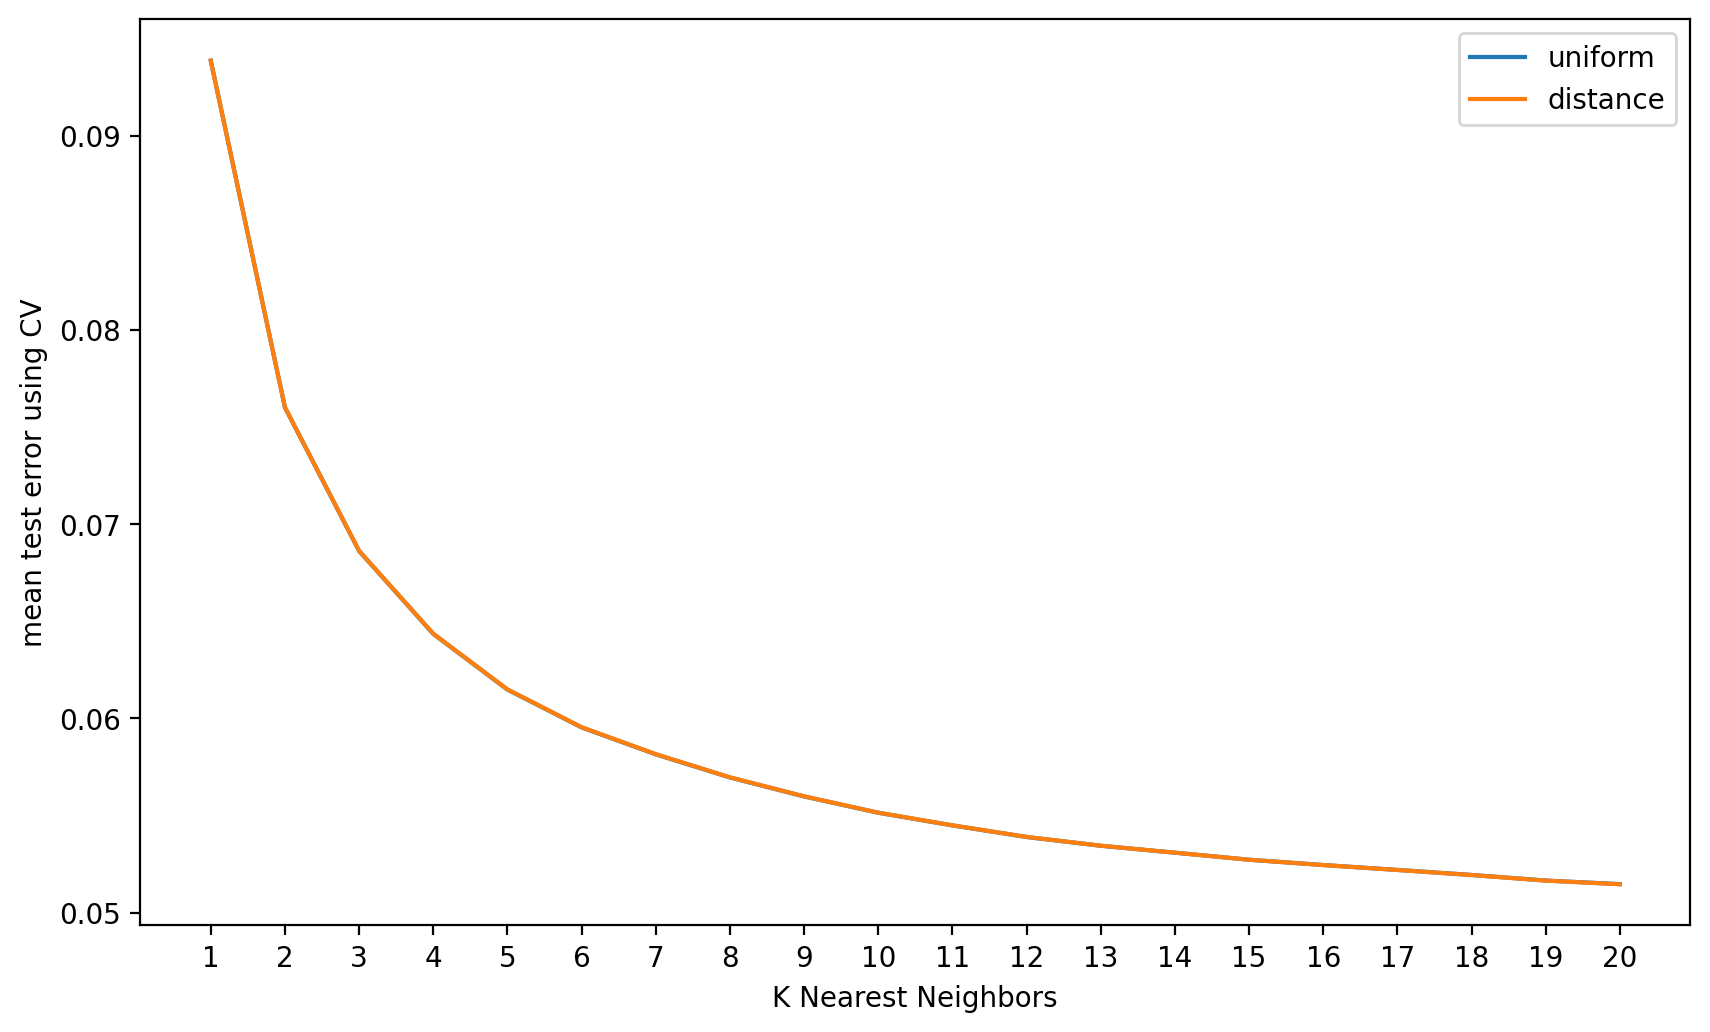

In [32]:
MSE_knn_mean = np.mean(MSE_knn, axis = 0)
print(MSE_knn_mean)
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(neighbors, MSE_knn_mean[:, 0])
plt.plot(neighbors, MSE_knn_mean[:, 1])
# Function add a legend  
plt.legend(weights, loc ="upper right", fontsize=10)
plt.xticks(np.arange(min(neighbors), max(neighbors)+1, 1.0))
plt.xlabel('K Nearest Neighbors')
plt.ylabel('mean test error using CV')

In [13]:
print(np.size(np.arange(25, 101, 1)))
print(np.arange(25, 101, 1))

76
[ 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100]


In [16]:
# n - the number of observations; p - the number of features
[n, p] = np.shape(X_knn)

K = 10 # the number folds
# Create a vector of length n that contains equal amounts of numbers from 1 to K
I = np.asarray([0] * n)
for i in range(n):
    I[i] = (i) % K + 1

# Permute that vector. 
I = I[np.random.permutation(n)]

neighbors = np.arange(25, 101, 1) # the number of nearest neighbors investigated - from 1 to 20
weights = np.array(['uniform', 'distance']) # unweighted KNN and weighted KNN
MSE_knn = np.zeros((10, 76, 2))
MSE_2d = np.zeros((76, 2))

for i in range(1, K+1):

    # Select the train/test data in this fold
    XTrain = X_knn[i != I, :]
    yTrain = y_knn[i != I]
    XTest = X_knn[i == I, :]
    yTest = y_knn[i == I]

    # Standardize
    # yTrain = standardization(yTrain)
    # yTest = standardization(yTest)

    # XTrain = standardize_X(XTrain)
    # XTest = standardize_X(XTest)

    # Normalize
    yTrain, mu = centerData(yTrain); # center training response
    yTest = yTest - mu; # use the mean value of the training response to center the test response

    XTrain, mu = centerData(XTrain); # center training data
    XTest = XTest - mu; # use the mean value of the training data to center the test data
    normalizer_train = preproc.Normalizer().fit(XTrain.T) # Calculate training normalizer
    XTrain = normalizer_train.transform(XTrain.T).T # normalize training data
    normalizer_test = preproc.Normalizer().fit(XTest.T)  # Calculate the testing normalizer
    XTest = normalizer_test.transform(XTest.T).T # normalize test data

    for j in range(76):
        neighbor = neighbors[j]
        for k in range(2):
            knn = KNeighborsRegressor(n_neighbors = neighbor, weights = weights[k], metric='euclidean')
            AB = knn.fit(XTrain, yTrain)
            prediction = AB.predict(XTest)
            MSE_2d[j, k] = np.mean((yTest - prediction) ** 2)
            print('fold: {} / k_nearest_neighbors: {} / weight: {}'.format(i, neighbors[j], weights[k]))
            print(np.mean((yTest - prediction) ** 2))
        print('--------------------------------------------------------------')
    MSE_knn[i-1, :, :] = MSE_2d

fold: 1 / k_nearest_neighbors: 25 / weight: uniform
0.049837864091185416
fold: 1 / k_nearest_neighbors: 25 / weight: distance
0.049817757012111226
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 26 / weight: uniform
0.049765668046763516
fold: 1 / k_nearest_neighbors: 26 / weight: distance
0.04974332743339297
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 27 / weight: uniform
0.04967661819702908
fold: 1 / k_nearest_neighbors: 27 / weight: distance
0.049651672719328584
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 28 / weight: uniform
0.049639827245145825
fold: 1 / k_nearest_neighbors: 28 / weight: distance
0.049610814710259965
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 29 / weight: uniform
0.04952972585311728
fold: 1 / k_nearest_neighbors: 29 / weight: distance
0.04950034818084017
-----------------

fold: 1 / k_nearest_neighbors: 64 / weight: distance
0.049374724059822406
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 65 / weight: uniform
0.04949361625258542
fold: 1 / k_nearest_neighbors: 65 / weight: distance
0.04942090434807991
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 66 / weight: uniform
0.0494995353242433
fold: 1 / k_nearest_neighbors: 66 / weight: distance
0.04942770479275959
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 67 / weight: uniform
0.04952712553550383
fold: 1 / k_nearest_neighbors: 67 / weight: distance
0.04945357686701344
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 68 / weight: uniform
0.04952868745175514
fold: 1 / k_nearest_neighbors: 68 / weight: distance
0.049454383536953174
--------------------------------------------------------------
fold: 1 / k_nearest_neighbors: 

fold: 2 / k_nearest_neighbors: 28 / weight: uniform
0.05103040069348527
fold: 2 / k_nearest_neighbors: 28 / weight: distance
0.0510093313233217
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 29 / weight: uniform
0.050843977566457615
fold: 2 / k_nearest_neighbors: 29 / weight: distance
0.050823656590048914
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 30 / weight: uniform
0.050715196366810184
fold: 2 / k_nearest_neighbors: 30 / weight: distance
0.05069232326416416
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 31 / weight: uniform
0.05065880556103695
fold: 2 / k_nearest_neighbors: 31 / weight: distance
0.050634957456867434
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 32 / weight: uniform
0.05053413854050366
fold: 2 / k_nearest_neighbors: 32 / weight: distance
0.05051087942787562
--------------------

fold: 2 / k_nearest_neighbors: 67 / weight: distance
0.049241318707815986
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 68 / weight: uniform
0.049293577819316904
fold: 2 / k_nearest_neighbors: 68 / weight: distance
0.049241863245892456
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 69 / weight: uniform
0.04929148786253764
fold: 2 / k_nearest_neighbors: 69 / weight: distance
0.049239204870439604
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 70 / weight: uniform
0.0493251655457906
fold: 2 / k_nearest_neighbors: 70 / weight: distance
0.04927064516724803
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors: 71 / weight: uniform
0.04937865595911639
fold: 2 / k_nearest_neighbors: 71 / weight: distance
0.04932173716485683
--------------------------------------------------------------
fold: 2 / k_nearest_neighbors

fold: 3 / k_nearest_neighbors: 31 / weight: uniform
0.049264264401082454
fold: 3 / k_nearest_neighbors: 31 / weight: distance
0.049250307329166326
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 32 / weight: uniform
0.04908009818914651
fold: 3 / k_nearest_neighbors: 32 / weight: distance
0.04906715037445795
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 33 / weight: uniform
0.048882037661627964
fold: 3 / k_nearest_neighbors: 33 / weight: distance
0.04887143172244728
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 34 / weight: uniform
0.04877583478562403
fold: 3 / k_nearest_neighbors: 34 / weight: distance
0.0487639204461617
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 35 / weight: uniform
0.048610116552127325
fold: 3 / k_nearest_neighbors: 35 / weight: distance
0.04859797085802709
--------------------

fold: 3 / k_nearest_neighbors: 70 / weight: distance
0.047909116383271944
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 71 / weight: uniform
0.04796162540556826
fold: 3 / k_nearest_neighbors: 71 / weight: distance
0.04791565724225919
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 72 / weight: uniform
0.04798798076115011
fold: 3 / k_nearest_neighbors: 72 / weight: distance
0.047940880788189526
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 73 / weight: uniform
0.04802473138865405
fold: 3 / k_nearest_neighbors: 73 / weight: distance
0.0479762922576565
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 74 / weight: uniform
0.04805487234779855
fold: 3 / k_nearest_neighbors: 74 / weight: distance
0.04800489846251868
--------------------------------------------------------------
fold: 3 / k_nearest_neighbors: 

fold: 4 / k_nearest_neighbors: 34 / weight: uniform
0.05187586330964166
fold: 4 / k_nearest_neighbors: 34 / weight: distance
0.05184365580272005
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 35 / weight: uniform
0.05178595552212999
fold: 4 / k_nearest_neighbors: 35 / weight: distance
0.0517534913715627
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 36 / weight: uniform
0.0517591866823128
fold: 4 / k_nearest_neighbors: 36 / weight: distance
0.051724491267062064
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 37 / weight: uniform
0.05170375368998344
fold: 4 / k_nearest_neighbors: 37 / weight: distance
0.0516689289077724
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 38 / weight: uniform
0.05173231506286871
fold: 4 / k_nearest_neighbors: 38 / weight: distance
0.051695156946990124
------------------------

fold: 4 / k_nearest_neighbors: 73 / weight: distance
0.051836895301439256
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 74 / weight: uniform
0.05189887299522065
fold: 4 / k_nearest_neighbors: 74 / weight: distance
0.051825722119772266
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 75 / weight: uniform
0.051909546483543186
fold: 4 / k_nearest_neighbors: 75 / weight: distance
0.05183559225698858
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 76 / weight: uniform
0.05196113065660955
fold: 4 / k_nearest_neighbors: 76 / weight: distance
0.051885573862785674
--------------------------------------------------------------
fold: 4 / k_nearest_neighbors: 77 / weight: uniform
0.05201229711451556
fold: 4 / k_nearest_neighbors: 77 / weight: distance
0.05193490724318032
--------------------------------------------------------------
fold: 4 / k_nearest_neighbor

fold: 5 / k_nearest_neighbors: 37 / weight: uniform
0.05037299792576628
fold: 5 / k_nearest_neighbors: 37 / weight: distance
0.050359572120857364
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 38 / weight: uniform
0.050270226035342605
fold: 5 / k_nearest_neighbors: 38 / weight: distance
0.050256949249466075
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 39 / weight: uniform
0.050171883076231424
fold: 5 / k_nearest_neighbors: 39 / weight: distance
0.050158016865009446
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 40 / weight: uniform
0.050138499135395385
fold: 5 / k_nearest_neighbors: 40 / weight: distance
0.050123346993080034
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 41 / weight: uniform
0.05016737168031614
fold: 5 / k_nearest_neighbors: 41 / weight: distance
0.0501491371872926
-----------------

fold: 5 / k_nearest_neighbors: 76 / weight: distance
0.050003752188860405
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 77 / weight: uniform
0.05006427287553099
fold: 5 / k_nearest_neighbors: 77 / weight: distance
0.05000341351710313
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 78 / weight: uniform
0.050078255489191245
fold: 5 / k_nearest_neighbors: 78 / weight: distance
0.05001607669026482
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 79 / weight: uniform
0.050103084852812764
fold: 5 / k_nearest_neighbors: 79 / weight: distance
0.05003941949529775
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors: 80 / weight: uniform
0.05012178024438901
fold: 5 / k_nearest_neighbors: 80 / weight: distance
0.05005625507342578
--------------------------------------------------------------
fold: 5 / k_nearest_neighbors

fold: 6 / k_nearest_neighbors: 40 / weight: uniform
0.04955228969044277
fold: 6 / k_nearest_neighbors: 40 / weight: distance
0.049526537251421206
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 41 / weight: uniform
0.04959640231854339
fold: 6 / k_nearest_neighbors: 41 / weight: distance
0.049568791305665924
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 42 / weight: uniform
0.04956440552495133
fold: 6 / k_nearest_neighbors: 42 / weight: distance
0.0495359116559113
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 43 / weight: uniform
0.049573360929196286
fold: 6 / k_nearest_neighbors: 43 / weight: distance
0.049542895971434825
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 44 / weight: uniform
0.04959835874132005
fold: 6 / k_nearest_neighbors: 44 / weight: distance
0.04956576225436132
--------------------

fold: 6 / k_nearest_neighbors: 79 / weight: distance
0.04974911698174137
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 80 / weight: uniform
0.04985614503540507
fold: 6 / k_nearest_neighbors: 80 / weight: distance
0.04979421270669677
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 81 / weight: uniform
0.04983407313613848
fold: 6 / k_nearest_neighbors: 81 / weight: distance
0.049772577010833534
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 82 / weight: uniform
0.04983797990481453
fold: 6 / k_nearest_neighbors: 82 / weight: distance
0.0497760807239112
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors: 83 / weight: uniform
0.049855663149708185
fold: 6 / k_nearest_neighbors: 83 / weight: distance
0.049792778342422614
--------------------------------------------------------------
fold: 6 / k_nearest_neighbors:

fold: 7 / k_nearest_neighbors: 43 / weight: uniform
0.0497986582364915
fold: 7 / k_nearest_neighbors: 43 / weight: distance
0.04977485860187027
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 44 / weight: uniform
0.04978200302790331
fold: 7 / k_nearest_neighbors: 44 / weight: distance
0.049757457623317625
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 45 / weight: uniform
0.04976955961068686
fold: 7 / k_nearest_neighbors: 45 / weight: distance
0.049744078260039015
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 46 / weight: uniform
0.04976592687484047
fold: 7 / k_nearest_neighbors: 46 / weight: distance
0.049739104059763076
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 47 / weight: uniform
0.04963866513970234
fold: 7 / k_nearest_neighbors: 47 / weight: distance
0.04961373453709185
---------------------

fold: 7 / k_nearest_neighbors: 82 / weight: distance
0.04937960068967747
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 83 / weight: uniform
0.04944893666273232
fold: 7 / k_nearest_neighbors: 83 / weight: distance
0.04939976578093651
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 84 / weight: uniform
0.04945524895689558
fold: 7 / k_nearest_neighbors: 84 / weight: distance
0.04940584161810876
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 85 / weight: uniform
0.049453202481133246
fold: 7 / k_nearest_neighbors: 85 / weight: distance
0.04940342835769676
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors: 86 / weight: uniform
0.04945766006572375
fold: 7 / k_nearest_neighbors: 86 / weight: distance
0.049407086280882695
--------------------------------------------------------------
fold: 7 / k_nearest_neighbors:

fold: 8 / k_nearest_neighbors: 46 / weight: uniform
0.04905451906623731
fold: 8 / k_nearest_neighbors: 46 / weight: distance
0.04900681688201492
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 47 / weight: uniform
0.048956818437372325
fold: 8 / k_nearest_neighbors: 47 / weight: distance
0.04891015676488921
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 48 / weight: uniform
0.04896026231637775
fold: 8 / k_nearest_neighbors: 48 / weight: distance
0.048912670911956405
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 49 / weight: uniform
0.04899366540235257
fold: 8 / k_nearest_neighbors: 49 / weight: distance
0.048944996457074764
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 50 / weight: uniform
0.04893343501685702
fold: 8 / k_nearest_neighbors: 50 / weight: distance
0.048885174205481254
-------------------

fold: 8 / k_nearest_neighbors: 85 / weight: distance
0.049317582913655046
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 86 / weight: uniform
0.049411430839973416
fold: 8 / k_nearest_neighbors: 86 / weight: distance
0.049335977426798364
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 87 / weight: uniform
0.049413758430935074
fold: 8 / k_nearest_neighbors: 87 / weight: distance
0.0493378336536606
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 88 / weight: uniform
0.04946475205503229
fold: 8 / k_nearest_neighbors: 88 / weight: distance
0.049387649196404405
--------------------------------------------------------------
fold: 8 / k_nearest_neighbors: 89 / weight: uniform
0.04945382612231667
fold: 8 / k_nearest_neighbors: 89 / weight: distance
0.04937658285907738
--------------------------------------------------------------
fold: 8 / k_nearest_neighbor

fold: 9 / k_nearest_neighbors: 49 / weight: uniform
0.05091933781581571
fold: 9 / k_nearest_neighbors: 49 / weight: distance
0.05085920051811109
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 50 / weight: uniform
0.05090952935261176
fold: 9 / k_nearest_neighbors: 50 / weight: distance
0.05084834138232918
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 51 / weight: uniform
0.050827173129526795
fold: 9 / k_nearest_neighbors: 51 / weight: distance
0.05076613599547925
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 52 / weight: uniform
0.0508115580630114
fold: 9 / k_nearest_neighbors: 52 / weight: distance
0.05075088081698969
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 53 / weight: uniform
0.050796401090598624
fold: 9 / k_nearest_neighbors: 53 / weight: distance
0.05073559789429126
----------------------

fold: 9 / k_nearest_neighbors: 88 / weight: distance
0.051248423389219575
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 89 / weight: uniform
0.051371930222348074
fold: 9 / k_nearest_neighbors: 89 / weight: distance
0.05128554256552809
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 90 / weight: uniform
0.05138183192472864
fold: 9 / k_nearest_neighbors: 90 / weight: distance
0.05129448746054255
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 91 / weight: uniform
0.05140519892236429
fold: 9 / k_nearest_neighbors: 91 / weight: distance
0.0513172833574499
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 92 / weight: uniform
0.05146204144933977
fold: 9 / k_nearest_neighbors: 92 / weight: distance
0.05137245833417293
--------------------------------------------------------------
fold: 9 / k_nearest_neighbors: 

fold: 10 / k_nearest_neighbors: 52 / weight: uniform
0.0499217616697606
fold: 10 / k_nearest_neighbors: 52 / weight: distance
0.04988402266008115
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 53 / weight: uniform
0.049943460680935046
fold: 10 / k_nearest_neighbors: 53 / weight: distance
0.04990401071105194
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 54 / weight: uniform
0.049920536991041535
fold: 10 / k_nearest_neighbors: 54 / weight: distance
0.04988034299672442
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 55 / weight: uniform
0.049915026917732634
fold: 10 / k_nearest_neighbors: 55 / weight: distance
0.049874092051351605
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 56 / weight: uniform
0.04992469318062517
fold: 10 / k_nearest_neighbors: 56 / weight: distance
0.04988202699354247
----------

fold: 10 / k_nearest_neighbors: 91 / weight: uniform
0.050509233548182715
fold: 10 / k_nearest_neighbors: 91 / weight: distance
0.050429860663429145
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 92 / weight: uniform
0.05055889666063698
fold: 10 / k_nearest_neighbors: 92 / weight: distance
0.050478003884096304
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 93 / weight: uniform
0.05058147269922901
fold: 10 / k_nearest_neighbors: 93 / weight: distance
0.05049976571470512
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 94 / weight: uniform
0.050587228979612445
fold: 10 / k_nearest_neighbors: 94 / weight: distance
0.05050539426943663
--------------------------------------------------------------
fold: 10 / k_nearest_neighbors: 95 / weight: uniform
0.0505952123537133
fold: 10 / k_nearest_neighbors: 95 / weight: distance
0.05051279814247639
----------

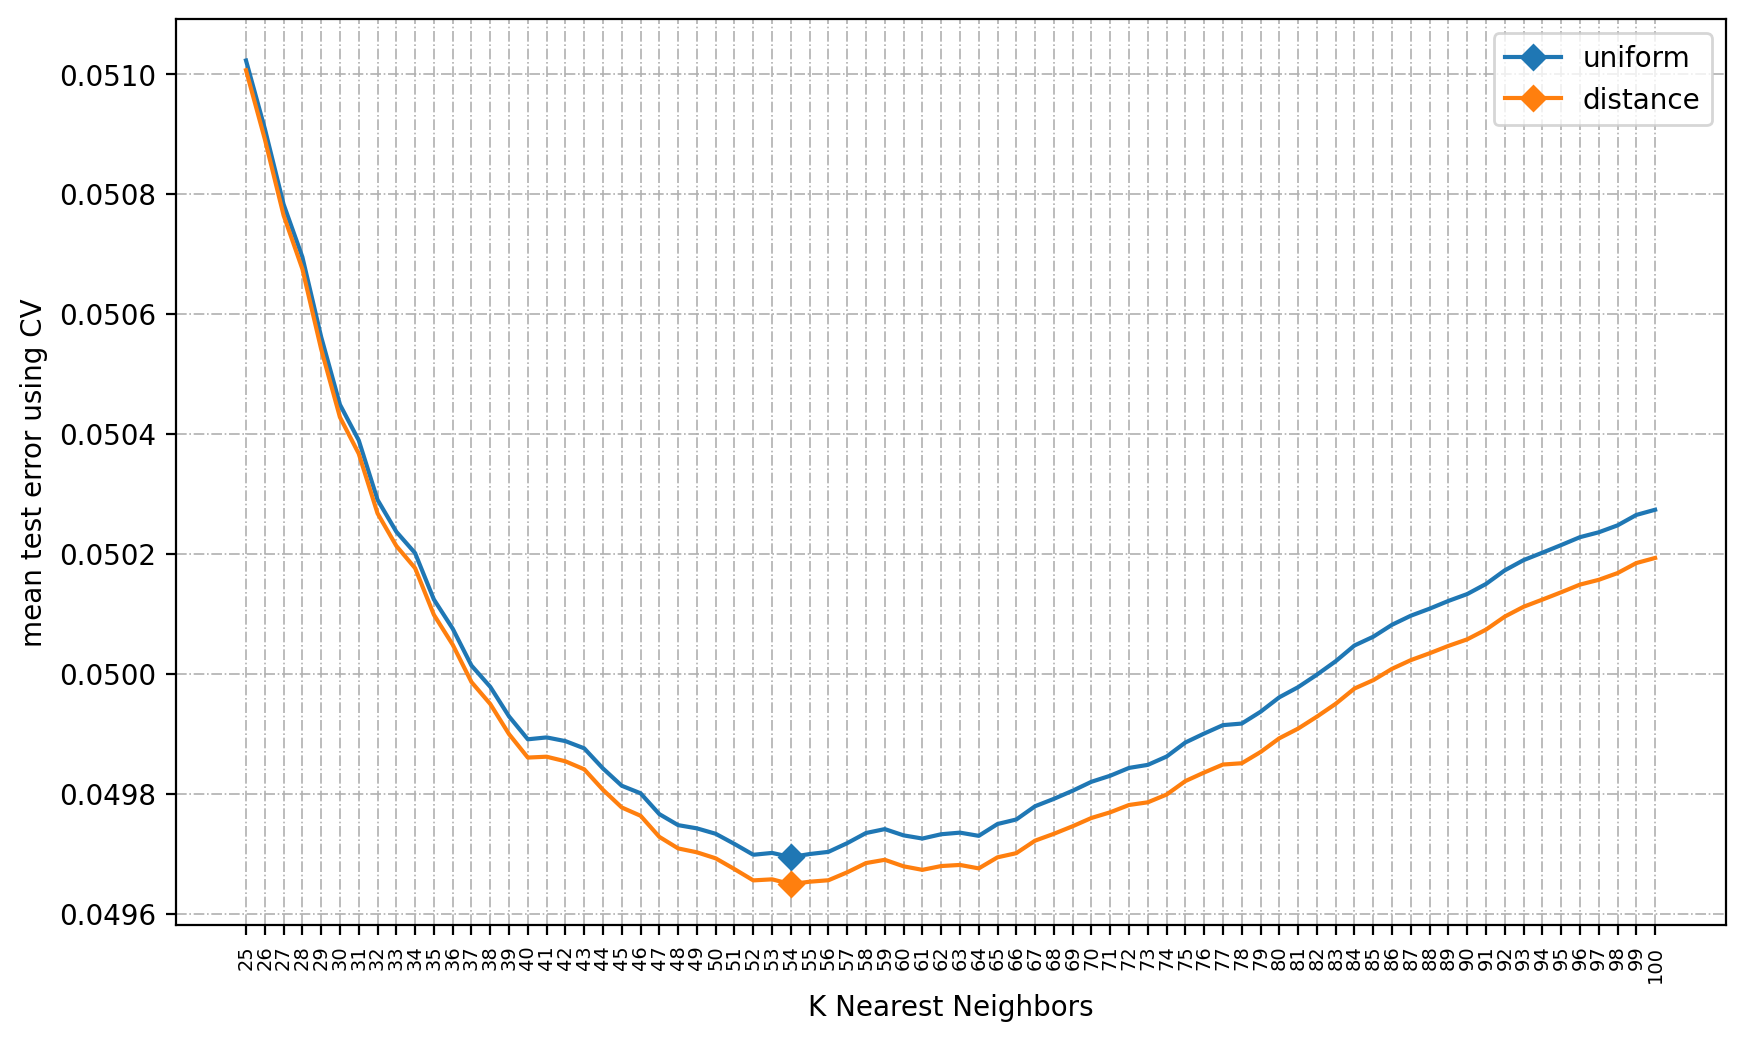

In [50]:
MSE_knn_mean = np.mean(MSE_knn, axis = 0)
# print(MSE_knn_mean)
plt.figure(figsize=(10, 6), dpi=200)
# plt.point(np.arange(25, 101, 1)[np.argmin(MSE_knn_mean[:, 0], np.min(MSE_knn_mean[:, 0]))
# Function add a legend  
markers_on_uniform = [np.argmin(MSE_knn_mean[:, 0])]
plt.plot(neighbors, MSE_knn_mean[:, 0], '-D', markevery=markers_on_uniform, label='smallest')
markers_on_distance = [np.argmin(MSE_knn_mean[:, 1])]
plt.plot(neighbors, MSE_knn_mean[:, 1], '-D', markevery=markers_on_distance, label='smallest')
plt.legend(weights, loc ="upper right", fontsize=10)
plt.xticks(np.arange(min(neighbors), max(neighbors)+1, 1.0), rotation = 90, fontsize = 7)
plt.xlabel('K Nearest Neighbors')
plt.ylabel('mean test error using CV')
plt.grid(linestyle='-.', linewidth=0.6)
plt.savefig("Figures/knn_precise.png")

In [26]:
print('Weighted KNN at K equals to {}'.format(np.arange(25, 101, 1)[np.argmin(MSE_knn_mean[:, 1])]))
print('Mean test error using CV for weighted scheme: {}'.format(np.min(MSE_knn_mean[:, 1])))
print('Uniform KNN at K equals to {}'.format(np.arange(25, 101, 1)[np.argmin(MSE_knn_mean[:, 0])]))
print('Mean test error using CV for uniform scheme: {}'.format(np.min(MSE_knn_mean[:, 0])))

Weighted KNN at K equals to 54
Mean test error using CV for weighted scheme: 0.049649226672564405
Uniform KNN at K equals to 54
Mean test error using CV for uniform scheme: 0.049694286598773715


In [52]:
# the final knn model to fit the data we need to predict
knn_final = KNeighborsRegressor(n_neighbors = 54, weights = 'distance', metric='euclidean')

# Prediction for March

In [11]:
# load the excel containing our prediction target
M = pd.read_excel('Future Schedule 20220301-20220331.xlsx')

In [12]:
M

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity
0,2022-03-01 05:45:00,UK,1315,YXX,319,J,CA,131
1,2022-03-01 07:15:00,PW,950,YLW,319,J,CA,143
2,2022-03-01 06:45:00,VW,770,YYZ,320,J,CA,220
3,2022-03-01 06:40:00,DO,2568,YXU,32N,J,CA,180
4,2022-03-01 07:30:00,AY,984,YYG,320,J,CA,174
...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186


In [13]:
################################
#Process 'ScheduleTime' Feature#
################################
M.insert(1,'Year', M['ScheduleTime'].dt.year)  # insert a column for year

# calculate days passed from the first day of the year (xxxx-01-01 00:00:00)
M.insert(2,'DateReference', pd.to_datetime(M['Year'].astype(str) + '-01-01 00:00:00'))
M.insert(3,'DaysPassed', 
         ((M['ScheduleTime'] - M['DateReference'])/pd.Timedelta(1, 'd')).fillna(0).astype(int))
# calculate minutes passed from the beginning of the day (00:00:00)
M.insert(4,'MinutesPassed', (M['ScheduleTime'].dt.hour * 60 + M['ScheduleTime'].dt.minute).astype(int))
# calculate day of week (Monday - 0; Sunday - 6)
M.insert(5,'DayOfWeek', (M['ScheduleTime'].dt.dayofweek).astype(int))
M = M.drop('DateReference', 1)

In [14]:
M

,ScheduleTime,Year,DaysPassed,MinutesPassed,DayOfWeek,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity
0,2022-03-01 05:45:00,2022,59,345,1,UK,1315,YXX,319,J,CA,131
1,2022-03-01 07:15:00,2022,59,435,1,PW,950,YLW,319,J,CA,143
2,2022-03-01 06:45:00,2022,59,405,1,VW,770,YYZ,320,J,CA,220
3,2022-03-01 06:40:00,2022,59,400,1,DO,2568,YXU,32N,J,CA,180
4,2022-03-01 07:30:00,2022,59,450,1,AY,984,YYG,320,J,CA,174
...,...,...,...,...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,2022,89,1265,3,SV,1988,YYJ,73H,J,CA,186
4809,2022-03-31 20:55:00,2022,89,1255,3,MD,1242,YBR,321,J,CA,230
4810,2022-03-31 21:50:00,2022,89,1310,3,LJ,506,YUL,320,J,CA,186
4811,2022-03-31 20:30:00,2022,89,1230,3,LJ,772,YEG,320,J,CA,186


In [16]:
# force types of each column
M['Year'] = M['Year'].astype(int)
M['DaysPassed'] = M['DaysPassed'].astype(int)
M['MinutesPassed'] = M['MinutesPassed'].astype(int)
M['DayOfWeek'] = M['DayOfWeek'].astype(int)
M['Airline'] = M['Airline'].astype(str)
M['FlightNumber'] = M['FlightNumber'].astype(int)
M['Destination'] = M['Destination'].astype(str)
M['AircraftType'] = M['AircraftType'].astype(str)
M['FlightType'] = M['FlightType'].astype(str)
M['Sector'] = M['Sector'].astype(str)
M['SeatCapacity'] = M['SeatCapacity'].astype(int)

In [17]:
###################
#Holiday Indicator#
###################

################################
#Easter of 2021 - 4th of April##
#Easter of 2022 - 17th of April#
################################

multiplier = 7  # the number of days in Easter holiday
def add_holiday(x):
    if x.Year == 2021:
        day = 93  # Easter day of 2021 from new years day
    else:
        day = 106  # Easter day of 2022 from new years day
    indicator = (x.DaysPassed - day) * 0.1 if abs(x.DaysPassed - day) <= 10 else 0
    if indicator < 0:  # before Easter
        indicator += 1
    elif indicator > 0:  # after Easter
        indicator -= 1
    elif abs(x.DaysPassed - day) <= 10:
        indicator = 1
    indicator *= multiplier

    for i, v in x.items():
        if i == 'holidayIndicator':
            indicator += x.holidayIndicator
            break
    return indicator

holiday_column = M.apply(add_holiday, axis=1, result_type='expand')
M.insert(5,'HolidayIndicator', holiday_column.astype(float))

In [18]:
M

,ScheduleTime,Year,DaysPassed,MinutesPassed,DayOfWeek,HolidayIndicator,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity
0,2022-03-01 05:45:00,2022,59,345,1,0.0,UK,1315,YXX,319,J,CA,131
1,2022-03-01 07:15:00,2022,59,435,1,0.0,PW,950,YLW,319,J,CA,143
2,2022-03-01 06:45:00,2022,59,405,1,0.0,VW,770,YYZ,320,J,CA,220
3,2022-03-01 06:40:00,2022,59,400,1,0.0,DO,2568,YXU,32N,J,CA,180
4,2022-03-01 07:30:00,2022,59,450,1,0.0,AY,984,YYG,320,J,CA,174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,2022,89,1265,3,0.0,SV,1988,YYJ,73H,J,CA,186
4809,2022-03-31 20:55:00,2022,89,1255,3,0.0,MD,1242,YBR,321,J,CA,230
4810,2022-03-31 21:50:00,2022,89,1310,3,0.0,LJ,506,YUL,320,J,CA,186
4811,2022-03-31 20:30:00,2022,89,1230,3,0.0,LJ,772,YEG,320,J,CA,186


In [20]:
march = M.iloc[:, 1:].values
print(march)

[[2022 59 345 ... 'J' 'CA' 131]
 [2022 59 435 ... 'J' 'CA' 143]
 [2022 59 405 ... 'J' 'CA' 220]
 ...
 [2022 89 1310 ... 'J' 'CA' 186]
 [2022 89 1230 ... 'J' 'CA' 186]
 [2022 89 1275 ... 'J' 'CA' 220]]


In [47]:
print(data_without_encoders)

[[2021 0 395 ... 'J' 'US' 142]
 [2021 0 635 ... 'J' 'CA' 74]
 [2021 0 725 ... 'J' 'US' 142]
 ...
 [2022 58 1200 ... 'J' 'US' 98]
 [2022 58 1170 ... 'J' 'US' 186]
 [2022 58 1285 ... 'J' 'CA' 156]]


In [54]:
combine = np.vstack((data_without_encoders, march))
print(combine)

[[2021 0 395 ... 'J' 'US' 142]
 [2021 0 635 ... 'J' 'CA' 74]
 [2021 0 725 ... 'J' 'US' 142]
 ...
 [2022 89 1310 ... 'J' 'CA' 186]
 [2022 89 1230 ... 'J' 'CA' 186]
 [2022 89 1275 ... 'J' 'CA' 220]]


In [67]:
data_with_response = data_without_encoders

# Year
le_year_combine = LabelEncoder()
combine[:, 0] = le_year_combine.fit_transform(combine[:, 0])
data_with_response[:, 0] = combine[:-4813, 0]
march[:, 0] = combine[-4813:, 0]

# Airline
le_airline_combine = LabelEncoder()
combine[:, 5] = le_airline_combine.fit_transform(combine[:, 5])
data_with_response[:, 5] = combine[:-4813, 5]
march[:, 5] = combine[-4813:, 5]

# FlightNumber
le_flight_number_combine = LabelEncoder()
combine[:, 6] = le_flight_number_combine.fit_transform(combine[:, 6])
data_with_response[:, 6] = combine[:-4813, 6]
march[:, 6] = combine[-4813:, 6]

# Destination 
le_destination_combine = LabelEncoder()
combine[:, 7] = le_destination_combine.fit_transform(combine[:, 7])
data_with_response[:, 7] = combine[:-4813, 7]
march[:, 7] = combine[-4813:, 7]

# AircraftType
le_aircraft_type_combine = LabelEncoder()
combine[:, 8] = le_aircraft_type_combine.fit_transform(combine[:, 8])
data_with_response[:, 8] = combine[:-4813, 8]
march[:, 8] = combine[-4813:, 8]

# FlightType
le_flight_type_combine = LabelEncoder()
combine[:, 9] = le_flight_type_combine.fit_transform(combine[:, 9])
data_with_response[:, 9] = combine[:-4813, 9]
march[:, 9] = combine[-4813:, 9]

# Sector
le_sector_combine = LabelEncoder()
combine[:, 10] = le_sector_combine.fit_transform(combine[:, 10])
data_with_response[:, 10] = combine[:-4813, 10]
march[:, 10] = combine[-4813:, 10]

data_with_response = data_with_response.astype(float)
march = march.astype(float)

## prepared data
- march: unstandardized data to predict
- data with response: all available data with response

In [81]:
ytrain = raw_data[:, -1]
ytrain, mu_ytrain = centerData(ytrain)

In [83]:
Xtrain, mu_Xtrain = centerData(data_with_response)
Xtest = march - mu_Xtrain
normalizer_train = preproc.Normalizer().fit(Xtrain.T) 
normalizer_test = preproc.Normalizer().fit(Xtest.T) 
Xtrain = normalizer_train.transform(Xtrain.T).T 
Xtest = normalizer_test.transform(Xtest.T).T 

In [86]:
# the final knn model to fit the data we need to predict
knn_final = KNeighborsRegressor(n_neighbors = 54, weights = 'distance', metric='euclidean')
fitting = knn_final.fit(Xtrain, ytrain)
prediction = fitting.predict(Xtest)
print(prediction)

[-0.02049445 -0.00424311  0.00792511 ...  0.11053949 -0.04870683
 -0.03208832]


In [88]:
final_prediction = prediction + mu_ytrain

In [89]:
final_prediction

array([0.51694841, 0.53319976, 0.54536797, ..., 0.64798236, 0.48873604,
       0.50535455])

In [92]:
np.argwhere(final_prediction < 0)

array([], shape=(0, 1), dtype=int64)

In [93]:
np.argwhere(final_prediction > 1)

array([], shape=(0, 1), dtype=int64)

In [94]:
P = pd.read_excel('Future Schedule 20220301-20220331.xlsx')

In [95]:
P

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity
0,2022-03-01 05:45:00,UK,1315,YXX,319,J,CA,131
1,2022-03-01 07:15:00,PW,950,YLW,319,J,CA,143
2,2022-03-01 06:45:00,VW,770,YYZ,320,J,CA,220
3,2022-03-01 06:40:00,DO,2568,YXU,32N,J,CA,180
4,2022-03-01 07:30:00,AY,984,YYG,320,J,CA,174
...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186


In [96]:
P['LoadFactor'] = final_prediction.tolist()

In [97]:
P

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2022-03-01 05:45:00,UK,1315,YXX,319,J,CA,131,0.516948
1,2022-03-01 07:15:00,PW,950,YLW,319,J,CA,143,0.533200
2,2022-03-01 06:45:00,VW,770,YYZ,320,J,CA,220,0.545368
3,2022-03-01 06:40:00,DO,2568,YXU,32N,J,CA,180,0.513647
4,2022-03-01 07:30:00,AY,984,YYG,320,J,CA,174,0.303268
...,...,...,...,...,...,...,...,...,...
4808,2022-03-31 21:05:00,SV,1988,YYJ,73H,J,CA,186,0.545685
4809,2022-03-31 20:55:00,MD,1242,YBR,321,J,CA,230,0.592982
4810,2022-03-31 21:50:00,LJ,506,YUL,320,J,CA,186,0.647982
4811,2022-03-31 20:30:00,LJ,772,YEG,320,J,CA,186,0.488736


In [103]:
P.to_csv(r'c:March_Prediction.txt', header=None, index=None, sep='\t', mode='a')